# 4. Project Prototype and Implementation

###### Important note: when the name of a function is followed by a number in parentheses, for example: 'add_targets(1)', it means the implementation of that function is in the appendix section.

## Install and import the required libraries

<br>
We will start by importing the required libraries for our work. We will work mainly with yfinance for data collection, Pandas and Numpy for data processing, and TensorFlow for machine learning.

<br>
Other relevant libraries are keras_tuner for hyperparameter optimization, scikit-learn for data scaling and model evaluation, pandas-ta for calculating technical indicators based on the data from yfinance, and matplotlib for visualization.

In [1]:
# install Dependencies and import libraries
# !pip install yfinance pandas numpy tensorflow scikit-learn pandas-ta matplotlib IPython

In [2]:
# https://pypi.org/project/yfinance/ (""" it's an open-source tool that uses Yahoo's publicly available APIs, and is intended for research and educational purposes. """)
# import yfinance, our data source
import yfinance as yf

# import pandas and numpy
import pandas as pd 
import numpy as np

# import from tensorflow
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, add, Layer, Dense, Conv1D, Flatten, Dropout, Input, SeparableConv1D, BatchNormalization, MaxPooling1D, concatenate
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.saving import register_keras_serializable


# import from keras_tuner
from keras_tuner import HyperModel, Hyperband, RandomSearch, Tuner, Oracle

# import from scikit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, r2_score, confusion_matrix, ConfusionMatrixDisplay

# https://pypi.org/project/pandas-ta/ ("""An easy to use Python 3 Pandas Extension with 130+ Technical Analysis Indicators. Can be called from a Pandas DataFrame or standalone""")
# import pandas-ta
import pandas_ta as ta

# import matplotlib for data visualisation
import matplotlib.pyplot as plt

# import from IPython library to be able to display images
from IPython.display import Image, display


# this library allow us to calculate how long a process would take 
from datetime import datetime

## Load Data


<br>
In this implementation, we will work with 5 different stocks from the S&P500[9] list. The 5 stocks we will work with are chosen based on their ranking in this list from most valuable to least valuable, and each one is relatively distant from the other and belongs to a different industry. This will ensure a diverse sample and that our model evaluation results generalize relatively well, reducing the possibility of bias and overfitting.

<br>
<br>
The yfinance API allows us to request the stock data for a company's given period and interval values. For the period value, we will set it to 10 years or max value which will be sufficient for all of our experiments, for the interval value however, which determines the frequency of the data rows, we will experiment with many options to see if our approach generalizes better with specific interval values as different intervals are relevant to other groups of financial analysts and traders in the real world, therefore we must try to create the best model relevant to each of these groups.

That's why we will define loadData, a function that allows us to download any number of stock data at any period or interval, save the data as a CSV file to local storage, load it from storage, split it into different data frames based on the stock, and organize the data frames in a dictionary so it's easy to work with for the rest of the project.

In [3]:
# insert the stock symbols into a list
symbols_list = ['PFE', 'ROP', 'XYL', 'CPAY', 'INCY']

In [4]:
# define a function to load the data from source (yfinance API), and save it as a csv to local storage
def loadData(symbols=symbols_list, period='10y', interval='1wk'):
    
    try:
        # load the the dataframe from the csv file if it already exist
        df = pd.read_csv(f'{period}_{interval}_stocks_data.csv')
        
        # the timestamp column name is different depending on the interval, this will set the timestamp to the appropriate value based on the interval
        if 'Date' in df.columns:
            df.set_index(['Date', 'Ticker'], inplace=True)
        else:
            df.set_index(['Datetime', 'Ticker'], inplace=True)
        
        print("Data loaded from directory")
        
    except FileNotFoundError:
        # print a message stating the data does not already exists and need to be downloaded from yfinance
        print(f"There is no {period}_{interval}_stocks_data.csv. Data will be downloaded from yfinance.")
        
        # [18] Dataset obtained using yfinance: https://pypi.org/project/yfinance/ 
        # download the data from source and store it in the stock_data variable which will hold the data as a pandas dataframe
        stocks_data =  yf.download(symbols, period=period, interval=interval)

        # reshape the dataframe as a multi-level index dataframe
        stocks_data = stocks_data.stack()

        # source: https://www.statology.org/pandas-change-column-names-to-lowercase/ [25]
        # convert column names to lowercase
        stocks_data.columns = stocks_data.columns.str.lower()

        # save the dataframe to a csv file (Save the data to a CSV so we don't have to make any extra unnecessary requests to the API every time we reload the notebook)
        stocks_data.to_csv(f'{period}_{interval}_stocks_data.csv', index=True)

        # load the the dataframe from the csv file
        df = pd.read_csv(f'{period}_{interval}_stocks_data.csv')
        
        if 'Date' in df.columns:
            df.set_index(['Date', 'Ticker'], inplace=True)
        else:
            df.set_index(['Datetime', 'Ticker'], inplace=True)

    finally: 
        # create a dict to store the dataframe of each unique symbol where keys are symbol, values are dataframes
        df_dict = {}

        # iterate over the symbols
        for symbol in symbols:

            # source of inspiration https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.xs.html [11]
            # extract the specific stock data at the 'Ticker' level of this multi index dataframe and save it as a dataframe
            symbol_df = df.xs(symbol, axis=0, level='Ticker', drop_level=True)

            # store the datafram into the df_dict
            df_dict[symbol] = symbol_df

        # return the dictionary
        return df_dict

Load the data of the 5 selected stocks on a weekly intrevals.

In [5]:
# load the stock data for the 5 companies into a dictionary
dfs = loadData(symbols=symbols_list, period='max', interval='1wk')

Data loaded from directory


## Simple exploritory data analysis and columns breakdown

<br> 
Now that we have a dictionary of dataframes, we can analyze the data and make some observations.

1. We can get the shape of the data for any stock

In [6]:
# the data shape
for symbol in dfs.keys():
    print(f"Symbol: {symbol}, Shape: {dfs[symbol].shape} ")

Symbol: PFE, Shape: (2725, 6) 
Symbol: ROP, Shape: (1697, 6) 
Symbol: XYL, Shape: (671, 6) 
Symbol: CPAY, Shape: (714, 6) 
Symbol: INCY, Shape: (1607, 6) 


2. We can get the basic stats for any stock

In [7]:
# data basic stats
dfs["PFE"].describe()

adj close        close         high          low         open  \
count  2725.000000  2725.000000  2725.000000  2725.000000  2725.000000   
mean     10.507421    17.154636    17.586141    16.702588    17.145218   
std      11.506052    15.281663    15.676923    14.868532    15.283579   
min       0.088364     0.427439     0.464500     0.427439     0.427439   
25%       0.545815     1.798703     1.867884     1.744347     1.808586   
50%       8.393590    15.863378    16.148008    15.275142    15.806452   
75%      16.716978    30.986717    31.783682    30.208729    30.913979   
max      52.740730    59.480000    61.709999    57.160000    60.599998   

             volume  
count  2.725000e+03  
mean   9.519841e+07  
std    8.517334e+07  
min    3.278362e+06  
25%    3.759650e+07  
50%    6.793620e+07  
75%    1.279127e+08  
max    7.918360e+08

3. We can check how many missing values each column have for a any stock dataframe

In [8]:
# how many null values in each column
dfs['PFE'].isnull().sum()

adj close    0
close        0
high         0
low          0
open         0
volume       0
dtype: int64

#### Columns breakdown

<br>
Date: The index is the date on which the information on the rest of the columns takes place.

<br>
Adjusted close: is the closing price after adjustments for all applicable splits and dividend distributions which represents the true closing price.

<br>
Close: the historical closing price.

<br>
High: the stock highest point.

<br>
Low: the stock lowest point.

<br>
Open: the opening price.

<br>
Volume: the volume of stocks traded.

<br>

## Adding Targets

<br>
To predict stock trends based on past data, we'll create two new columns:

- 'next_close': Represents the next closing price, serving as the target for the regression model.

- 'trend': Indicates whether the next close is higher '1' or lower '0' than the current close, serving as the target for the classification model.

So we will train the model on to the current closing price and make it predict the next closing price/trend for any given timestep.

<br>
To do that we define the add_targets(1) function which takes a data frame as input, adds the 'next_close' and 'trend' columns to it, and returns it as an output.

## Feature Engineering

<br>
Adding indicators to the dataframe is important for enhancing model performance and accuracy.

<br>
We can either manually calculate technical indicators, which is time-consuming and prone to errors, or we can utilize an existing library designed for this purpose. pandas-ta is a library that includes a wide set of technical indicators and is designed to work seamlessly with pandas dataframes.

To explore the available indicators:

In [2]:
# list available technical indicators
# help(dfs['PFE'].ta.indicators())

For this project, we added a total of 66 technical indicators. Each feature is carefully selected based on the technical indicator's definition and description. 

Check the full list of the selected indicators and the implementation of the add_technical_indicators(2) function which take a dataframe as input and add these indicators to it.

We can also get detailed information on specific indicators:

In [3]:
# examine the MACD indicator
# help(ta.macd)

add_technical_indicators(2) is implemented in a way that order the features based on four categories:
1. Base Features: Original features from yfinance (6 features).
2. Technical Indicators based on Closing Price: (30 features).
3. Technical Indicators based on Highs and Lows: (31 features).
4. Technical Indicators based on Volume: (5 features).
This ordering will enable us to create more sophisticated models, such as multi-output or inception models which we will explore later.

Finally we will create add_targets_and_indicators, a helper functions to add the targets and indicators to all dataframes in a dictionary.

In [13]:
# create a function that takes a dictionary of dataframes as input and add the targets and features to them 
def add_targets_and_indicators(_dfs):
    
    # iterate over the dataframes in the dictionary
    for symbol in _dfs.keys():
        
        # copy the dataframe
        _df = _dfs[symbol].copy(deep=True)
        
        # add target columns to the copied dataframe
        _df = add_targets(_df)
        
        # add technical indicators to the copied dataframe
        _df = add_technical_indicators(_df)
        
        # replace the original dataframe with the new dataframe
        _dfs[symbol] = _df
    
    # return the new dataframes dictionary
    return _dfs

In [14]:
# add the targets and technical indicators to each dataframe in the dictionary
full_dfs = add_targets_and_indicators(dfs.copy())

In [15]:
# check the shape of the new dataframes
full_dfs['PFE'].shape

(2596, 74)

## Data balance and common sense baseline

<br>
With the target column added, we can now assess the balance of our dataset from a classification perspective. An unbalanced dataset may skew the model's predictions. The trend column indicates whether the stock will rise or fall. By calculating the ratio of (trend = 1) to the total number of samples, we can evaluate the data balance.

To acomplish that, we'll create calculate_data_balance(3), a function that computes the ratio of (trend = 1) for each individual dataframe in our dictionary and the overall ratio across all dataframes.

In [17]:
# get the trend up ratio of all the dataframes in the dictionary to get a sense of how balanced the data is
calculate_data_balance(full_dfs)

The Trend up ratio of PFE is 0.52 for 2596 rows
The Trend up ratio of ROP is 0.55 for 1630 rows
The Trend up ratio of XYL is 0.58 for 629 rows
The Trend up ratio of CPAY is 0.57 for 674 rows
The Trend up ratio of INCY is 0.49 for 1554 rows


Based on these results, the data appears well-balanced.

### Common Sense Baseline

Establishing a common sense baseline is crucial in machine learning to ensure that our model performs at least as well as basic logical assumptions. In stock prediction, a reasonable baseline assumes that the future trend will mirror the current trend; if a stock is rising, it’s expected to continue rising, and vice versa. This baseline is realistic and aligns with principles from behavioral finance[12], however, it's outside the scope of this project.

To acheive that we will create calculate_common_sense_baseline(4), a function that calculates this common sense score for each stock in the dictionary.

In [19]:
# get the common sense baseline for each dataframe in the dictionary
calculate_common_sense_baseline(full_dfs)

The common sense score of PFE is: 0.49
The common sense score of ROP is: 0.48
The common sense score of XYL is: 0.52
The common sense score of CPAY is: 0.5
The common sense score of INCY is: 0.49


## Prepare the data for training

#### Features scaling

To prepare the data for training, we first need to scale the features to a specific range. This scaling process enhances the model's ability to learn patterns effectively and efficiently.

The scikit-learn library offer three different scalers that we can test with: MinMaxScaler, StandardScaler, and RobustScaler.

1. MinMaxScaler Transform features by scaling each feature to a given range. (0-1 in our case) [https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html]
2. StandardScaler Standardize features by removing the mean and scaling to unit variance. [https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html]
3. RobustScaler Scale features using statistics that are robust to outliers by removing the median and scaling the data according to the quantile range. [https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html]

Given the continuous pattern shifts in financial data, no single scaler is guaranteed to consistently outperform the others. Therefore, we'll implement apply_scaler(5), a function that applies any given scaler to a set of features. This approach allows us to experiment with different scalers to achieve the best improvement to model performance.

It's important to note that apply_scaler scales the training set independently from the test set to prevent data leakage, thereby reducing the risk of overfitting.

#### Data Sequences

To predict the stock trend for the next timestep, we look back at the last x timesteps and make a prediction based on that sequence. This requires reshaping the data into sequences of x timesteps, a necessary step for RNNs, which require input data in the shape of (samples, timesteps, and number of features). We achieve this by using the create_seqs(6) function, which takes features and the number of timesteps of each sequence and then reshapes the data based on the given timesteps.

#### Train-Validation-Test Split

We'll split the data into 80% for training, 20% for testing. In time series forecasting, especially with stock data, it's crucial to train the model on a larger historical range. This gives the RNN enough past context to learn patterns, while the 20% reserved for testing simulates real future predictions, ensuring the model’s ability to generalize.

create_train_vald_test_sets(7) function is where all these three processes will be applied in order to the dataframe, which will return training and testing sets, making it ready for training.

To apply these steps on each dataframe in the dictionary we will use prepare_data_to_train(8), a function that converts the dictionary of dataframes into a dictionary of train-validation-test sets.

##### initialize the 3 scalers

In [21]:
# initialize a MinMaxScaler instance for a range between 0 and 1
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

# initialize a StandardScaler instance
standard_scaler = StandardScaler()

# initialize a RobustScaler instance
robust_scaler = RobustScaler()

##### Convert the dictionary of dataframes, to a dictionary of ready to train datasets, the prediction will be classification based, and the timesteps will be 10

In [22]:
# apply the 3 steps of preparing data for training on each dataframe in the dictionary
target = 'classification' # set the target
timesteps = 10 # set the timesteps
data_sets = prepare_data_to_train(full_dfs.copy(), min_max_scaler, target, timesteps)

In [23]:
print(data_sets['PFE']['X_train'].shape)
print(data_sets['PFE']['X_test'].shape)

(2076, 10, 72)
(510, 10, 72)


## Models archive

For this section, we created create_models_archive, a function to train and save individual models for each dataset within a dictionary. This setup is crucial for scenarios where multiple stock choices are analyzed and assessed simultaneously. The function accepts a dictionary of datasets and a model class instance, then trains the model on each dataset separately. It stores the trained models, evaluation data, and hyperparameters (if applicable) in a dictionary associated with each stock.

This implementation supports classification and regression-type models, so we can easily switch between the two prediction approaches. 

Additionally, this function incorporates EarlyStopping[22] and ReduceLROnPlateau[23] callbacks[24] to enhance the training process. These callbacks help prevent overfitting by stopping training early if the model's performance stops improving and reducing the learning rate when necessary.

Optionally, it enables hyperparameter optimization during training, so if a hyperparameter tuner is passed, the function will fine-tune the model's hyperparameters to achieve the best possible performance before saving the final model.

In [24]:
# source of inspiration: Introduction to the Keras Tuner, https://www.tensorflow.org/tutorials/keras/keras_tuner [26]
# create a function to train static and hyperparameters optimized models on multiple datasets and archive them
def create_models_archive(_create_model, _datasets_dict, _model_type='classification', _tuner=None, _epochs=50, _model_name='model', _project_name='proj'):
    
    # get time before the training get_time(9)
    start = get_time()
    
    # create the models archive dictionary
    archive = {}
    
    # iterate over the symbols in the dictionary
    for symbol in _datasets_dict.keys():
        
        # initiate a dict for the symbol
        archive[symbol] = {}
        
        # setup the data to be passed to the model
        X_train, y_train = _datasets_dict[symbol]['X_train'], _datasets_dict[symbol]['y_train']
        X_test, y_test = _datasets_dict[symbol]['X_test'], _datasets_dict[symbol]['y_test']

        # source: 7.2. Inspecting and monitoring deep-learning models using Keras callba- acks and TensorBoard [22]
        # source: EarlyStopping, https://keras.io/api/callbacks/early_stopping/
        # Stop training when a monitored metric (loss) has stopped improving.
        stop_early = EarlyStopping(monitor='loss', # monitor: Quantity to be monitored.
                                   patience=20) # patience: Number of epochs with no improvement after which training will be stopped.
        
        # source: ReduceLROnPlateau, https://keras.io/api/callbacks/reduce_lr_on_plateau/ [23]
        # Reduce learning rate when a metric (loss) has stopped improving.
        reduce_lr =  ReduceLROnPlateau(monitor='loss', 
                                       factor=0.1, 
                                       patience=10)
        
        # initialize the model
        model = _create_model        
        
        # source: Hyperband Tuner, https://keras.io/api/keras_tuner/tuners/hyperband/ [27]
        # pass the model which inherites from the HyperModel class
        if _tuner:
            tuner = _tuner(model, 
                        objective='val_accuracy', # objective is the direction of the optimization
                        max_epochs=10, # max_epochs is the maximum number of epochs to train one model, it is recommended to set this to a value slightly higher than expected then use early stopping callback during training (we will use the default value)
                        factor=3, # factor: the reduction factor for the number of epochs and number of models for each bracket (we will use the default value)
                        hyperband_iterations=1, # hyperband_iterations: the number of times to iterate over the full Hyperband algorithm. One iteration will run approximately max_epochs * (math.log(max_epochs, factor) ** 2) cumulative epochs across all trials. (we will use the default value)
                        seed=101, # we will set the seed to make our work easier to replicate by others 
                        directory='keras_tuner_models', 
                        project_name=f'{_project_name}/{symbol}') # directory is and project name is the path where it will store the trails data results, this will make it much faster to rerun the training process if we need to

            # Run the hyperparameter search. The arguments for the search method are the same as those used for tf.keras.model.fit in addition to the callback above.
            tuner.search(X_train, y_train, 
                         epochs=_epochs, 
                         validation_split=0.2, # use a validation split by 20%
                         callbacks=[stop_early, reduce_lr])

            # source: The base Tuner class, https://keras.io/api/keras_tuner/tuners/base_tuner/ [28]
            # Get the optimal hyperparameters
            best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

            # Display tuning results summary. prints a summary of the search results including the hyperparameter values and evaluation results for each trial.
            results_summary = tuner.results_summary()
        
            # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
            model = tuner.hypermodel.build(best_hps)
                    
        # fit the model
        history = model.fit(X_train, y_train, 
                            epochs=_epochs, 
                            batch_size=32, 
                            validation_split=0.2,
                            verbose=2)

        # evaluate the model
        model_evaluation = model.evaluate(X_test, y_test, verbose=0)
            
        # get predictions from the model given the test set
        y_pred = model.predict(X_test)

        # evaluate the model whether the model type is classification or regression
        if _model_type == "classification":     
            # convert the predictions and test set to be in the shape of a vector of labels
            y_pred_labels = np.argmax(y_pred, axis=1)
            y_test_labels = np.argmax(y_test, axis=1)
        else:
            # get the R2 of the model
            r2 = r2_score(y_test, y_pred)
        
        # source of inspiration: https://www.tensorflow.org/tutorials/keras/save_and_load [29]
        # save model to device
        model.save(f'models/{_model_name}_{symbol}.keras')      
        
        # store the model name in the associated symbol dict
        archive[symbol]['model_name'] = f"{_model_name}_{symbol}"
        
        # store the model in the associated symbol dict
        archive[symbol]['model'] = load_model(f'models/{_model_name}_{symbol}.keras')
        
        # evaluate the model on the test_set and store it in the associated symbol dict
        archive[symbol]['evaluation'] = model_evaluation
        
        # store the best model hyperparameters in the associated symbol dict
        archive[symbol]['hyperparameters'] = best_hps if _tuner else None
        
        # store the the best model training and validation accuracy history
        archive[symbol]['training_history'] = history
        
        # store the the best model prediction labels and true labels
        archive[symbol]['y_pred_labels'] = y_pred_labels if _model_type == "classification" else None
        archive[symbol]['y_test_labels'] = y_test_labels if _model_type == "classification" else None
        
        # store the R2 score for regression model
        archive[symbol]['r2'] = r2 if _model_type == "regression" else None
        
        # store the the tunning proccess results_summary
        archive[symbol]['results_summary'] = results_summary if _tuner else None
        
        # get time after the training
        end = get_time()
        
        # print the trainig duration
        print(f"training for the {symbol} model was done in: {end - start}")
        
    return archive

## Models Evaluation

To evaluate the models in the created models archive we will create evaluate_models_archive, a function that takes the model archive and for each model in it: 
1. Calculate and print accuracy, precision, recall, F-score, and any other relevant evaluation metric.
2. Create a confusion matrix.
3. Plot Training vs. validation loss to assess model performance over epochs.


In [25]:
# create a function to calculate the precision, recall, and accuracy of a model
def calculate_precision_recall_fscore(y_test, y_pred):
    # source of inspiration: https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la [15]
    # get precision, recall, and fscore and return them
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
    return precision, recall, fscore

# create a function that produce a confusion matrix of a model
def create_confusion_matrix(y_test, y_pred, model_name):
    # source of inspiration: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html [16]
    conf_mat = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(conf_mat)
    disp.plot()
    plt.title(f'Confusion Matrix for the {model_name} model')
    plt.show()
       
# create a function that graph the traing vs validation loss
def create_train_vald_graph(training_history, model_name): 
    # source of the code snippet[17]
    # get the training and validation loss
    loss = training_history['loss']
    val_loss = training_history['val_loss']
    
    # we can get the number of epochs simply from the length of the loss list
    epochs = range(1, len(loss) + 1)
    
    ### plot
    plt.figure()
    
    # plot the training loss against the epochs
    plt.plot(epochs, loss, 'bo', label='Training loss')
    
    # plot the validation loss against the epochs
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    
    # add title and legend
    plt.title(f'Training and validation loss for the {model_name} model')
    plt.legend()
    plt.show()


# create a function that evaluate a dictionary of models
def evaluate_models_archive(_models_archive):
    
    # iterate over the symbols of the dictionary
    for symbol in _models_archive.keys():
        
        # get the model y_test and y_pred
        y_test = _models_archive[symbol]['y_test_labels']
        y_pred = _models_archive[symbol]['y_pred_labels']
        
        # model summary
        print(f"Model summary for the {_models_archive[symbol]['model_name']}")
        _models_archive[symbol]['model'].summary()
        
        # plot the model and save it to an image
        print(f"Model plot for the {_models_archive[symbol]['model_name']}")
        plot_path = f"{symbol}_model_plot.png"
        plot_model(_models_archive[symbol]['model'], show_shapes=True, dpi=80, to_file=plot_path)
        # disply the saved plot image
        display(Image(plot_path))
        
        # classification model metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, fscore = calculate_precision_recall_fscore(y_test, y_pred)
        
        # print the metrics for each model
        print(f"The {symbol} Model Classification Metrics:")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F-Score: {fscore}")
        print("--------------------------------------------------------------")
        
        # create confusion matrix
        create_confusion_matrix(y_test, y_pred, _models_archive[symbol]['model_name'])
        
        # plot training vs validation loss
        create_train_vald_graph(_models_archive[symbol]['training_history'].history, _models_archive[symbol]['model_name'])

## Machine Learning Models and RNNs

For this type of problem, we can't simply rely on feedforward models such as densely connected networks or convolutional networks, since they are designed to process each input independently without retaining the state between inputs which is suitable when dealing with discrete data. 

However, when dealing with continuous data such as stock data, handling them as sequences would be more appropriate and this is where RNNs come into play.

RNNs (recurrent neural networks) were designed specifically to process continuous data such as time series. As they can retain information over time allows them to identify patterns, making them powerful tools for forecasting. 

For this project, we will consider the three available types of RNNS in TensorFlow:

SimpleRNN: The basic RNN, processes sequences by maintaining a hidden state that is updated at each timestep. However, it suffers from the vanishing gradient problem, as adding more layers, the network eventually becomes untrainable.

LSTM (Long Short-Term Memory): an improvement over SimpleRNN as it addresses the vanishing gradient issue by incorporating three gates (input, forget, and output). These gates regulate the flow of information, allowing LSTMs to capture long-term dependencies effectively. However, LSTM is more computationally expensive than SimpleRNN.

GRU (Gated Recurrent Unit):  a simplified implementation of LSTMs with only two gates (reset and update). They are computationally more efficient while still theoretically countering the vanishing gradient problem. 

Sources: [30][31][32]

RNNModel is a class we created that enables us to instantiate a classification or regression model, where the layers consist of either SimpleRNN, LSTM, or GRU. RNNModel will allow us to create a compare a wide range of models easily and fairly.

In [26]:
### create the baseline model
# define a model class that allow us to build SimpleRNN, LSTM, or GRU models for classification or regression approches
class RNNModel:
    def __init__(self, X_train_shape, model_type='classification', layer_type='SimpleRNN'):
        self.X_train_shape = X_train_shape
        self.model_type = model_type
        self.layer_type = layer_type

    def build(self):
        # initialize a sequential model
        model = Sequential()

        # add the model layers
        # input layer
        model.add(Input(shape=(self.X_train_shape[1], self.X_train_shape[2])))

        # RNN layers
        # set the layer type
        if self.layer_type == 'SimpleRNN':
            RNN_layer = SimpleRNN
        elif self.layer_type == 'LSTM':
            RNN_layer = LSTM
        elif self.layer_type == 'GRU':
            RNN_layer = GRU
        else:
            raise ValueError('Wrong layer type provided!!! only support (SimpleRNN, LSTM, GRU)')

        # add the selected layers to the model
        model.add(RNN_layer(64, activation='relu', return_sequences=True))
        model.add(RNN_layer(64, activation='relu', return_sequences=False))

        # set the model type and compile it
        if self.model_type == 'classification':
            model.add(Dense(2, activation='softmax')) # output layer
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compile the model
        elif self.model_type == 'regression':
            model.add(Dense(1)) # output layer
            model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae']) # compile the model
        else:
            raise ValueError('Wrong model type provided!!! only support (classification, regression)')

        return model

## SimpleRNN vs LSTM vs GRU

We will create a baseline model based on each architecture, in order to compare their performance.

### SimpleRNN

In [ ]:
# set the model initialization inputs
X_train_shape = data_sets['PFE']['X_train'].shape
model_type='classification'
layer_type='SimpleRNN'

# create the model
simpleRNN_model = RNNModel(X_train_shape, model_type, layer_type)
simpleRNN_model = simpleRNN_model.build()

# create models archive for simpleRNN classification approach
simpleRNN_models_archive = create_models_archive(simpleRNN_model, 
                                                 data_sets, 
                                                 _model_type=model_type, 
                                                 _tuner=None, 
                                                 _epochs=50, 
                                                 _model_name='simpleRNN_class', 
                                                 _project_name='proj')

Model summary for the simpleRNN_class_PFE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 10, 64)              │           8,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,464 (201.04 KB)

 Trainable params: 17,154 (67.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,310 (134.03 KB)

Model plot for the simpleRNN_class_PFE


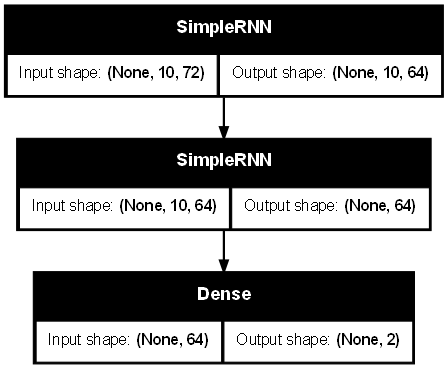

The PFE Model Classification Metrics:
Accuracy: 0.49607843137254903
Precision: 0.5031794699371311
Recall: 0.49607843137254903
F-Score: 0.4839589261150632
--------------------------------------------------------------


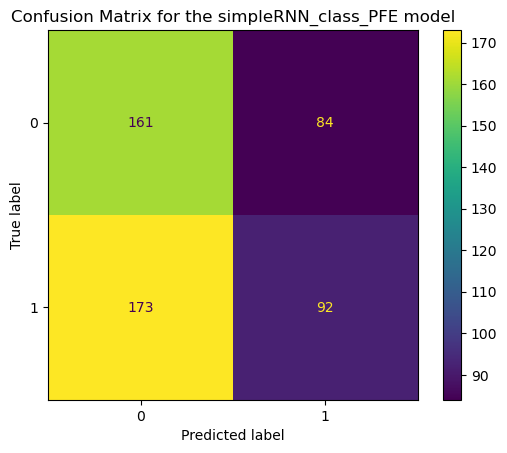

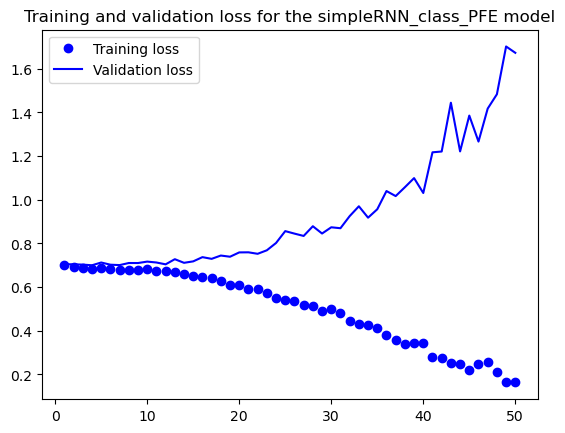

Model summary for the simpleRNN_class_ROP


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 10, 64)              │           8,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,464 (201.04 KB)

 Trainable params: 17,154 (67.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,310 (134.03 KB)

Model plot for the simpleRNN_class_ROP


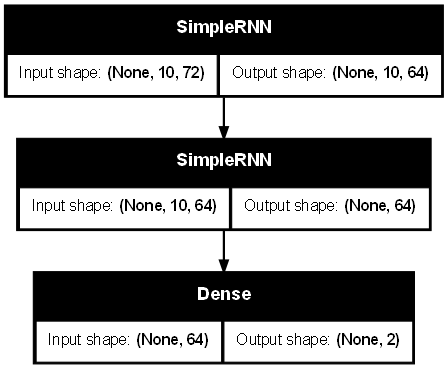

The ROP Model Classification Metrics:
Accuracy: 0.46835443037974683
Precision: 0.4741642323920805
Recall: 0.46835443037974683
F-Score: 0.47006500171057136
--------------------------------------------------------------


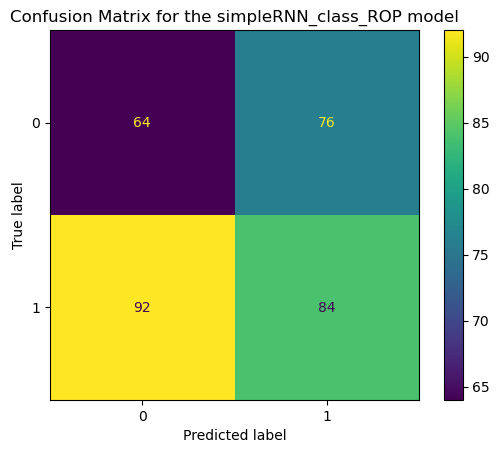

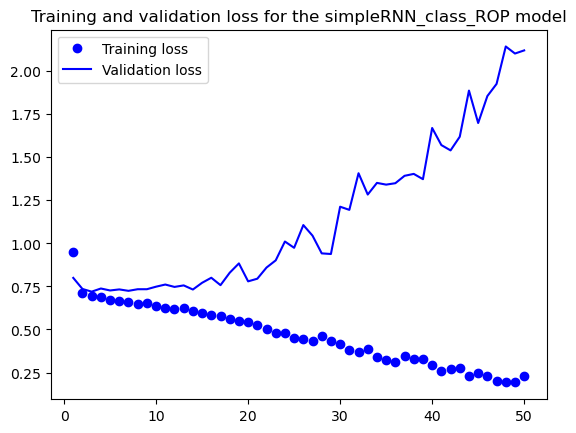

Model summary for the simpleRNN_class_XYL


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 10, 64)              │           8,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,464 (201.04 KB)

 Trainable params: 17,154 (67.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,310 (134.03 KB)

Model plot for the simpleRNN_class_XYL


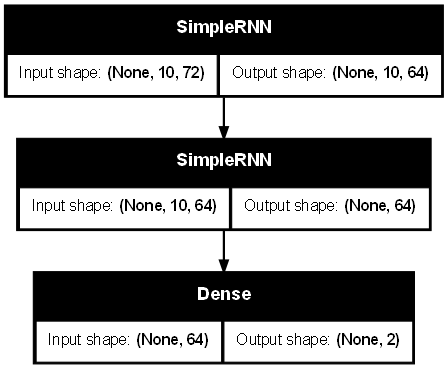

The XYL Model Classification Metrics:
Accuracy: 0.5172413793103449
Precision: 0.48762322958370996
Recall: 0.5172413793103449
F-Score: 0.4805883771401013
--------------------------------------------------------------


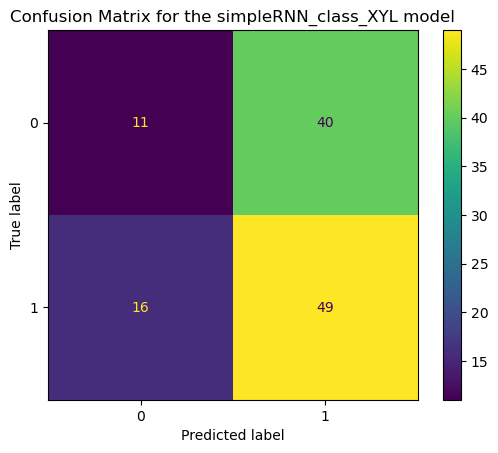

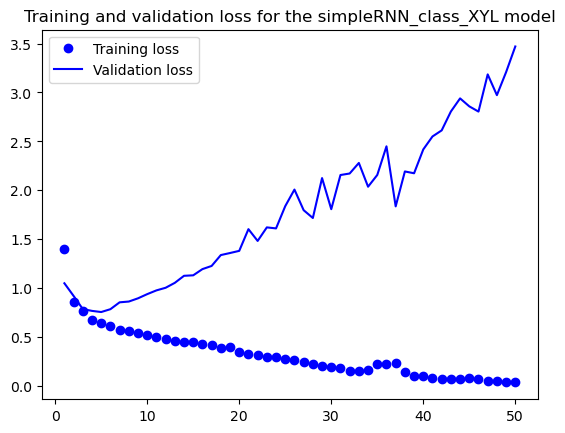

Model summary for the simpleRNN_class_CPAY


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 10, 64)              │           8,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,464 (201.04 KB)

 Trainable params: 17,154 (67.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,310 (134.03 KB)

Model plot for the simpleRNN_class_CPAY


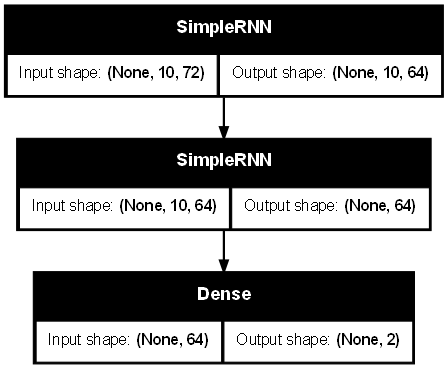

The CPAY Model Classification Metrics:
Accuracy: 0.456
Precision: 0.4618382099827883
Recall: 0.456
F-Score: 0.44152738654147106
--------------------------------------------------------------


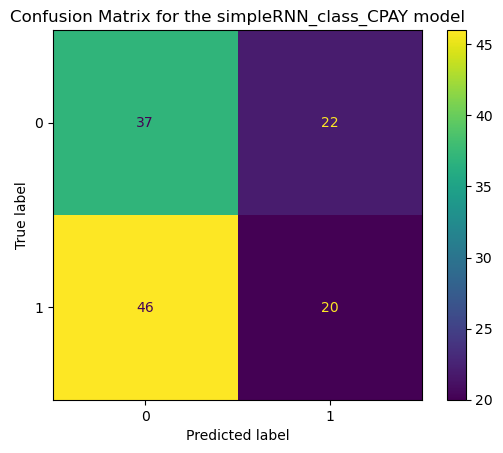

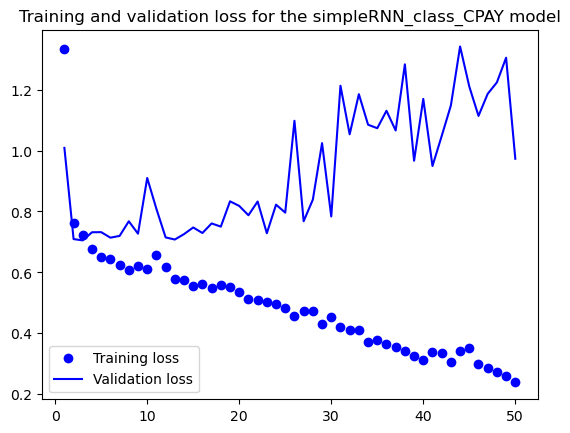

Model summary for the simpleRNN_class_INCY


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 10, 64)              │           8,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,464 (201.04 KB)

 Trainable params: 17,154 (67.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,310 (134.03 KB)

Model plot for the simpleRNN_class_INCY


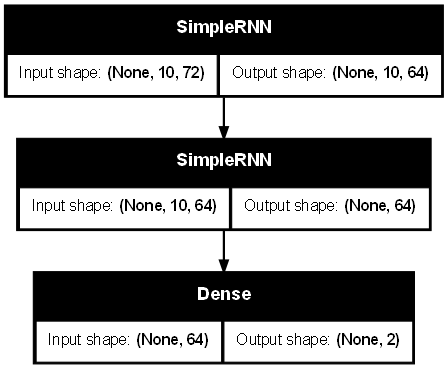

The INCY Model Classification Metrics:
Accuracy: 0.5415282392026578
Precision: 0.5265118011669055
Recall: 0.5415282392026578
F-Score: 0.5010828591164764
--------------------------------------------------------------


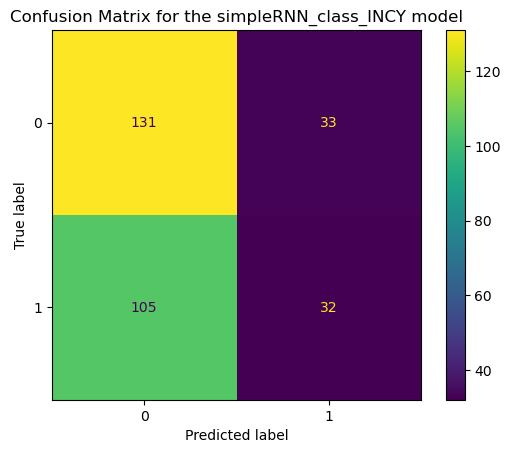

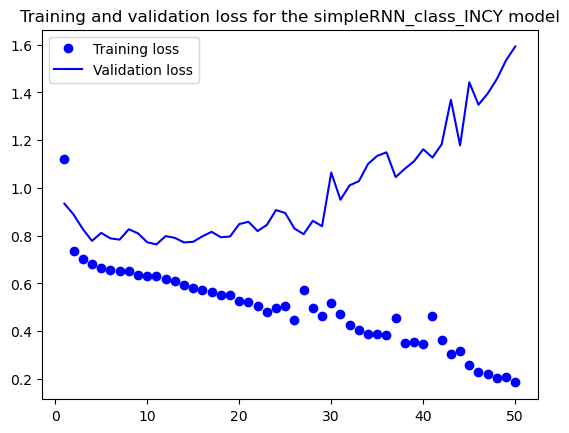

In [28]:
# evaluate the models in the archive
evaluate_models_archive(simpleRNN_models_archive)

### LSTM

In [ ]:
# set the model initialization inputs
X_train_shape = data_sets['PFE']['X_train'].shape
model_type='classification'
layer_type='LSTM'

# create the model
lstm_model = RNNModel(X_train_shape, model_type, layer_type)
lstm_model = lstm_model.build()

# create models archive for lstm classification approach
lstm_models_archive = create_models_archive(lstm_model, 
                                                 data_sets, 
                                                 _model_type=model_type, 
                                                 _tuner=None, 
                                                 _epochs=50, 
                                                 _model_name='lstm_class', 
                                                 _project_name='proj')

Model summary for the lstm_class_PFE


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          35,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,680 (799.54 KB)

 Trainable params: 68,226 (266.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 136,454 (533.03 KB)

Model plot for the lstm_class_PFE


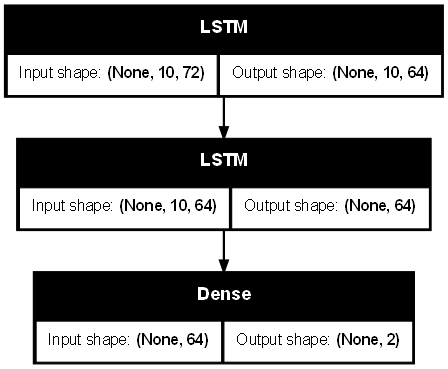

The PFE Model Classification Metrics:
Accuracy: 0.49019607843137253
Precision: 0.5490808768824913
Recall: 0.49019607843137253
F-Score: 0.3602784920890032
--------------------------------------------------------------


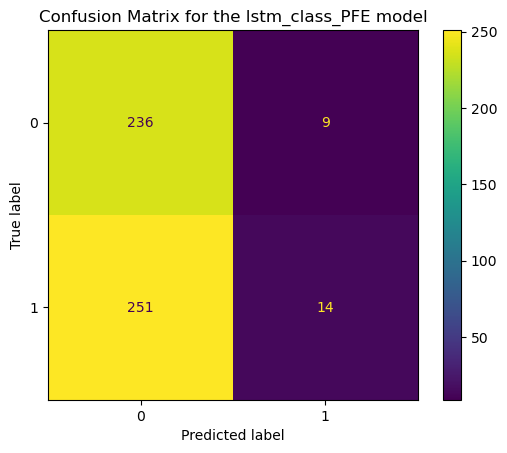

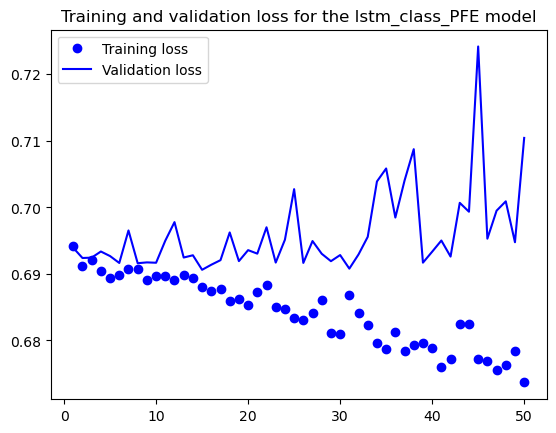

Model summary for the lstm_class_ROP


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          35,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,680 (799.54 KB)

 Trainable params: 68,226 (266.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 136,454 (533.03 KB)

Model plot for the lstm_class_ROP


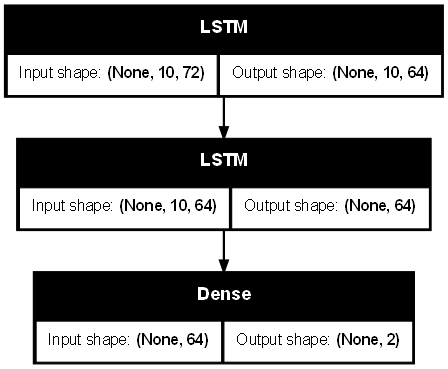

The ROP Model Classification Metrics:
Accuracy: 0.4588607594936709
Precision: 0.455105990133529
Recall: 0.4588607594936709
F-Score: 0.4566205555459952
--------------------------------------------------------------


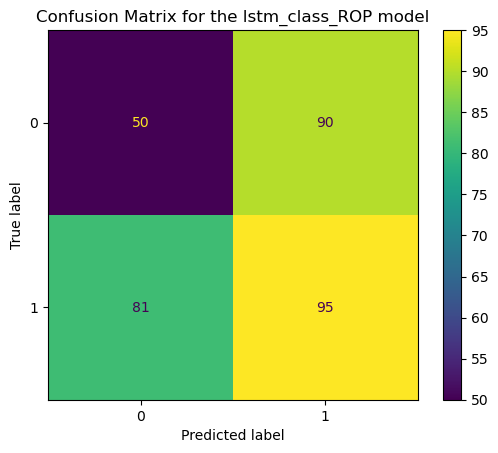

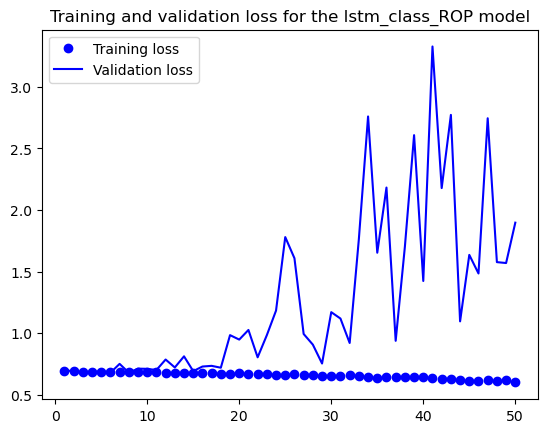

Model summary for the lstm_class_XYL


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          35,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,680 (799.54 KB)

 Trainable params: 68,226 (266.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 136,454 (533.03 KB)

Model plot for the lstm_class_XYL


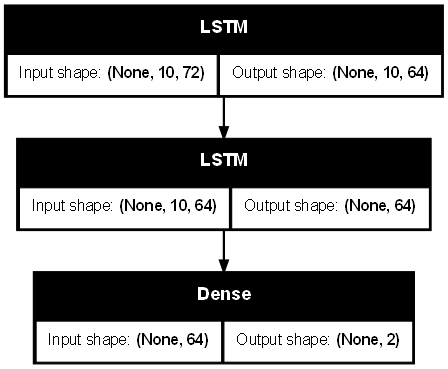

The XYL Model Classification Metrics:
Accuracy: 0.5258620689655172
Precision: 0.526867125331565
Recall: 0.5258620689655172
F-Score: 0.5263259654886939
--------------------------------------------------------------


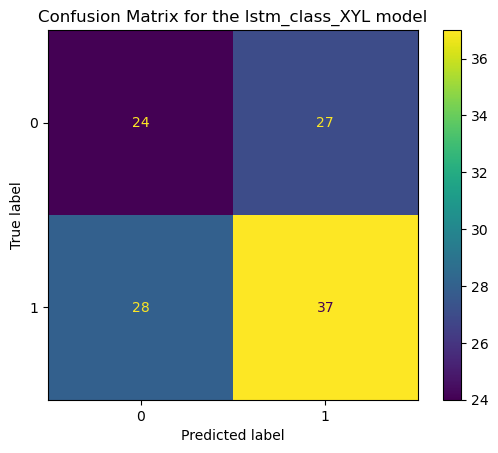

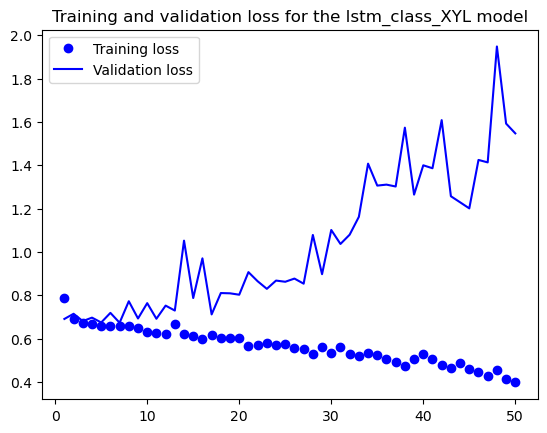

Model summary for the lstm_class_CPAY


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          35,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,680 (799.54 KB)

 Trainable params: 68,226 (266.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 136,454 (533.03 KB)

Model plot for the lstm_class_CPAY


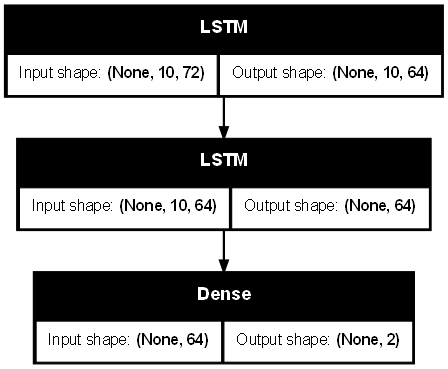

The CPAY Model Classification Metrics:
Accuracy: 0.536
Precision: 0.530291761148904
Recall: 0.536
F-Score: 0.494942711287578
--------------------------------------------------------------


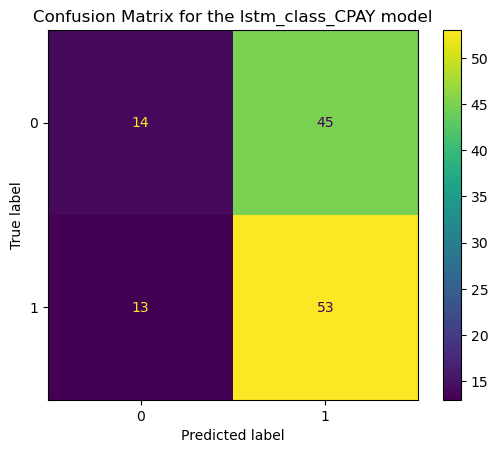

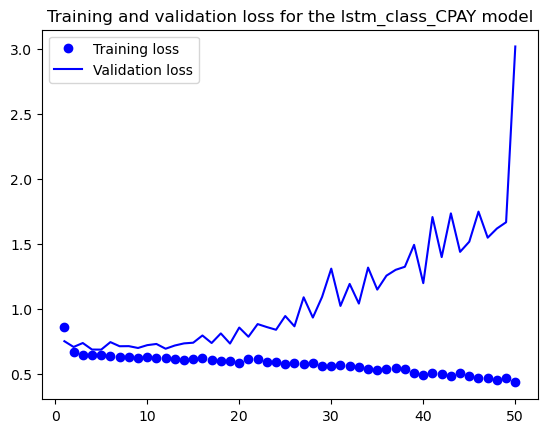

Model summary for the lstm_class_INCY


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          35,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,680 (799.54 KB)

 Trainable params: 68,226 (266.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 136,454 (533.03 KB)

Model plot for the lstm_class_INCY


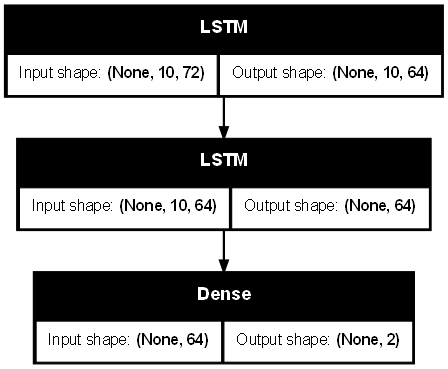

The INCY Model Classification Metrics:
Accuracy: 0.5448504983388704
Precision: 0.5249338363646602
Recall: 0.5448504983388704
F-Score: 0.40132345741100867
--------------------------------------------------------------


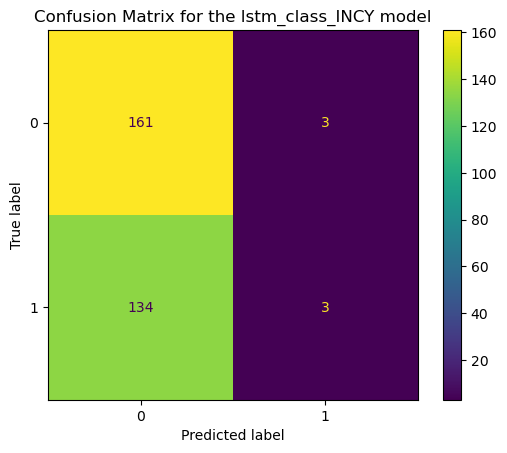

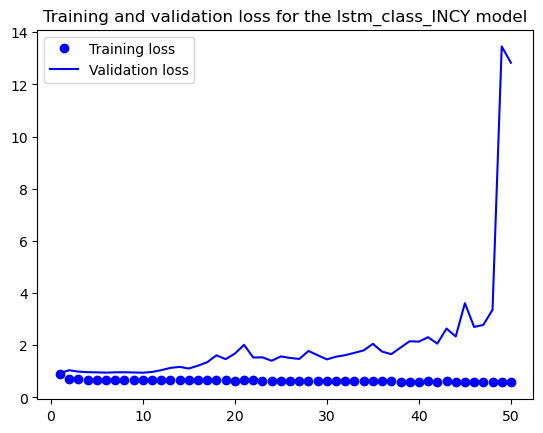

In [30]:
# evaluate the models in the archive
evaluate_models_archive(lstm_models_archive)

### GRU

In [ ]:
# set the model initialization inputs
X_train_shape = data_sets['PFE']['X_train'].shape
model_type='classification'
layer_type='GRU'

# create the model
gru_model = RNNModel(X_train_shape, model_type, layer_type)
gru_model = gru_model.build()

# create models archive for gru classification approach
gru_models_archive = create_models_archive(gru_model, 
                                                 data_sets, 
                                                 _model_type=model_type, 
                                                 _tuner=None, 
                                                 _epochs=50, 
                                                 _model_name='gru_class', 
                                                 _project_name='proj')

Model summary for the gru_class_PFE


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 10, 64)              │          26,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,760 (604.54 KB)

 Trainable params: 51,586 (201.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 103,174 (403.03 KB)

Model plot for the gru_class_PFE


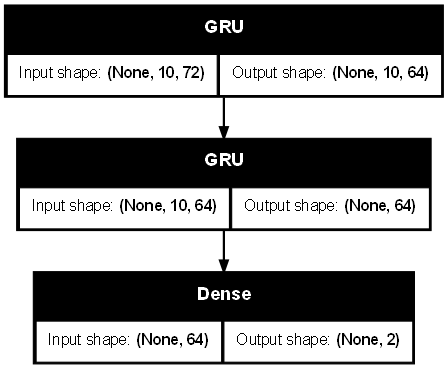

The PFE Model Classification Metrics:
Accuracy: 0.4803921568627451
Precision: 0.4849877450980392
Recall: 0.4803921568627451
F-Score: 0.47205458085208224
--------------------------------------------------------------


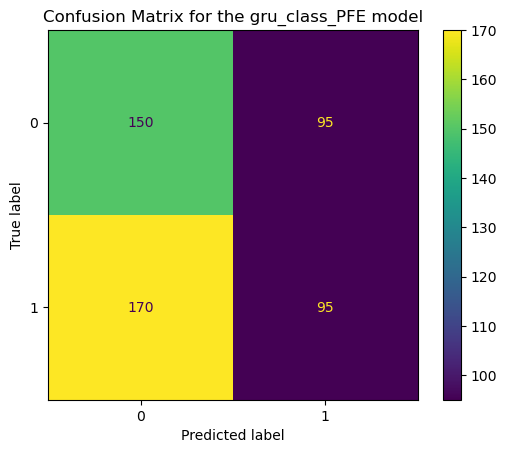

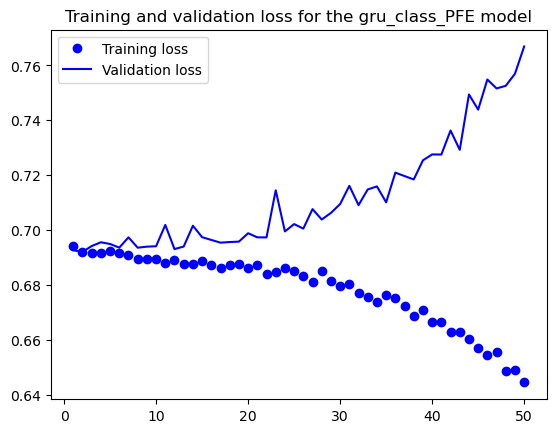

Model summary for the gru_class_ROP


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 10, 64)              │          26,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,760 (604.54 KB)

 Trainable params: 51,586 (201.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 103,174 (403.03 KB)

Model plot for the gru_class_ROP


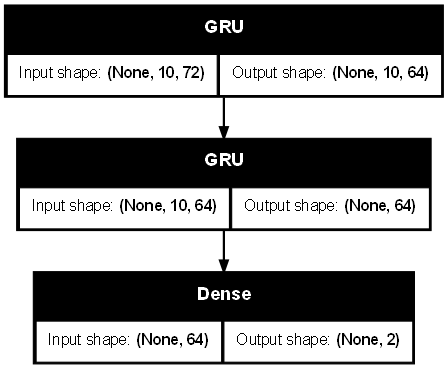

The ROP Model Classification Metrics:
Accuracy: 0.5284810126582279
Precision: 0.4834415432761923
Recall: 0.5284810126582279
F-Score: 0.45752081195119165
--------------------------------------------------------------


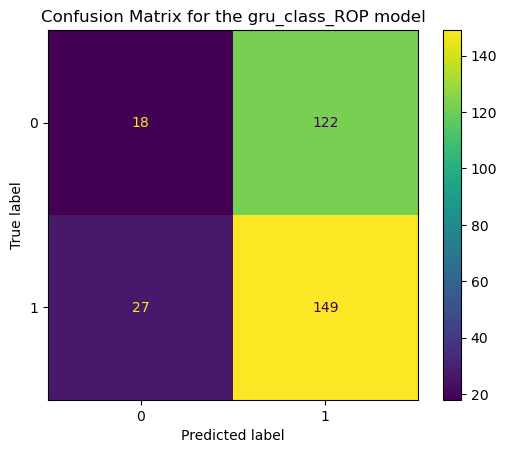

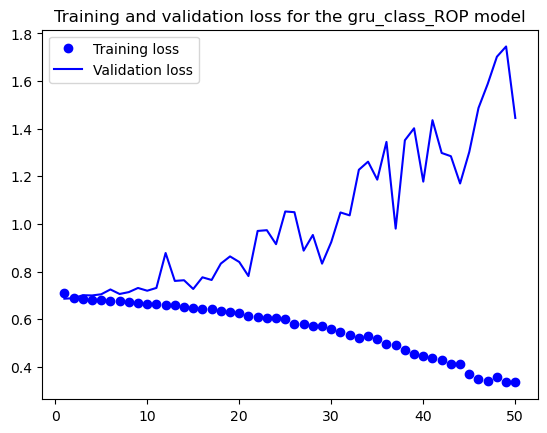

Model summary for the gru_class_XYL


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 10, 64)              │          26,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,760 (604.54 KB)

 Trainable params: 51,586 (201.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 103,174 (403.03 KB)

Model plot for the gru_class_XYL


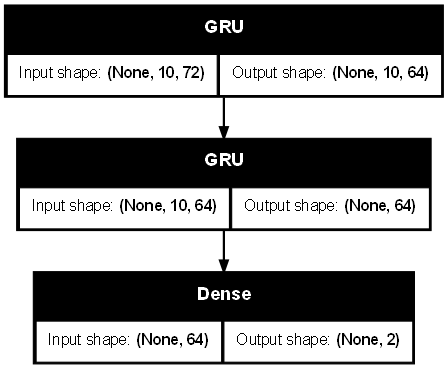

The XYL Model Classification Metrics:
Accuracy: 0.5344827586206896
Precision: 0.507487684729064
Recall: 0.5344827586206896
F-Score: 0.49364791288566245
--------------------------------------------------------------


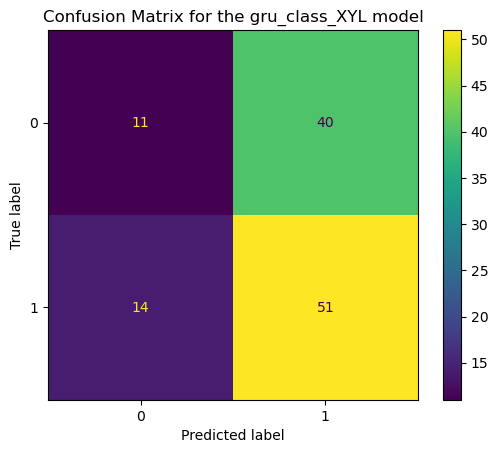

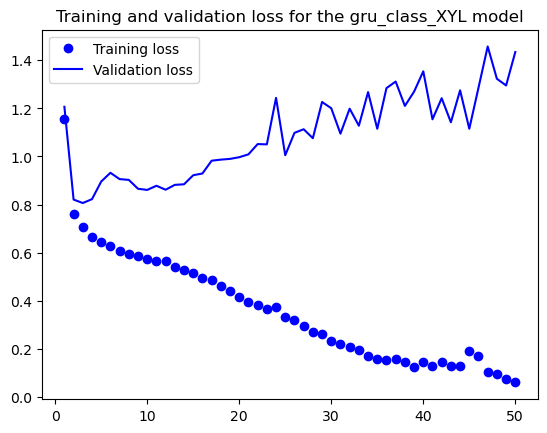

Model summary for the gru_class_CPAY


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 10, 64)              │          26,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,760 (604.54 KB)

 Trainable params: 51,586 (201.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 103,174 (403.03 KB)

Model plot for the gru_class_CPAY


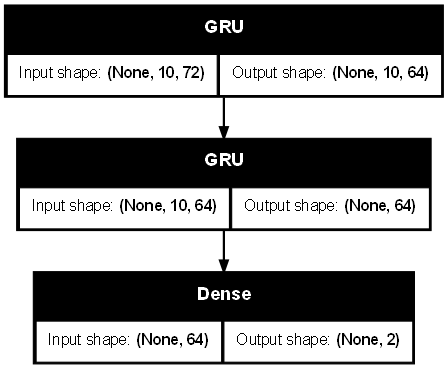

The CPAY Model Classification Metrics:
Accuracy: 0.472
Precision: 0.4597073170731707
Recall: 0.472
F-Score: 0.45616
--------------------------------------------------------------


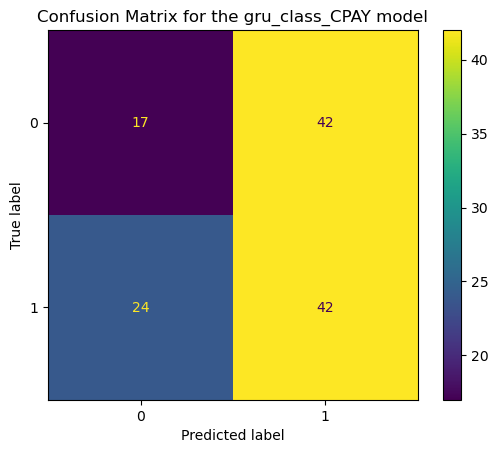

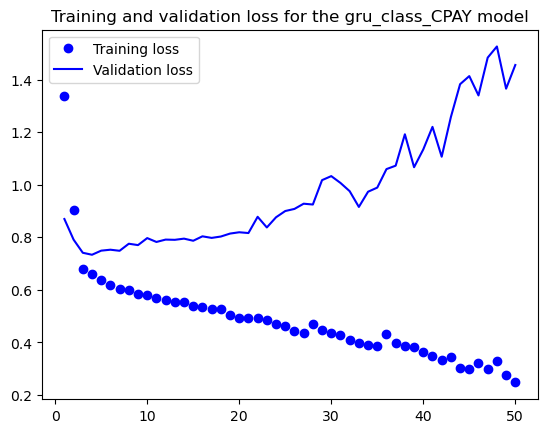

Model summary for the gru_class_INCY


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 10, 64)              │          26,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,760 (604.54 KB)

 Trainable params: 51,586 (201.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 103,174 (403.03 KB)

Model plot for the gru_class_INCY


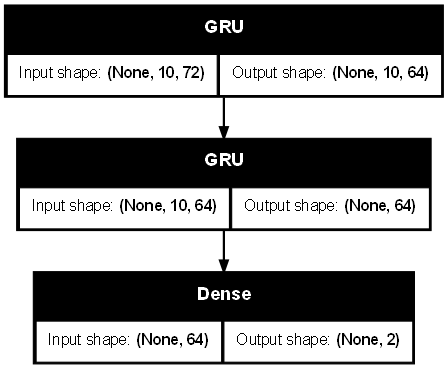

The INCY Model Classification Metrics:
Accuracy: 0.5049833887043189
Precision: 0.47991532349712507
Recall: 0.5049833887043189
F-Score: 0.46894360960904924
--------------------------------------------------------------


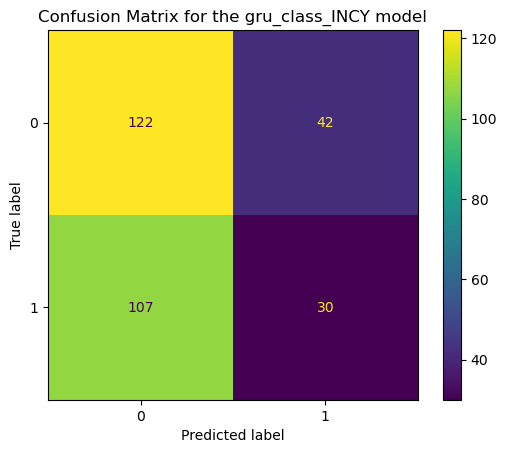

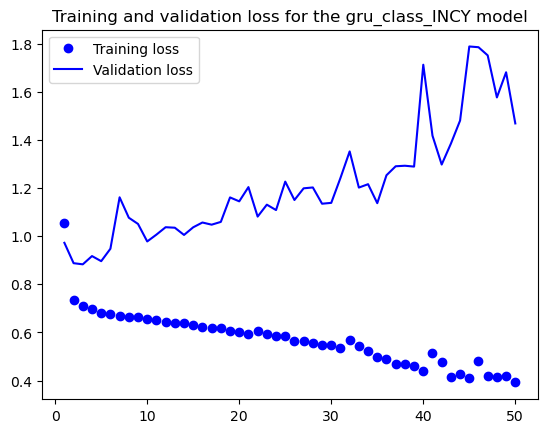

In [32]:
# evaluate the models in the archive
evaluate_models_archive(gru_models_archive)

## Classification vs Regression approach

Initially, we explored regression models to predict the actual future closing prices of stocks, aiming to leverage this for advanced tasks like portfolio optimization. However, after extensive experimentation, the results were underwhelming. In most cases, the mean absolute error (MAE) exceeded the average price on the test set, making the regression models impractical for our purposes. Given these findings, we shifted focus to a classification approach, which has shown more promise in capturing stock market trends, and we will proceed with refining this method for the rest of the project.

##### We can simply create a regression model and train it on all the datasets in our stock list

In [ ]:
# apply the 3 steps of preparing data for training on each dataframe in the dictionary
target = 'regression' # set the target
timesteps = 10 # set the timesteps
data_sets_reg = prepare_data_to_train(full_dfs.copy(), min_max_scaler, target, timesteps)

# set the model initialization inputs
X_train_shape = data_sets_reg['PFE']['X_train'].shape
model_type='regression'
layer_type='SimpleRNN'

# create the model
simpleRNN_model_reg = RNNModel(X_train_shape, model_type, layer_type)
simpleRNN_model_reg = simpleRNN_model_reg.build()

# create models archive for simpleRNN regression approach
simpleRNN_models_reg_archive = create_models_archive(simpleRNN_model_reg, 
                                                 data_sets_reg, 
                                                 _model_type=model_type, 
                                                 _tuner=None, 
                                                 _epochs=50, 
                                                 _model_name='simpleRNN_reg', 
                                                 _project_name='proj')

## BatchNormalization

Based on what we learned from François Chollet (11, 2017), “Deep Learning with Python”, chapter 7,  BatchNormalization is a tensorflow layer type that adaptively normalize data as the mean and variance changes while training. It helps with gradient propagation allowing for deeper networks.


We will add one BatchNormalization layer after each RNN layer and see if there are any improvements.

In [34]:
# define a model class that allow us to build SimpleRNN, LSTM, or GRU models for classification or regression approches
class RNNModelNorm:
    def __init__(self, X_train_shape, model_type='classification', layer_type='SimpleRNN'):
        self.X_train_shape = X_train_shape
        self.model_type = model_type
        self.layer_type = layer_type

    def build(self):
        # initialize a sequential model
        model = Sequential()

        # add the model layers
        # input layer
        model.add(Input(shape=(self.X_train_shape[1], self.X_train_shape[2])))

        # RNN layers
        # set the layer type
        if self.layer_type == 'SimpleRNN':
            RNN_layer = SimpleRNN
        elif self.layer_type == 'LSTM':
            RNN_layer = LSTM
        elif self.layer_type == 'GRU':
            RNN_layer = GRU
        else:
            raise ValueError('Wrong layer type provided!!! only support (SimpleRNN, LSTM, GRU)')

        # add the selected layers to the model
        model.add(RNN_layer(64, activation='relu', return_sequences=True))
        model.add(BatchNormalization())
        model.add(RNN_layer(64, activation='relu', return_sequences=False))
        model.add(BatchNormalization())

        # set the model type and compile it
        if self.model_type == 'classification':
            model.add(Dense(2, activation='softmax')) # output layer
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compile the model
        elif self.model_type == 'regression':
            model.add(Dense(1)) # output layer
            model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae']) # compile the model
        else:
            raise ValueError('Wrong model type provided!!! only support (classification, regression)')

        return model

In [ ]:
# set the model initialization inputs
X_train_shape = data_sets['PFE']['X_train'].shape
model_type='classification'
layer_type='SimpleRNN'

# create the model
simpleRNN_norm_model = RNNModelNorm(X_train_shape, model_type, layer_type)
simpleRNN_norm_model = simpleRNN_norm_model.build()

# create models archive for simpleRNN_norm_model classification approach
simpleRNN_norm_models_archive = create_models_archive(simpleRNN_norm_model, 
                                                 data_sets, 
                                                 _model_type=model_type, 
                                                 _tuner=None, 
                                                 _epochs=50, 
                                                 _model_name='simpleRNN_norm_class', 
                                                 _project_name='proj')

Model summary for the simpleRNN_norm_class_PFE


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)             │ (None, 10, 64)              │           8,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,488 (205.04 KB)

 Trainable params: 17,410 (68.01 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 34,822 (136.03 KB)

Model plot for the simpleRNN_norm_class_PFE


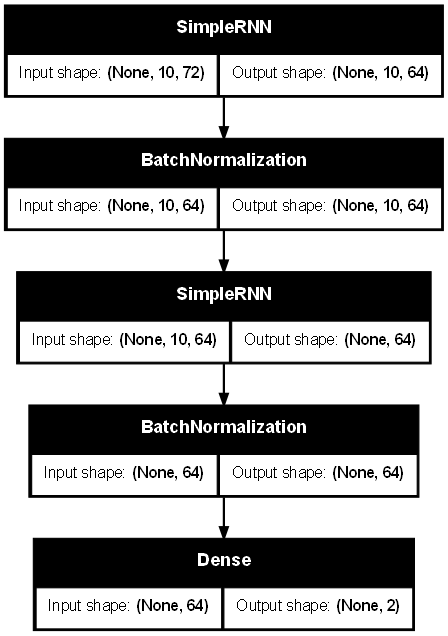

The PFE Model Classification Metrics:
Accuracy: 0.4764705882352941
Precision: 0.47773692810457513
Recall: 0.4764705882352941
F-Score: 0.37533516554060964
--------------------------------------------------------------


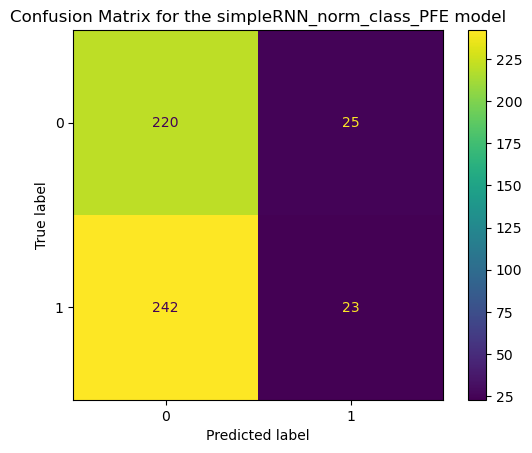

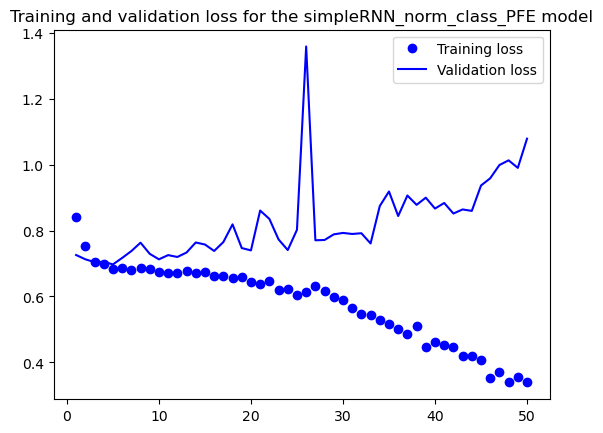

Model summary for the simpleRNN_norm_class_ROP


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)             │ (None, 10, 64)              │           8,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,488 (205.04 KB)

 Trainable params: 17,410 (68.01 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 34,822 (136.03 KB)

Model plot for the simpleRNN_norm_class_ROP


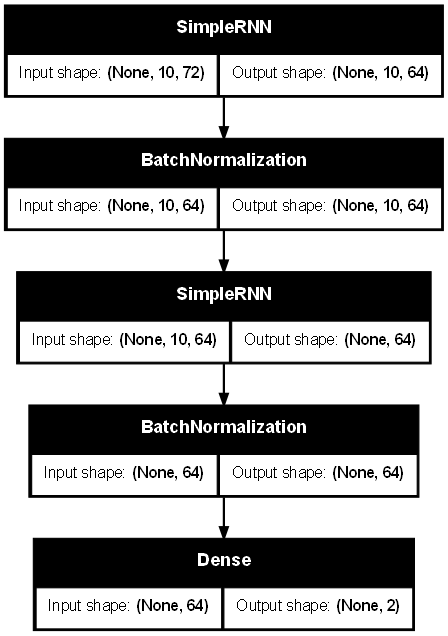

The ROP Model Classification Metrics:
Accuracy: 0.5537974683544303
Precision: 0.5224915969391403
Recall: 0.5537974683544303
F-Score: 0.4452639438565003
--------------------------------------------------------------


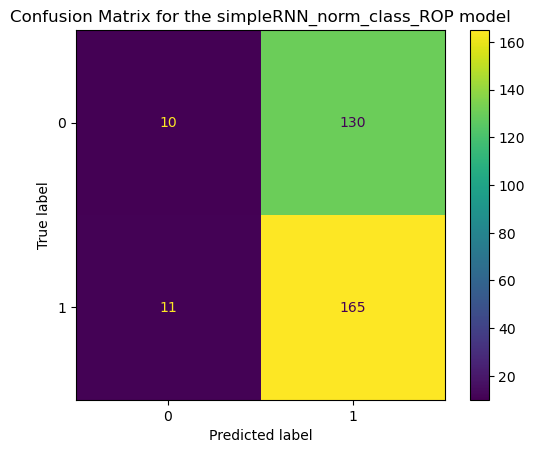

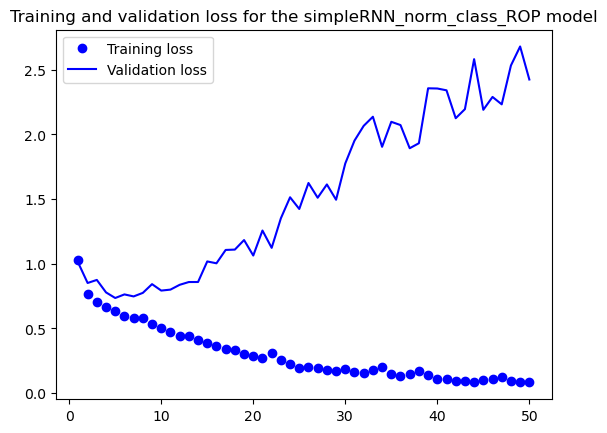

Model summary for the simpleRNN_norm_class_XYL


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)             │ (None, 10, 64)              │           8,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,488 (205.04 KB)

 Trainable params: 17,410 (68.01 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 34,822 (136.03 KB)

Model plot for the simpleRNN_norm_class_XYL


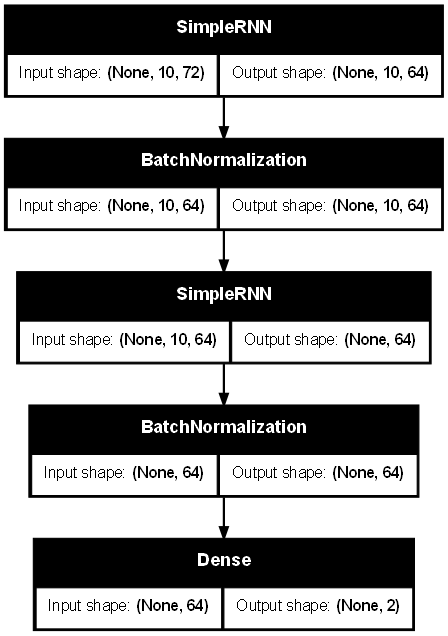

The XYL Model Classification Metrics:
Accuracy: 0.49137931034482757
Precision: 0.4966133004926109
Recall: 0.49137931034482757
F-Score: 0.4930905575249759
--------------------------------------------------------------


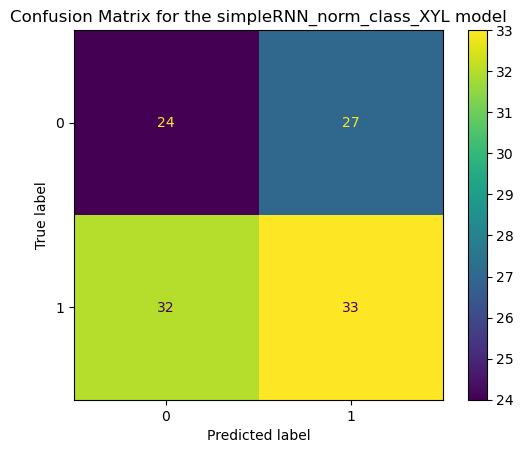

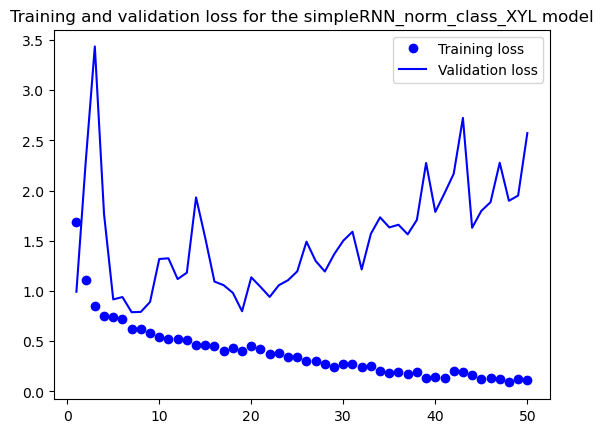

Model summary for the simpleRNN_norm_class_CPAY


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)             │ (None, 10, 64)              │           8,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,488 (205.04 KB)

 Trainable params: 17,410 (68.01 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 34,822 (136.03 KB)

Model plot for the simpleRNN_norm_class_CPAY


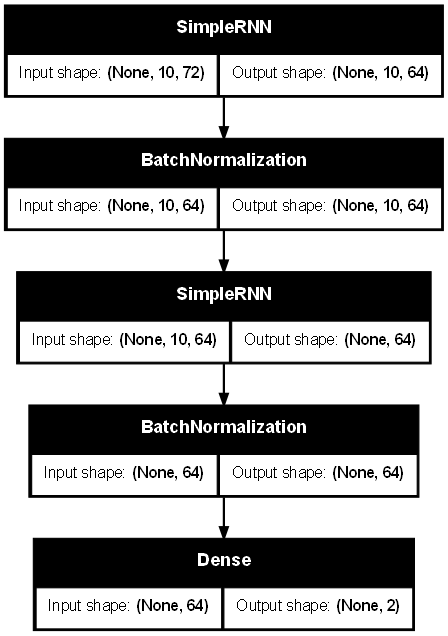

The CPAY Model Classification Metrics:
Accuracy: 0.512
Precision: 0.5037294117647059
Recall: 0.512
F-Score: 0.49587370392668406
--------------------------------------------------------------


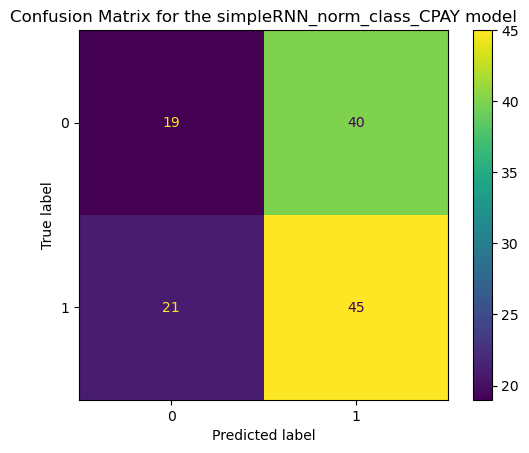

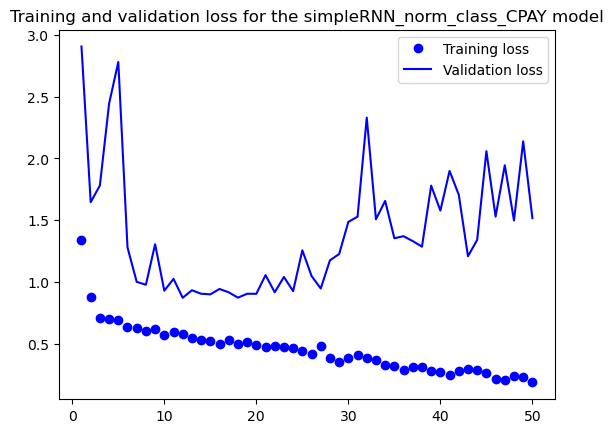

Model summary for the simpleRNN_norm_class_INCY


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)             │ (None, 10, 64)              │           8,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,488 (205.04 KB)

 Trainable params: 17,410 (68.01 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 34,822 (136.03 KB)

Model plot for the simpleRNN_norm_class_INCY


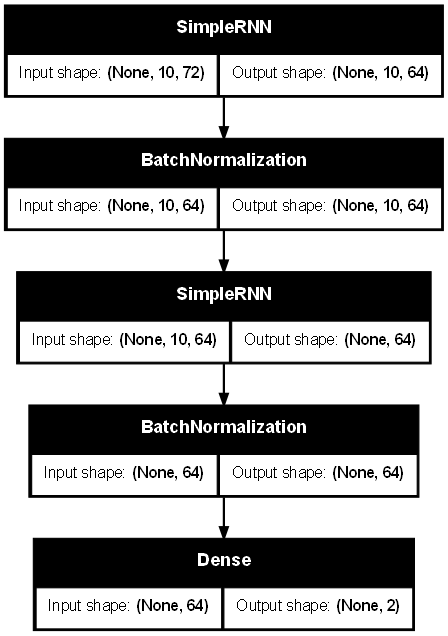

The INCY Model Classification Metrics:
Accuracy: 0.5448504983388704
Precision: 0.29686206554011546
Recall: 0.5448504983388704
F-Score: 0.38432465259171933
--------------------------------------------------------------


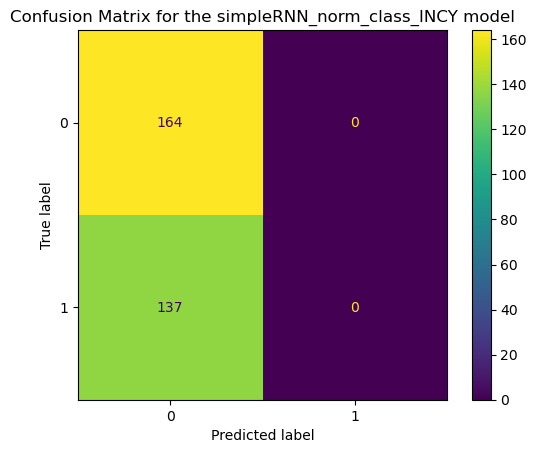

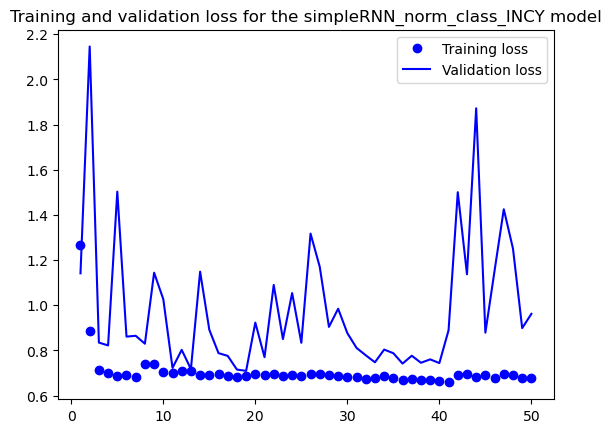

In [36]:
# evaluate the models in the archive
evaluate_models_archive(simpleRNN_norm_models_archive)

On average we see worst performance.

## Hyperparameter Optimization

We implemented hyperparameter optimization using keras_tuner library. HP_RNNModel, a class we created, inherates from keras_tuner's HyperModel class. HP_RNNModel allows us to optimize: 

1. Model hyperparameters:
- Number of RNN layers (2-4)
- Layer type (SimpleRNN, LSTM, GRU)
- Units per layer (64-128)
- Recurrent dropout (0.0-0.5)
2. Algorithm hyperparameters:
- Optimizer type (Adam, RMSprop, SGD)
- Learning rate (0.0001-0.01)
3. training  hyperparameters:
- Batch size (32, 64)

Hyperband[26] is the tuner we used as it's computationally efficient, making it suitable for tuning multiple models quickly. 

create_models_archive was created to be compatible with this approach by being able to use the passed tuner for optimization. create_models_archive also optimizes the number of epochs using the EarlyStopping callback from tensorflow.

In [37]:
# source of inspiration: Introduction to the Keras Tuner, https://www.tensorflow.org/tutorials/keras/keras_tuner [26]
# constuct the model which will perform hyperparameter optimization to choose layers count, neurons counts, recurrent_dropout, optimizer_type, optimizer learning rate
class HP_RNNModel(HyperModel):

    # initialize the model upon creating a class instance
    # using a class structure instead of a function to construct the model will allow us to pass variables to it before passing it to keras tuner
    # source of inspiration on how to pass variables to the model before passing the model to keras tuner: https://github.com/JulieProst/keras-tuner-tutorial/blob/master/hypermodels.py [33]
    def __init__(self, X_train_shape):
        self.X_train_shape = X_train_shape
    
    # build the model
    def build(self, hp):
        # initialize a sequential model
        model = Sequential()

        ### add the model layers (Model hyperparameters optimization)
        # input layer
        model.add(Input(shape=(self.X_train_shape[1], self.X_train_shape[2])))

        # source: Int method, https://keras.io/api/keras_tuner/hyperparameters/
        # dynamically optimize the number of layers
        hp_layers = hp.Int(name='hp_layers', 
                           min_value=2, 
                           max_value=4, 
                           step=2)

        # for each optimized layer
        for i in range(hp_layers):
            
            # optimize the layer type
            hp_layer_type = hp.Choice(f'RNN_layer_{i}_type', values=['SimpleRNN', 'LSTM', 'GRU'])
            if hp_layer_type == 'SimpleRNN':
                layer_type = SimpleRNN
            elif hp_layer_type == 'LSTM':
                layer_type = LSTM
            else:
                layer_type = GRU

            # dynamically tune the number of units in each layer, select a value between 64-128
            hp_units = hp.Int(name=f'hp_units_at_hp_layer_{i}', 
                              min_value=64, 
                              max_value=128, 
                              step=64)
            
            # source: SimpleRNN layer, https://keras.io/api/layers/recurrent_layers/simple_rnn/
            # return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.
            # set the return_sequences parameter to true unless it's the last layer, set it to false
            return_sequences_boolean = i != (hp_layers - 1)

            # source: Float method, https://keras.io/api/keras_tuner/hyperparameters/
            # source: SimpleRNN layer, https://keras.io/api/layers/recurrent_layers/simple_rnn/
            # recurrent_dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state.
            # dynamically tune the recurrent_dropout float value
            recurrent_dropout = hp.Float(name=f'recurrent_dropout_{i}', 
                                         min_value=0.0, 
                                         max_value=0.5, 
                                         step=0.1)

            # add an RNN layer and pass the optimized number of unites, recurrent_dropout, and the return_sequences boolean
            layer = layer_type(units=hp_units, 
                               activation='relu',
                              return_sequences=return_sequences_boolean, 
                              recurrent_dropout=recurrent_dropout)
            model.add(layer)


        # add the output layer
        model.add(Dense(2, activation='softmax'))

        ### the model compiler (Algorithm hyperparameters optimization)
        # source: Choice method, https://keras.io/api/keras_tuner/hyperparameters/
        # dynamically optimize the optimizer type
        hp_optimizer_type = hp.Choice('optimizer_type', values=['Adam', 'RMSprop', 'SGD'])
        if hp_optimizer_type == 'Adam':
            optimizer = Adam
        elif hp_optimizer_type == 'RMSprop':
            optimizer = RMSprop
        else:
            optimizer = SGD

        # dynamically tune the learning rate for the optimizer
        # When sampling="log", the step is multiplied between samples.
        hp_lr = hp.Float('learning_rate', 
                         min_value=0.0001, 
                         max_value=0.01, 
                         sampling='LOG')
        hp_optimizer = optimizer(learning_rate=hp_lr)

        # compile the model
        model.compile(optimizer=hp_optimizer, 
                      loss='categorical_crossentropy', # this is the most suitable one for predictions of one-hot encoded labels
                      metrics=['accuracy'])

        # return the model
        return model
    
    # source: omalleyt12, https://github.com/keras-team/keras-tuner/issues/122 [34]
    # define a fit function which will allow us to pass an optimized value for batch_size
    # *args and **kwargs are the ones we pass through tuner.search()
    def fit(self, hp, model, *args, **kwargs):
        
        # dynamically optimize the batch_size for the training process
        hp_batch_size = hp.Choice("batch_size", [32, 64])
        return model.fit(
            *args,
            batch_size=hp_batch_size,
            **kwargs,
        )

In [ ]:
# set the model initialization inputs
X_train_shape = data_sets['PFE']['X_train'].shape
model_type='classification'
tuner = Hyperband

# create the model
hp_RNN_model = HP_RNNModel(X_train_shape)
# hp_RNN_model = hp_RNN_model.build()

# create models archive for HP_RNNModel classification approach
hp_RNN_models_archive = create_models_archive(hp_RNN_model, 
                                                 data_sets, 
                                                 _model_type=model_type, 
                                                 _tuner=tuner, 
                                                 _epochs=100, 
                                                 _model_name='hp_RNN_model', 
                                                 _project_name='hp_RNN_models_archive')

Model summary for the hp_RNN_model_PFE


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)             │ (None, 10, 128)             │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 10, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 10, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_7 (SimpleRNN)             │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 324,230 (1.24 MB)

 Trainable params: 162,114 (633.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 162,116 (633.27 KB)

Model plot for the hp_RNN_model_PFE


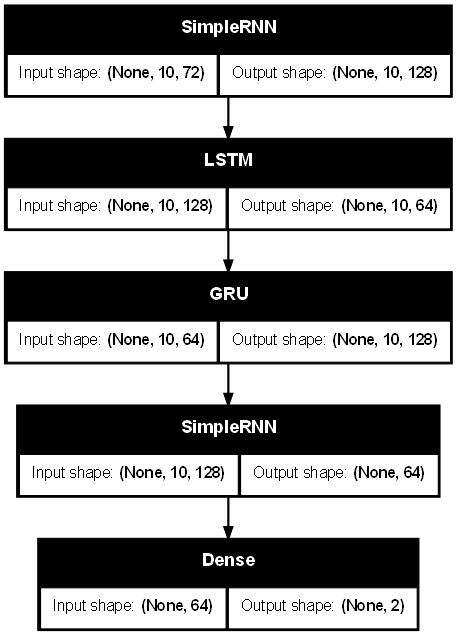

The PFE Model Classification Metrics:
Accuracy: 0.47843137254901963
Precision: 0.2302862205786047
Recall: 0.47843137254901963
F-Score: 0.3109169397201852
--------------------------------------------------------------


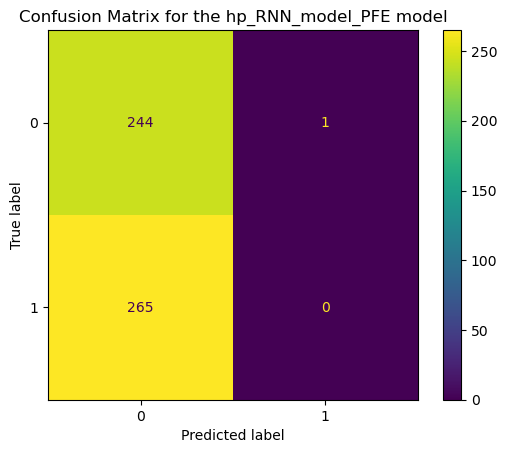

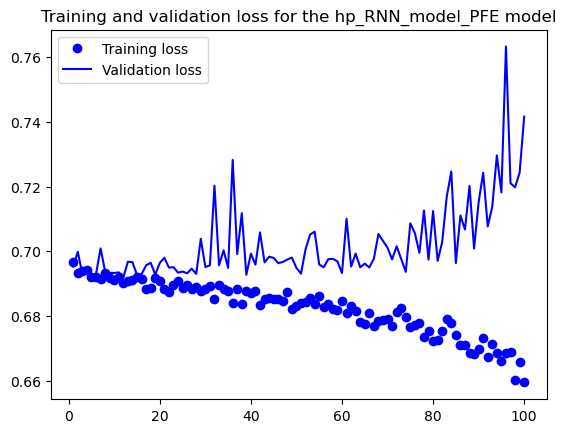

Model summary for the hp_RNN_model_ROP


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 10, 64)              │          35,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 402,440 (1.54 MB)

 Trainable params: 134,146 (524.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 268,294 (1.02 MB)

Model plot for the hp_RNN_model_ROP


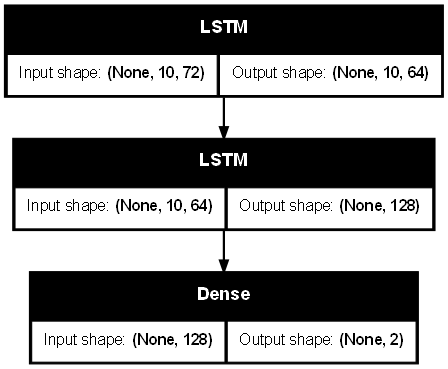

The ROP Model Classification Metrics:
Accuracy: 0.509493670886076
Precision: 0.4799621828877567
Recall: 0.509493670886076
F-Score: 0.4735762758647954
--------------------------------------------------------------


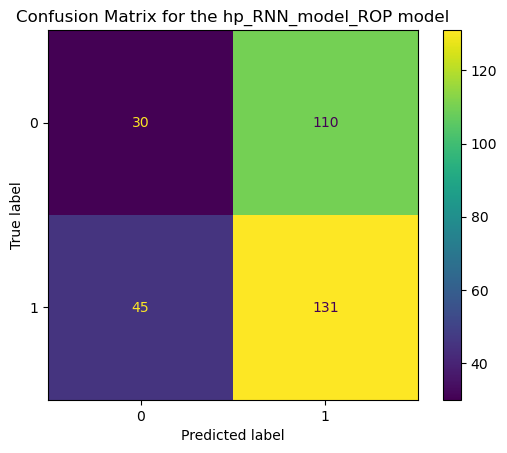

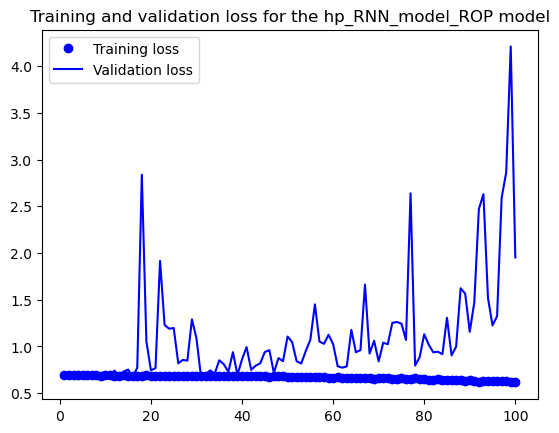

Model summary for the hp_RNN_model_XYL


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)             │ (None, 10, 128)             │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 10, 128)             │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_9 (SimpleRNN)             │ (None, 10, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_10 (SimpleRNN)            │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 436,616 (1.67 MB)

 Trainable params: 145,538 (568.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 291,078 (1.11 MB)

Model plot for the hp_RNN_model_XYL


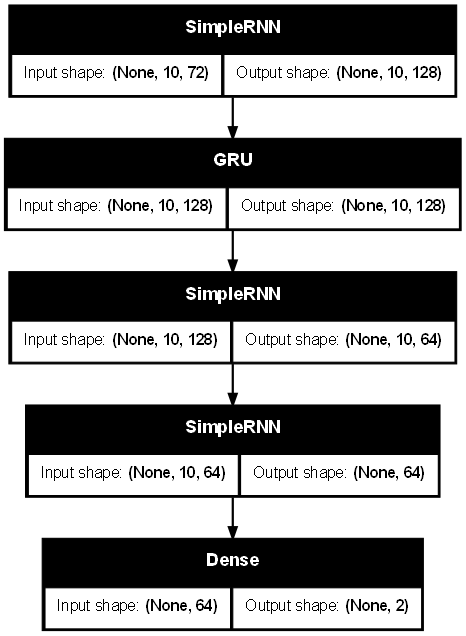

The XYL Model Classification Metrics:
Accuracy: 0.5517241379310345
Precision: 0.5238592824799722
Recall: 0.5517241379310345
F-Score: 0.4861227922624054
--------------------------------------------------------------


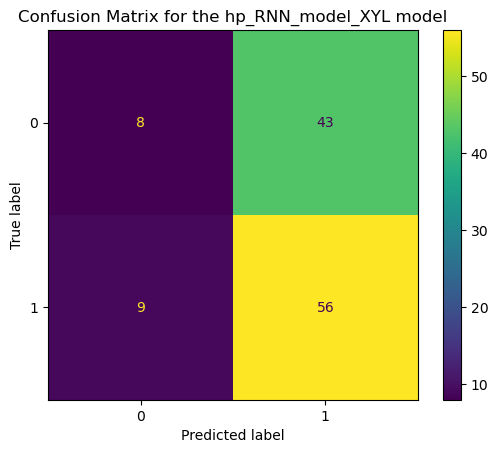

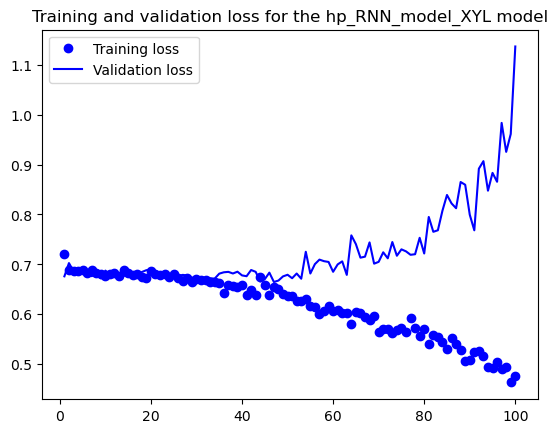

Model summary for the hp_RNN_model_CPAY


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 10, 64)              │          35,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 402,440 (1.54 MB)

 Trainable params: 134,146 (524.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 268,294 (1.02 MB)

Model plot for the hp_RNN_model_CPAY


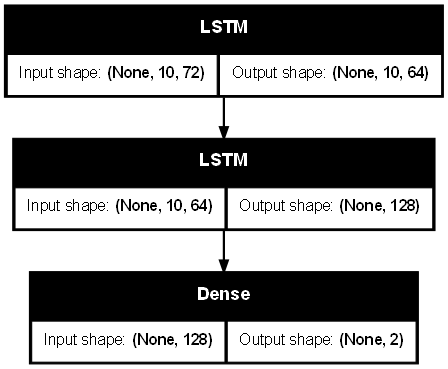

The CPAY Model Classification Metrics:
Accuracy: 0.464
Precision: 0.4247179487179487
Recall: 0.464
F-Score: 0.4135529411764706
--------------------------------------------------------------


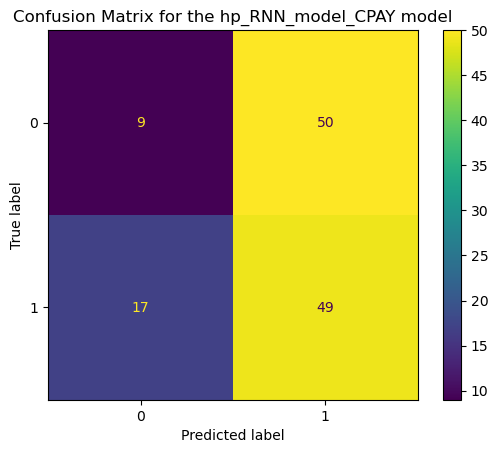

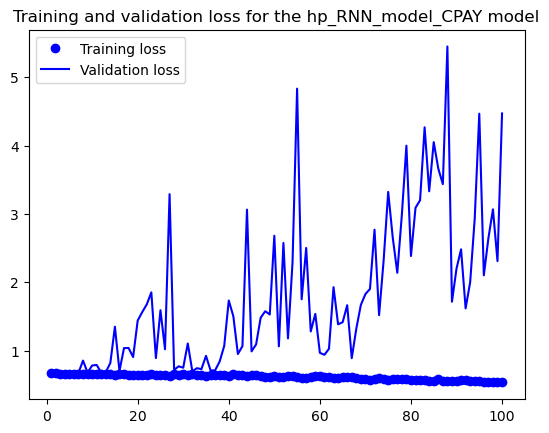

Model summary for the hp_RNN_model_INCY


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_11 (SimpleRNN)            │ (None, 10, 64)              │           8,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 10, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 10, 64)              │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 199,814 (780.53 KB)

 Trainable params: 99,906 (390.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,908 (390.27 KB)

Model plot for the hp_RNN_model_INCY


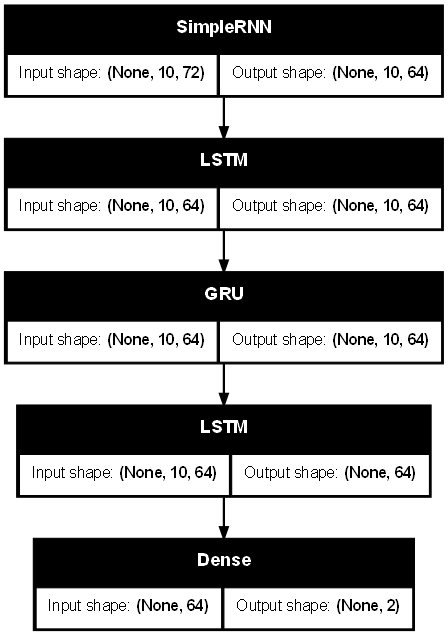

The INCY Model Classification Metrics:
Accuracy: 0.4750830564784053
Precision: 0.49743558338564237
Recall: 0.4750830564784053
F-Score: 0.449731682315252
--------------------------------------------------------------


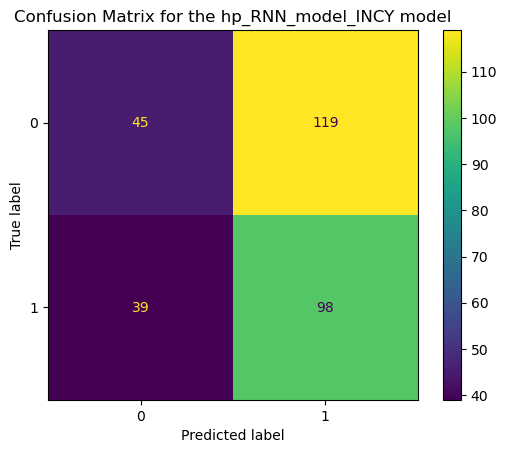

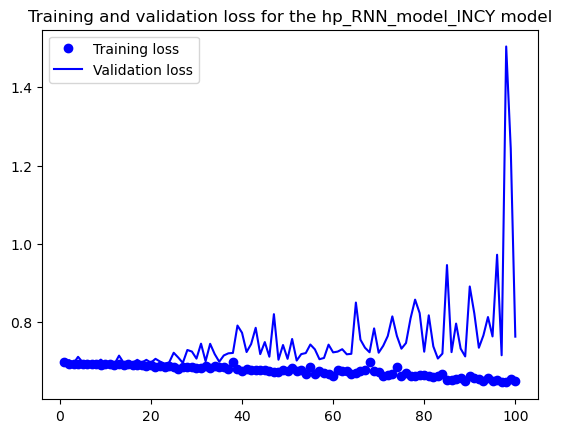

In [39]:
# evaluate the models in the archive
evaluate_models_archive(hp_RNN_models_archive)

#### Enhancing the hyperparameter optimization approach with convolution

See HP_RNN_CONV_Model(10)

In [ ]:
# set the model initialization inputs
X_train_shape = data_sets['PFE']['X_train'].shape
model_type='classification'
tuner = Hyperband

# create the model
hp_RNN_conv_model = HP_RNN_CONV_Model(X_train_shape)

# create models archive for HP_RNNModel classification approach
hp_RNN_conv_models_archive = create_models_archive(hp_RNN_conv_model, 
                                                 data_sets, 
                                                 _model_type=model_type, 
                                                 _tuner=tuner, 
                                                 _epochs=50, 
                                                 _model_name='hp_RNN_model', 
                                                 _project_name='hp_RNN_models_archive_conv')

Model summary for the hp_RNN_model_PFE


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 5, 64)               │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_12 (SimpleRNN)            │ (None, 2, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_13 (SimpleRNN)            │ (None, 2, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_14 (SimpleRNN)            │ (None, 2, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 188,166 (735.03 KB)

 Trainable params: 94,082 (367.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 94,084 (367.52 KB)

Model plot for the hp_RNN_model_PFE


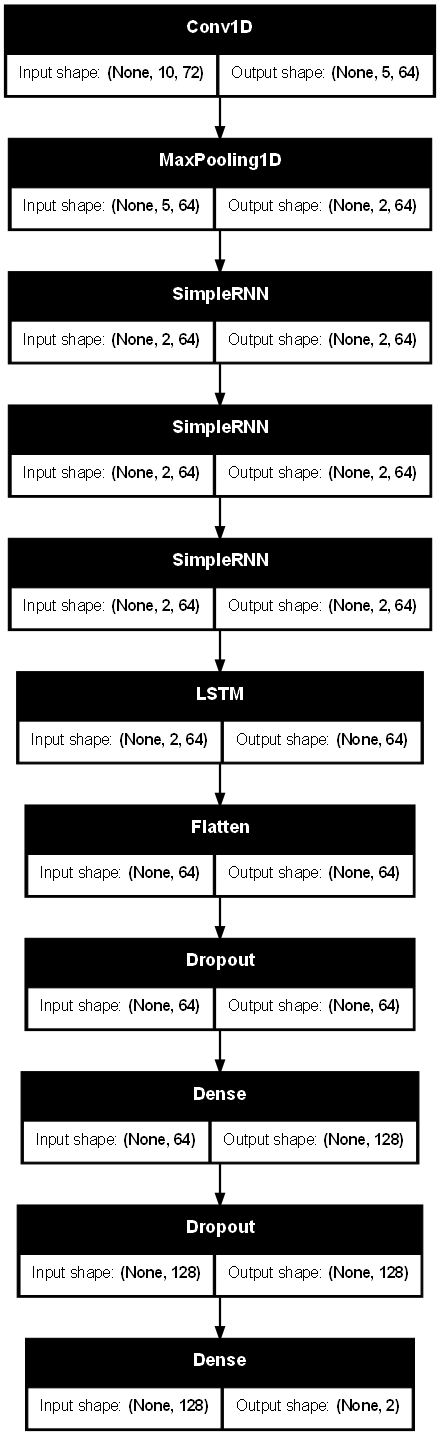

The PFE Model Classification Metrics:
Accuracy: 0.4764705882352941
Precision: 0.4029139433551198
Recall: 0.4764705882352941
F-Score: 0.31681370689462807
--------------------------------------------------------------


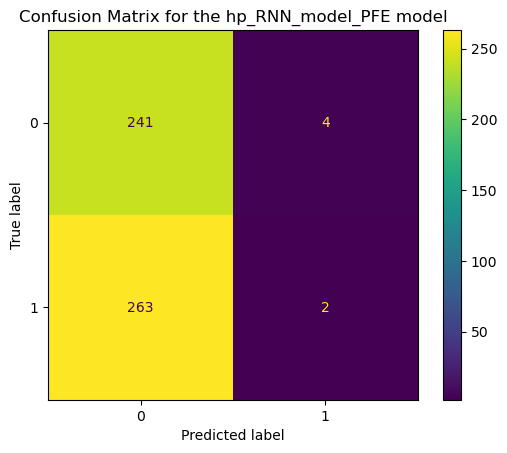

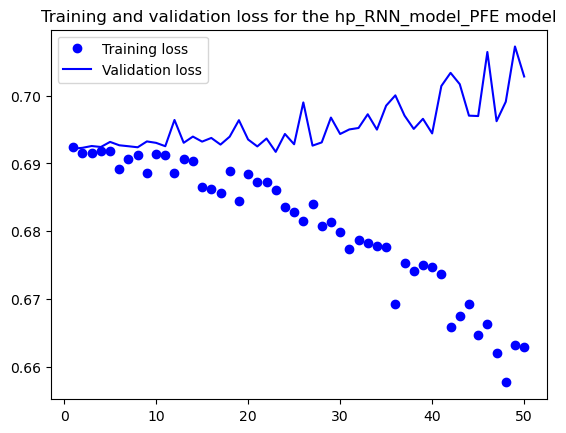

Model summary for the hp_RNN_model_ROP


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 5, 64)               │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_15 (SimpleRNN)            │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_16 (SimpleRNN)            │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 220,040 (859.54 KB)

 Trainable params: 73,346 (286.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 146,694 (573.03 KB)

Model plot for the hp_RNN_model_ROP


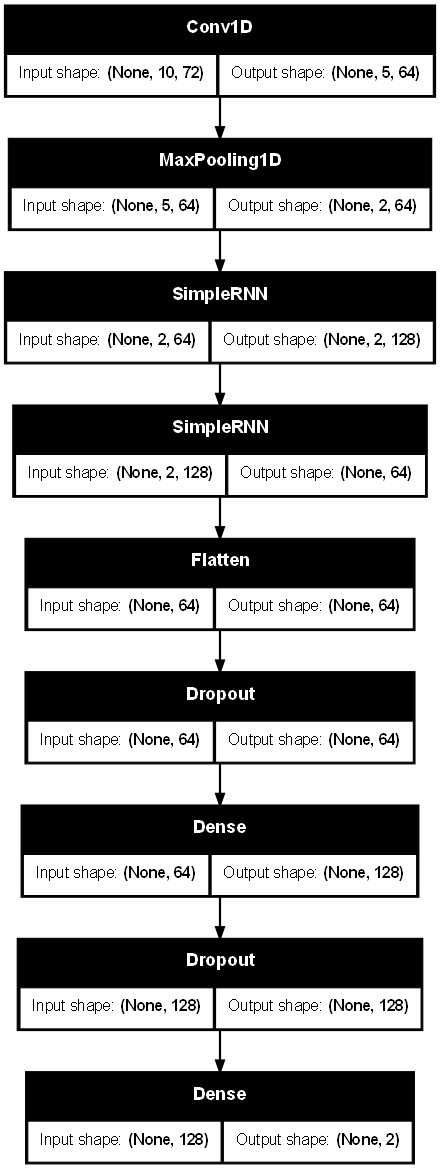

The ROP Model Classification Metrics:
Accuracy: 0.5253164556962026
Precision: 0.45147679324894513
Recall: 0.5253164556962026
F-Score: 0.42825231358366134
--------------------------------------------------------------


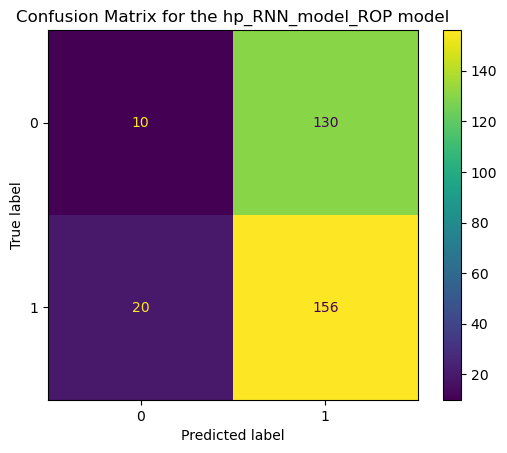

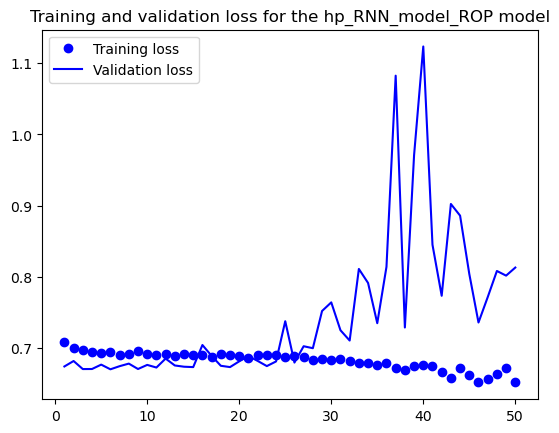

Model summary for the hp_RNN_model_XYL


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 5, 64)               │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 2, 64)               │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_17 (SimpleRNN)            │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 2, 128)              │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_18 (SimpleRNN)            │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 678,344 (2.59 MB)

 Trainable params: 226,114 (883.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 452,230 (1.73 MB)

Model plot for the hp_RNN_model_XYL


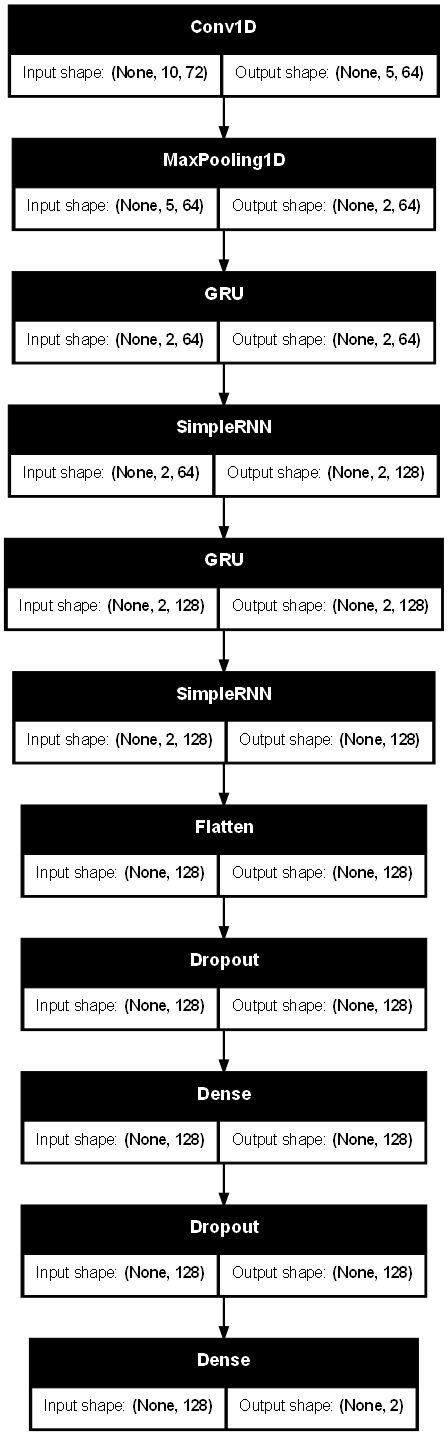

The XYL Model Classification Metrics:
Accuracy: 0.5603448275862069
Precision: 0.31398632580261593
Recall: 0.5603448275862069
F-Score: 0.4024576109735188
--------------------------------------------------------------


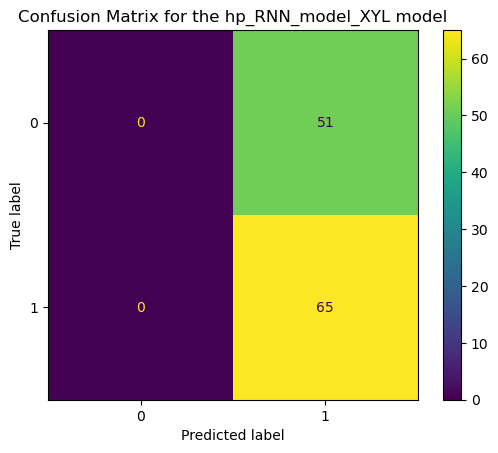

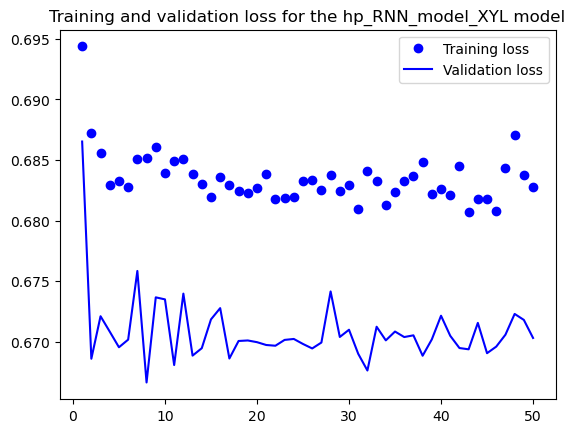

Model summary for the hp_RNN_model_CPAY


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 5, 64)               │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_19 (SimpleRNN)            │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_20 (SimpleRNN)            │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 220,040 (859.54 KB)

 Trainable params: 73,346 (286.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 146,694 (573.03 KB)

Model plot for the hp_RNN_model_CPAY


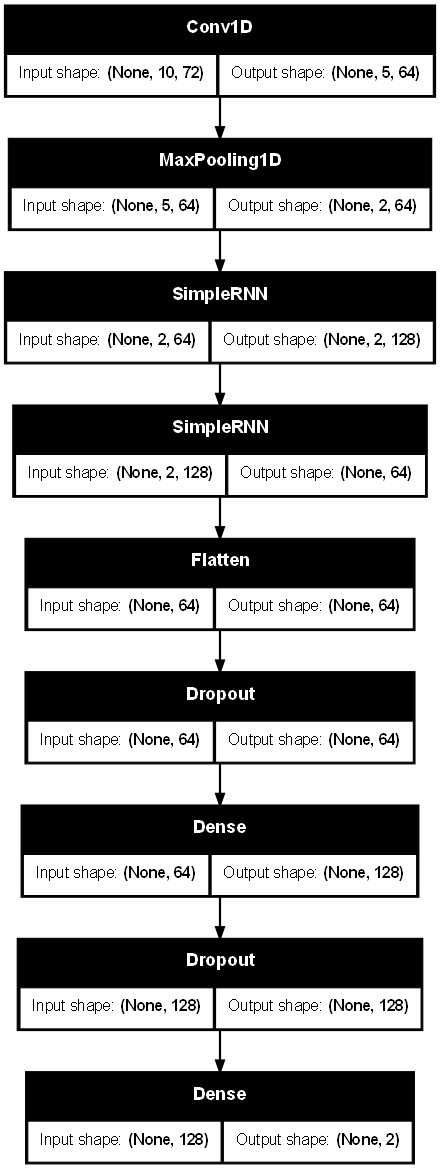

The CPAY Model Classification Metrics:
Accuracy: 0.544
Precision: 0.5402983870967741
Recall: 0.544
F-Score: 0.5150686294837237
--------------------------------------------------------------


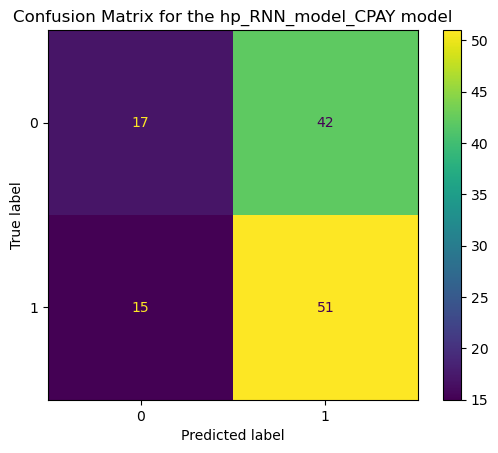

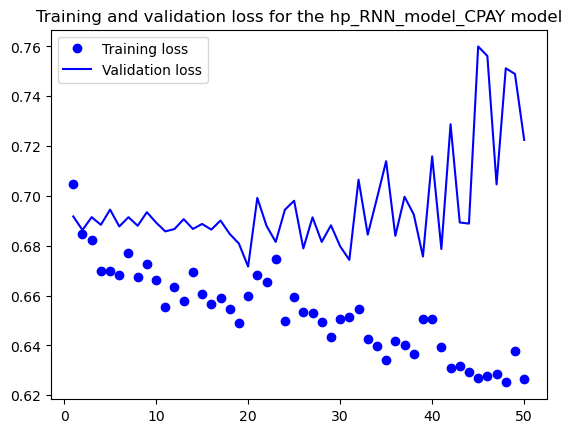

Model summary for the hp_RNN_model_INCY


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 5, 64)               │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_21 (SimpleRNN)            │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_22 (SimpleRNN)            │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 220,040 (859.54 KB)

 Trainable params: 73,346 (286.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 146,694 (573.03 KB)

Model plot for the hp_RNN_model_INCY


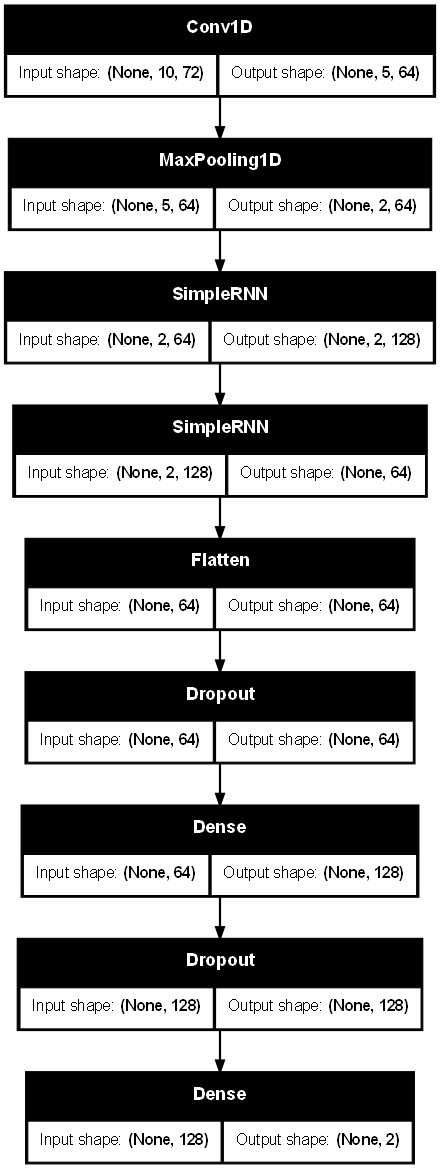

The INCY Model Classification Metrics:
Accuracy: 0.53156146179402
Precision: 0.5135050127446926
Recall: 0.53156146179402
F-Score: 0.49343481834527125
--------------------------------------------------------------


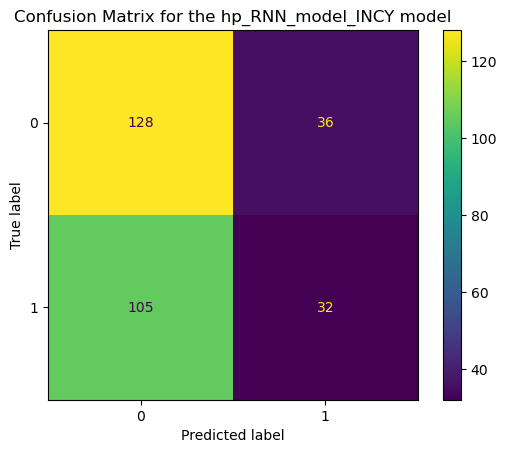

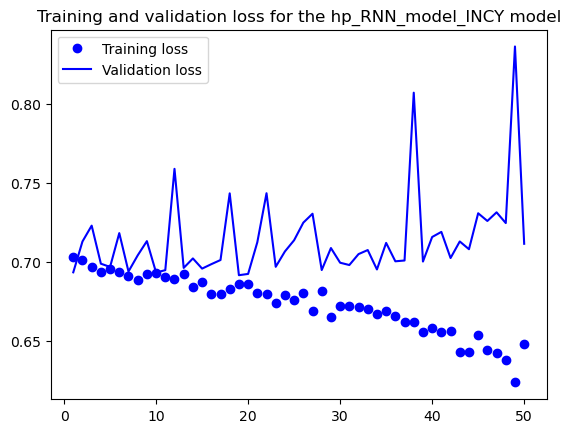

In [45]:
# evaluate the models in the archive
evaluate_models_archive(hp_RNN_conv_models_archive)

#### Enhancing the hyperparameter optimization approach with separable convolution
See HP_RNN_SC_Model(11)

In [46]:
# source of inspiration: Introduction to the Keras Tuner, https://www.tensorflow.org/tutorials/keras/keras_tuner [26]
# source of inspiration: François Chollet (11, 2017), “Deep Learning with Python”, chapters (7), hyperparameter optimization
# constuct the model which will perform hyperparameter optimization to choose layers count, neurons counts, recurrent_dropout, optimizer_type, optimizer learning rate
class HP_RNN_SC_Model(HyperModel):

    # initialize the model upon creating a class instance
    # using a class structure instead of a function to construct the model will allow us to pass variables to it before passing it to keras tuner
    # source of inspiration on how to pass variables to the model before passing the model to keras tuner: https://github.com/JulieProst/keras-tuner-tutorial/blob/master/hypermodels.py [33]
    def __init__(self, X_train_shape):
        self.X_train_shape = X_train_shape
    
    # build the model
    def build(self, hp):
        
        # initialize a sequential model
        model = Sequential()

        ### add the model layers (Model hyperparameters optimization)
        # input layer
        model.add(Input(shape=(self.X_train_shape[1], self.X_train_shape[2])))
        
        # add a SeparableConv1D layer at the beginning of the network, source of inspiration: François Chollet (11, 2017). “Deep Learning with Python” chapter 7
        model.add(SeparableConv1D(64, kernel_size=6, activation='relu'))
        model.add(MaxPooling1D(2))

        # source: Int method, https://keras.io/api/keras_tuner/hyperparameters/
        # dynamically optimize the number of layers
        hp_layers = hp.Int(name='hp_layers', 
                           min_value=2, 
                           max_value=4, 
                           step=2)

        # for each optimized layer
        for i in range(hp_layers):
            
            # optimize the layer type
            hp_layer_type = hp.Choice(f'RNN_layer_{i}_type', values=['SimpleRNN', 'LSTM', 'GRU'])
            if hp_layer_type == 'SimpleRNN':
                layer_type = SimpleRNN
            elif hp_layer_type == 'LSTM':
                layer_type = LSTM
            else:
                layer_type = GRU

            # dynamically tune the number of units in each layer, select a value between 64-128
            hp_units = hp.Int(name=f'hp_units_at_hp_layer_{i}', 
                              min_value=64, 
                              max_value=128, 
                              step=64)
            
            # source: SimpleRNN layer, https://keras.io/api/layers/recurrent_layers/simple_rnn/
            # return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.
            # set the return_sequences parameter to true unless it's the last layer, set it to false
            return_sequences_boolean = i != (hp_layers - 1)

            # source: Float method, https://keras.io/api/keras_tuner/hyperparameters/
            # source: SimpleRNN layer, https://keras.io/api/layers/recurrent_layers/simple_rnn/
            # recurrent_dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state.
            # dynamically tune the recurrent_dropout float value
            recurrent_dropout = hp.Float(name=f'recurrent_dropout_{i}', 
                                         min_value=0.0, 
                                         max_value=0.5, 
                                         step=0.1)

            # add a simpleRNN layer and pass the optimized number of unites, recurrent_dropout, and the return_sequences boolean
            layer = layer_type(units=hp_units, 
                               activation='relu',
                              return_sequences=return_sequences_boolean, 
                              recurrent_dropout=recurrent_dropout)
            model.add(layer)
        
        # add a flatting layer
        model.add(Flatten())
        
        # add a dropout layer
        model.add(Dropout(0.3))
        
        # add a dense layer
        model.add(Dense(128))
        
        # add a dropout layer
        model.add(Dropout(0.3))

        # add the output layer
        model.add(Dense(2, activation='softmax'))

        ### the model compiler (Algorithm hyperparameters optimization)
        # source: Choice method, https://keras.io/api/keras_tuner/hyperparameters/
        # dynamically optimize the optimizer type
        hp_optimizer_type = hp.Choice('optimizer_type', values=['Adam', 'RMSprop', 'SGD'])
        if hp_optimizer_type == 'Adam':
            optimizer = Adam
        elif hp_optimizer_type == 'RMSprop':
            optimizer = RMSprop
        else:
            optimizer = SGD

        # dynamically tune the learning rate for the optimizer
        # When sampling="log", the step is multiplied between samples.
        hp_lr = hp.Float('learning_rate', 
                         min_value=0.0001, 
                         max_value=0.01, 
                         sampling='LOG')
        hp_optimizer = optimizer(learning_rate=hp_lr)

        # compile the model
        model.compile(optimizer=hp_optimizer, 
                      loss='categorical_crossentropy', # this is the most suitable one for predictions of one-hot encoded labels
                      metrics=['accuracy'])

        # return the model
        return model
    
    # source: omalleyt12, https://github.com/keras-team/keras-tuner/issues/122 [34]
    # define a fit function which will allow us to pass an optimized value for batch_size
    # *args and **kwargs are the ones we pass through tuner.search()
    def fit(self, hp, model, *args, **kwargs):
        
        # dynamically optimize the batch_size for the training process
        hp_batch_size = hp.Choice("batch_size", [32, 64])
        return model.fit(
            *args,
            batch_size=hp_batch_size,
            **kwargs,
        )


In [ ]:
# set the model initialization inputs
X_train_shape = data_sets['PFE']['X_train'].shape
model_type='classification'
tuner = Hyperband

# create the model
hp_RNN_SC_model = HP_RNN_SC_Model(X_train_shape)

# create models archive for HP_RNNModel classification approach
hp_RNN_SC_models_archive = create_models_archive(hp_RNN_SC_model, 
                                                 data_sets, 
                                                 _model_type=model_type, 
                                                 _tuner=tuner, 
                                                 _epochs=50, 
                                                 _model_name='hp_RNN_model', 
                                                 _project_name='hp_RNN_models_archive_conv_flatten')

Model summary for the hp_RNN_model_PFE


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv1d (SeparableConv1D)   │ (None, 5, 64)               │           5,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_23 (SimpleRNN)            │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 2, 128)              │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_24 (SimpleRNN)            │ (None, 2, 64)               │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_25 (SimpleRNN)            │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 474,200 (1.81 MB)

 Trainable params: 158,066 (617.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 316,134 (1.21 MB)

Model plot for the hp_RNN_model_PFE


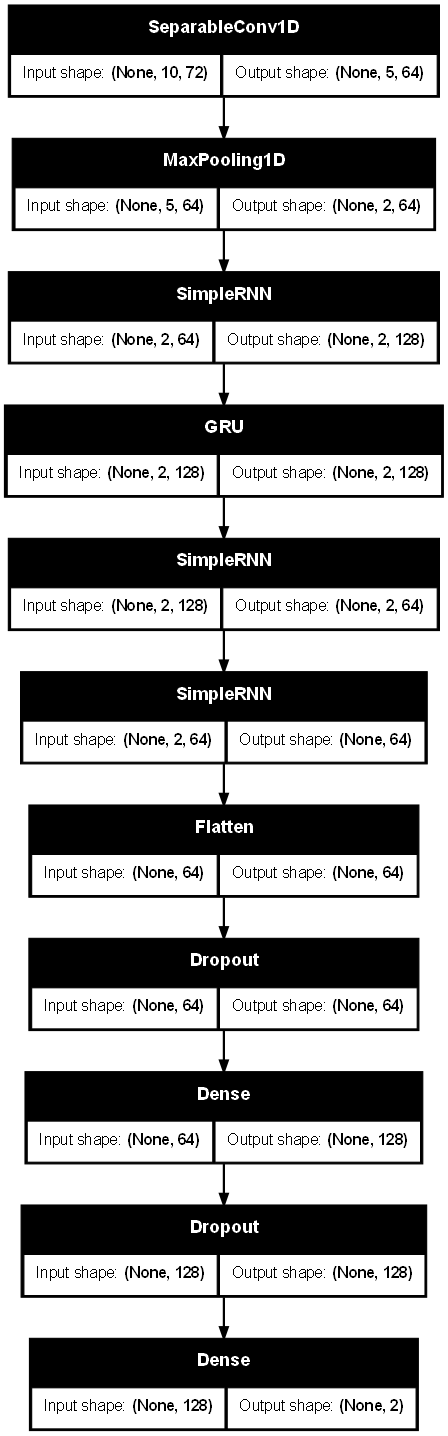

The PFE Model Classification Metrics:
Accuracy: 0.4980392156862745
Precision: 0.5078815840061515
Recall: 0.4980392156862745
F-Score: 0.4774849073934681
--------------------------------------------------------------


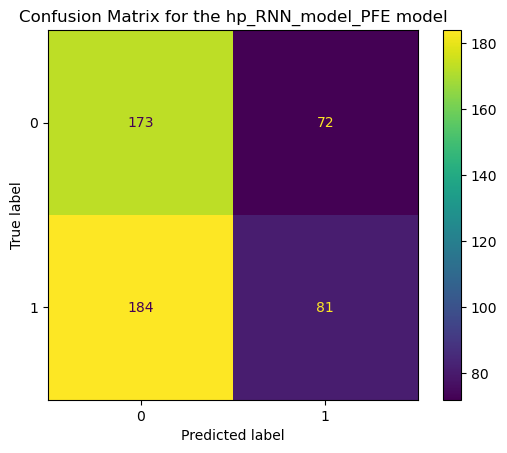

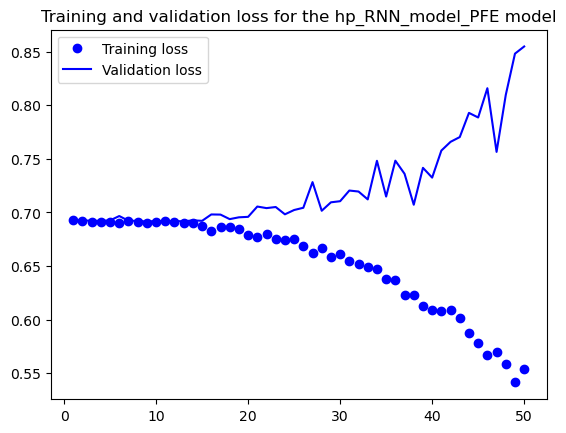

Model summary for the hp_RNN_model_ROP


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv1d_1 (SeparableConv1D) │ (None, 5, 64)               │           5,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 2, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_26 (SimpleRNN)            │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_27 (SimpleRNN)            │ (None, 2, 128)              │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_8 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 634,712 (2.42 MB)

 Trainable params: 211,570 (826.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 423,142 (1.61 MB)

Model plot for the hp_RNN_model_ROP


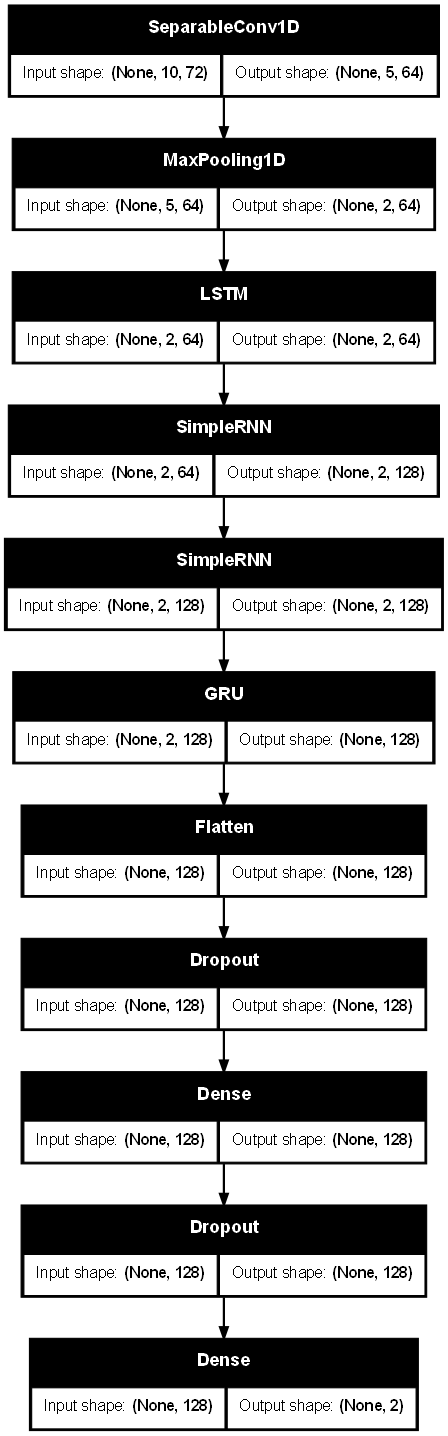

The ROP Model Classification Metrics:
Accuracy: 0.5506329113924051
Precision: 0.30863500765943724
Recall: 0.5506329113924051
F-Score: 0.39555670369413587
--------------------------------------------------------------


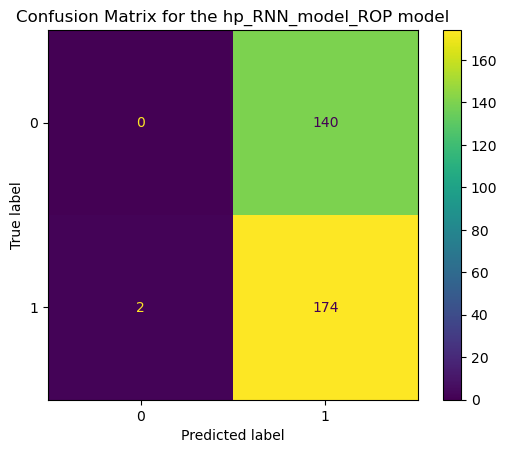

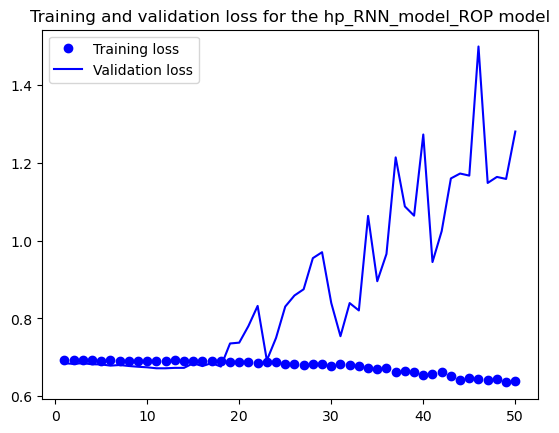

Model summary for the hp_RNN_model_XYL


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv1d_2 (SeparableConv1D) │ (None, 5, 64)               │           5,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 2, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_9 (GRU)                          │ (None, 2, 128)              │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_28 (SimpleRNN)            │ (None, 2, 64)               │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,158 (1.27 MB)

 Trainable params: 166,578 (650.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 166,580 (650.71 KB)

Model plot for the hp_RNN_model_XYL


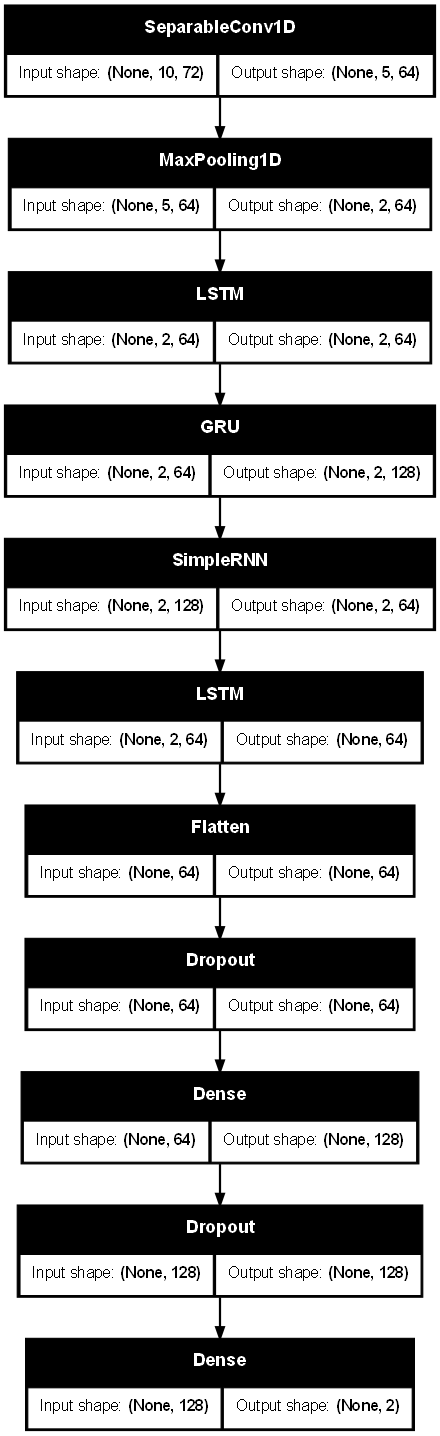

The XYL Model Classification Metrics:
Accuracy: 0.5603448275862069
Precision: 0.31398632580261593
Recall: 0.5603448275862069
F-Score: 0.4024576109735188
--------------------------------------------------------------


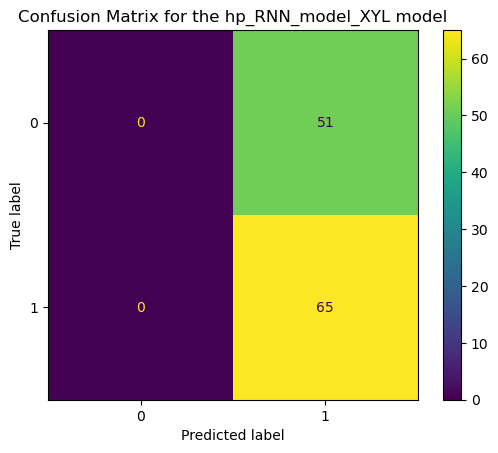

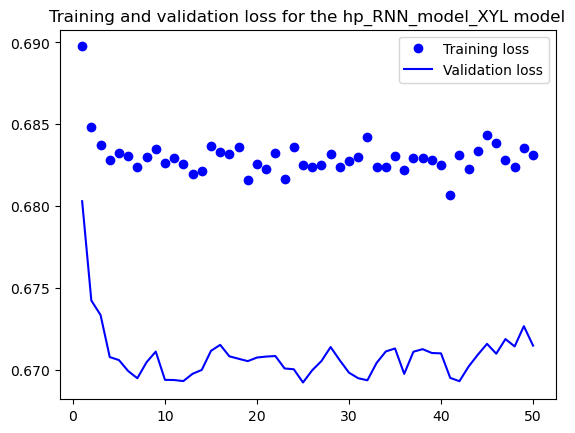

Model summary for the hp_RNN_model_CPAY


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv1d_3 (SeparableConv1D) │ (None, 5, 64)               │           5,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_10 (GRU)                         │ (None, 2, 64)               │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_29 (SimpleRNN)            │ (None, 128)                 │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 143,078 (558.90 KB)

 Trainable params: 71,538 (279.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 71,540 (279.46 KB)

Model plot for the hp_RNN_model_CPAY


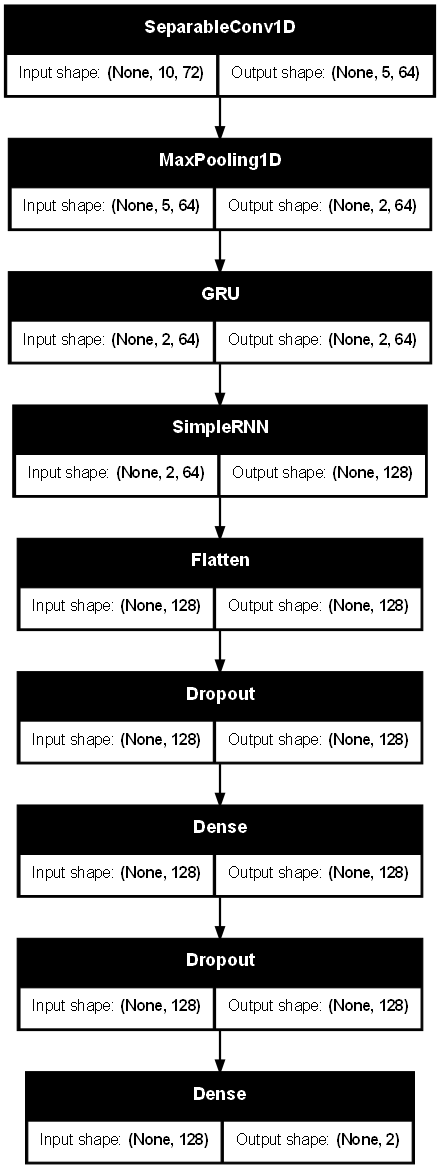

The CPAY Model Classification Metrics:
Accuracy: 0.544
Precision: 0.5678608695652174
Recall: 0.544
F-Score: 0.4438107134278165
--------------------------------------------------------------


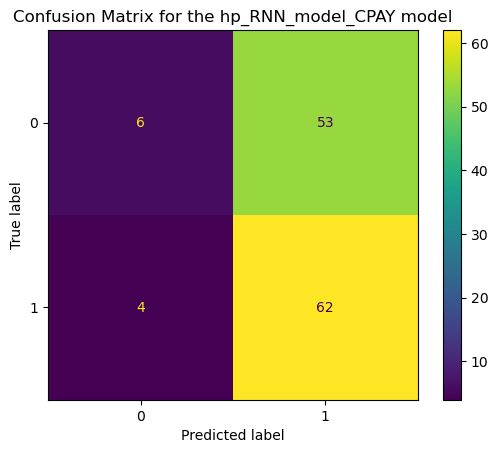

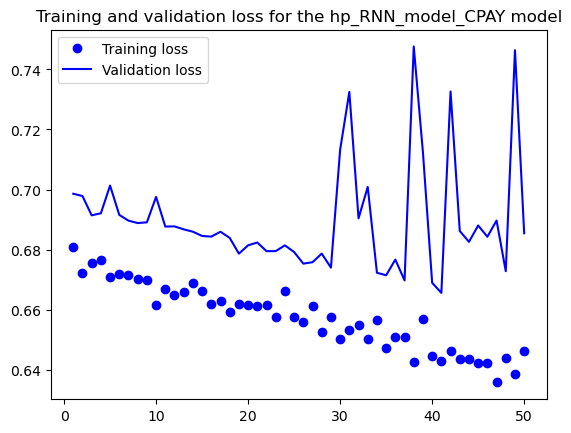

Model summary for the hp_RNN_model_INCY


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv1d_4 (SeparableConv1D) │ (None, 5, 64)               │           5,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_30 (SimpleRNN)            │ (None, 2, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_31 (SimpleRNN)            │ (None, 2, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_32 (SimpleRNN)            │ (None, 2, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 142,950 (558.40 KB)

 Trainable params: 71,474 (279.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 71,476 (279.21 KB)

Model plot for the hp_RNN_model_INCY


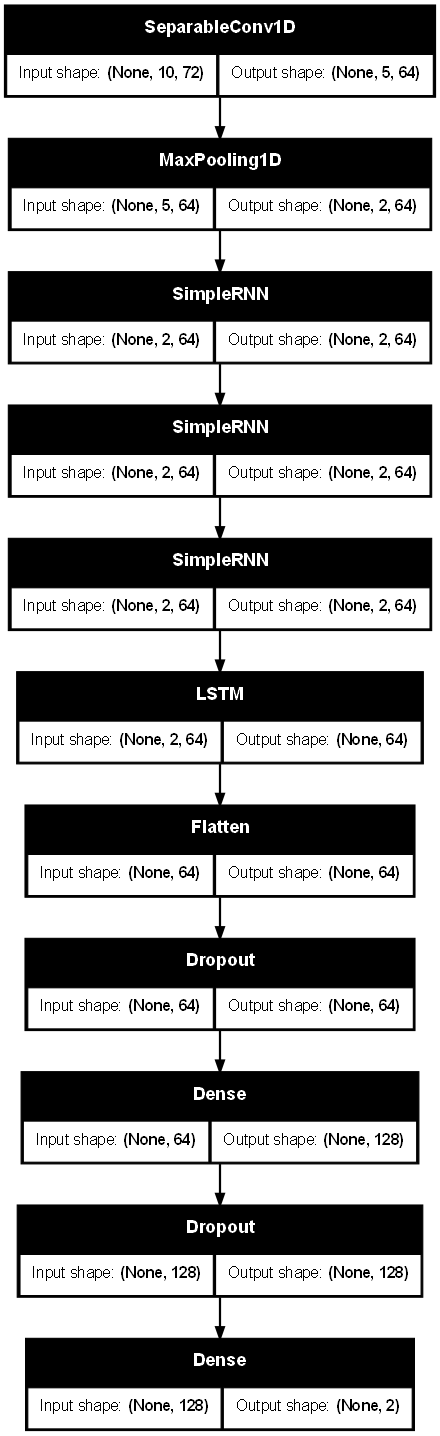

The INCY Model Classification Metrics:
Accuracy: 0.5647840531561462
Precision: 0.7580494397207049
Recall: 0.5647840531561462
F-Score: 0.4275428680353442
--------------------------------------------------------------


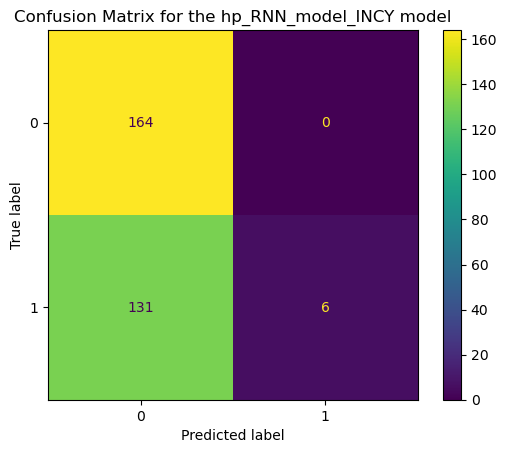

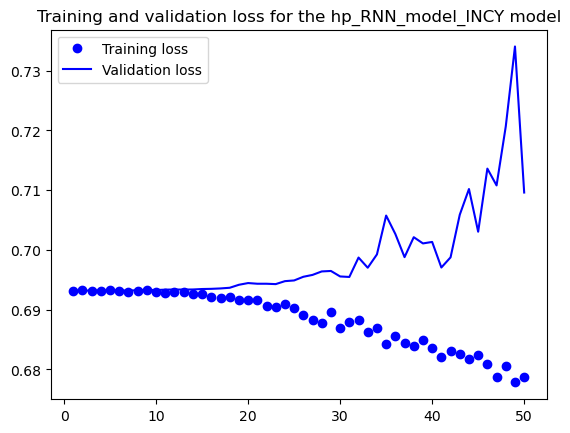

In [48]:
# evaluate the models in the archive
evaluate_models_archive(hp_RNN_SC_models_archive)

## Inception Model

Inception models are designed to process input data through multiple parallel branches. 
They help the network separately learn features from different groups, which is more efficient than learning them jointly. 

In my implementation: 
1. I created InputSplitLayer, a custom layer to divide the input features into 4 groups.
2. Each feature group is passed through a separate HP_Hollow_RNN_Branch class instance which is similar to the HP_RNN_SC_Model but without an output layer. 
3. These branches are then combined in the HP_Hollow_RNN_Inception_Model, which merges the outputs from all the different branches before passing them to the output layer. 

The hyperparameter optimization process within HP_Hollow_RNN_Branch ensures the best possible configurations for each branch in the inception model.

source: [36]

In [51]:
# source of inspiration: The base Layer class, "class ComputeSum(Layer)", https://keras.io/2.15/api/layers/base_layer/ [35]
# create a custom layer to split the features into groups (4 groups)
# TypeError: Could not locate class 'InputSpiltLayer'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()
@register_keras_serializable()
class InputSpiltLayer(Layer):
    def __init__(self, split_indices=[6, 36, 67, 72], **kwargs):
        super(InputSpiltLayer, self).__init__(**kwargs)
        
        # set the split indices
        self.split_indices = split_indices
    
    def call(self, inputs): # Defines the computation from inputs to outputs
        
        # initialize a list to store the input branches 
        data_set_branches = []
    
        # set the start index to be 0
        start_index = 0

        # iterates over the split_indices list
        for i in self.split_indices:
            
            # take a slice of the data features that is between the start index and the ith value in the split_indices
            branch = inputs[:, :, start_index:i]

            # add the slice to the data_set_branches list
            data_set_branches.append(branch)

            # update the start_index to be equal to the ith value in the split_indices
            start_index = i

        # return the data_set_branches
        return data_set_branches

class HP_Hollow_RNN_Branch(HyperModel):

    # initialize the model upon creating a class instance
    # using a class structure instead of a function to construct the model will allow us to pass variables to it before passing it to keras tuner
    # source of inspiration on how to pass variables to the model before passing the model to keras tuner: https://github.com/JulieProst/keras-tuner-tutorial/blob/master/hypermodels.py
    def __init__(self, _data_set_branch):
        self.data_set_branch = _data_set_branch
    
    # build the model
    def build(self, hp):

        layer = self.data_set_branch
        
        # add SeparableConv1D and max pooling layers
        layer = SeparableConv1D(64, kernel_size=6, activation='relu')(layer)
        layer = MaxPooling1D(2)(layer)
        
        # source: Int method, https://keras.io/api/keras_tuner/hyperparameters/
        # dynamically optimize the number of layers
        hp_layers = hp.Int(name=f'hp_layers', 
                           min_value=2, 
                           max_value=4, 
                           step=2)

        # for each optimized layer
        for i in range(hp_layers):

            # optimize the layer type
            hp_layer_type = hp.Choice(f'RNN_layer_{i}_type', values=['SimpleRNN', 'LSTM', 'GRU'])
            if hp_layer_type == 'SimpleRNN':
                layer_type = SimpleRNN
            elif hp_layer_type == 'LSTM':
                layer_type = LSTM
            else:
                layer_type = GRU
            
            # dynamically tune the number of units in each layer, select a value between 64-128
            hp_units = hp.Int(name=f'hp_units_at_hp_layer_{i}', 
                              min_value=64, 
                              max_value=128, 
                              step=64)

            # source: SimpleRNN layer, https://keras.io/api/layers/recurrent_layers/simple_rnn/
            # return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.
            # set the return_sequences parameter to true unless it's the last layer, set it to false
            return_sequences_boolean = i != (hp_layers - 1)

            # source: Float method, https://keras.io/api/keras_tuner/hyperparameters/
            # source: SimpleRNN layer, https://keras.io/api/layers/recurrent_layers/simple_rnn/
            # recurrent_dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state.
            # dynamically tune the recurrent_dropout float value
            recurrent_dropout = hp.Float(name=f'recurrent_dropout_{i}', 
                                         min_value=0.0, 
                                         max_value=0.5, 
                                         step=0.1)

            # add a simpleRNN layer and pass the optimized number of unites, recurrent_dropout, and the return_sequences boolean
            layer = layer_type(units=hp_units, 
                               activation='relu', 
                              return_sequences=return_sequences_boolean, 
                              recurrent_dropout=recurrent_dropout)(layer)
            
        # add flatten, dropout, and dense layers
        layer = Flatten()(layer)
        layer = Dropout(0.3)(layer)
        layer = Dense(128)(layer)
        layer = Dropout(0.3)(layer)
            
        # return the layers
        return layer

# source of inspiration: Introduction to the Keras Tuner, https://www.tensorflow.org/tutorials/keras/keras_tuner
# constuct the model which will perform hyperparameter optimization to choose layer type, layers count, neurons counts, recurrent_dropout, optimizer_type, optimizer learning rate
class HP_Hollow_RNN_Inception_Model(HyperModel):

    # initialize the model upon creating a class instance
    # using a class structure instead of a function to construct the model will allow us to pass variables to it before passing it to keras tuner
    # source of inspiration on how to pass variables to the model before passing the model to keras tuner: https://github.com/JulieProst/keras-tuner-tutorial/blob/master/hypermodels.py
    def __init__(self, X_train_shape):
        self.X_train_shape = X_train_shape
    
    # build the model
    def build(self, hp):        
        
        ### add the model layers (Model hyperparameters optimization)
        # input layer
        input_data = Input(shape=(self.X_train_shape[1], self.X_train_shape[2]))

        # create a branch of the model that will be trained on all the features
        all_features_branch = HP_Hollow_RNN_Branch(input_data).build(hp)
        
        # source of inspiration: deep learning with python, 7.1.4. Directed acyclic graphs of layers, Inception modules, https://www.manning.com/books/deep-learning-with-python
        data_set_branches = InputSpiltLayer([6, 36, 67, 72])(input_data)

        # create a branch that will be trained on the base features
        base_features_branch = HP_Hollow_RNN_Branch(data_set_branches[0]).build(hp)
        
        # create a branch that will be trained on the close price based features
        close_features_branch = HP_Hollow_RNN_Branch(data_set_branches[1]).build(hp)
        
        # create a branch that will be trained on the high and low price based features
        high_low_features_branch = HP_Hollow_RNN_Branch(data_set_branches[2]).build(hp)
        
        # create a branch that will be trained on the volume based features
        volume_features_branch = HP_Hollow_RNN_Branch(data_set_branches[3]).build(hp)

        # merge the branches
        branches_merged = concatenate([base_features_branch, 
                                       close_features_branch, 
                                       high_low_features_branch, 
                                       volume_features_branch, 
                                       all_features_branch], axis=-1)    
    
        # output layer
        output = Dense(2, activation='softmax')(branches_merged)

        # create the model
        model = Model(input_data, output)

        ### the model compiler (Algorithm hyperparameters optimization)
        # source: Choice method, https://keras.io/api/keras_tuner/hyperparameters/
        # dynamically optimize the optimizer type
        hp_optimizer_type = hp.Choice('optimizer_type', values=['Adam', 'RMSprop', 'SGD'])
        if hp_optimizer_type == 'Adam':
            optimizer = Adam
        elif hp_optimizer_type == 'RMSprop':
            optimizer = RMSprop
        else:
            optimizer = SGD

        # dynamically tune the learning rate for the optimizer
        # When sampling="log", the step is multiplied between samples.
        hp_lr = hp.Float('learning_rate', 
                         min_value=0.0001, 
                         max_value=0.01, 
                         sampling='LOG')
        hp_optimizer = optimizer(learning_rate=hp_lr)

        # compile the model
        model.compile(optimizer=hp_optimizer, 
                      loss='categorical_crossentropy', # this is the most suitable one for predictions of one-hot encoded labels
                      metrics=['accuracy'])

        # return the model
        return model
    
    # source: omalleyt12, https://github.com/keras-team/keras-tuner/issues/122
    # define a fit function which will allow us to pass an optimized value for batch_size
    # *args and **kwargs are the ones we pass through tuner.search()
    def fit(self, hp, model, *args, **kwargs):
        
        # dynamically optimize the batch_size for the training process
        hp_batch_size = hp.Choice("batch_size", [32, 64])
        return model.fit(
            *args,
            batch_size=hp_batch_size,
            **kwargs,
        )

In [ ]:
# set the model initialization inputs
X_train_shape = data_sets['PFE']['X_train'].shape
model_type='classification'
tuner = Hyperband

# create the model
hp_RNN_inception_model = HP_Hollow_RNN_Inception_Model(X_train_shape)
# hp_RNN_model = hp_RNN_model.build()

# create models archive for simpleRNN classification approach
hp_RNN_inception_models_archive = create_models_archive(hp_RNN_inception_model, 
                                                 data_sets, 
                                                 _model_type=model_type, 
                                                 _tuner=tuner, 
                                                 _epochs=50, 
                                                 _model_name='hp_RNN_inception_model', 
                                                 _project_name='hp_RNN_models_archive_conv_flatten')

Model summary for the hp_RNN_inception_model_PFE


Model: "functional_349"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)   │ (None, 10, 72)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_spilt_layer             │ [(None, 10, 6), (None,    │               0 │ input_layer_20[0][0]       │
│ (InputSpiltLayer)             │ 10, 30), (None, 10, 31),  │                 │                            │
│                               │ (None, 10, 5)]            │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_6            │ (None, 5, 64)             │             484 │ input_spilt_layer[0][0]    │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_7            │ (None, 5, 64)             │           2,164 │ input_spilt_layer[0][1]    │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_8            │ (None, 5, 64)             │           2,234 │ input_spilt_layer[0][2]    │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_9            │ (None, 5, 64)             │             414 │ input_spilt_layer[0][3]    │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_5            │ (None, 5, 64)             │           5,104 │ input_layer_20[0][0]       │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_11              │ (None, 2, 64)             │               0 │ separable_conv1d_6[0][0]   │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_12              │ (None, 2, 64)             │               0 │ separable_conv1d_7[0][0]   │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_13              │ (None, 2, 64)             │               0 │ separable_conv1d_8[0][0]   │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_14              │ (None, 2, 64)             │               0 │ separable_conv1d_9[0][0]   │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_10              │ (None, 2, 64)             │               

 Total params: 2,325,608 (8.87 MB)

 Trainable params: 775,202 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,550,406 (5.91 MB)

Model plot for the hp_RNN_inception_model_PFE


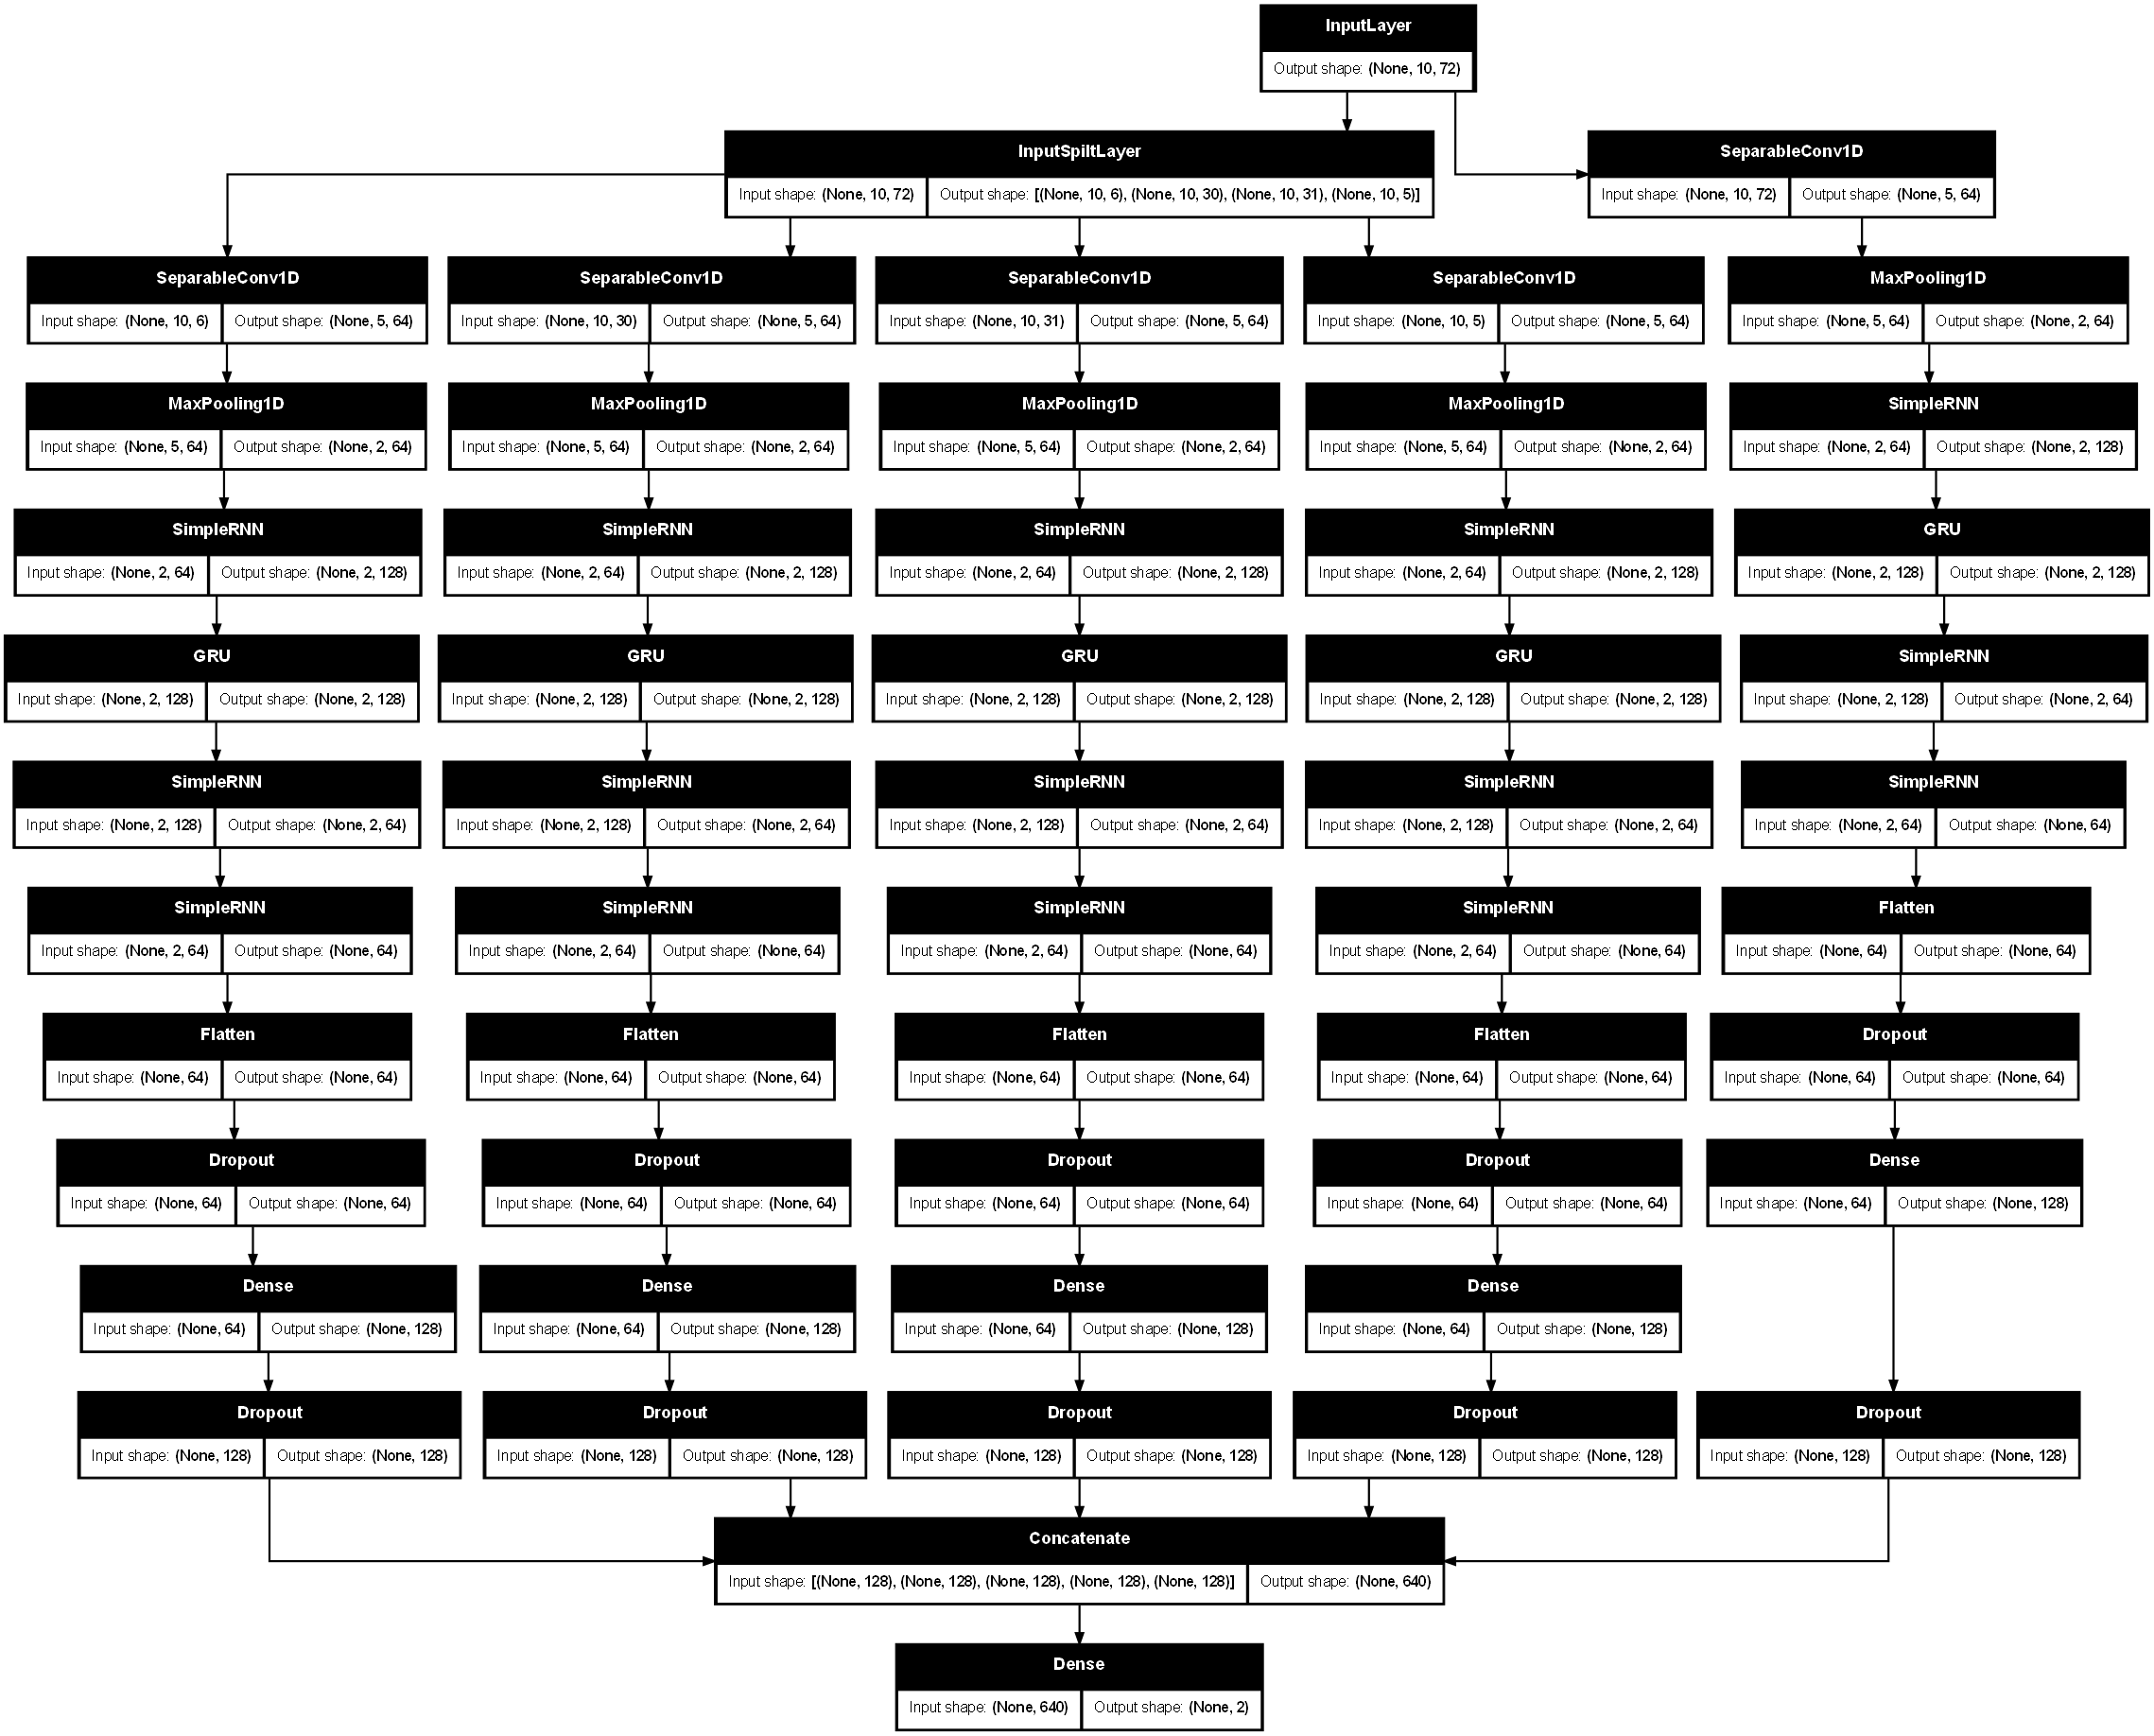

The PFE Model Classification Metrics:
Accuracy: 0.46862745098039216
Precision: 0.47183993918422984
Recall: 0.46862745098039216
F-Score: 0.43852649411663597
--------------------------------------------------------------


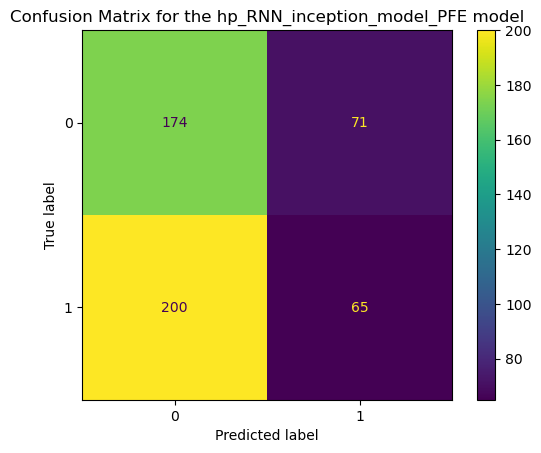

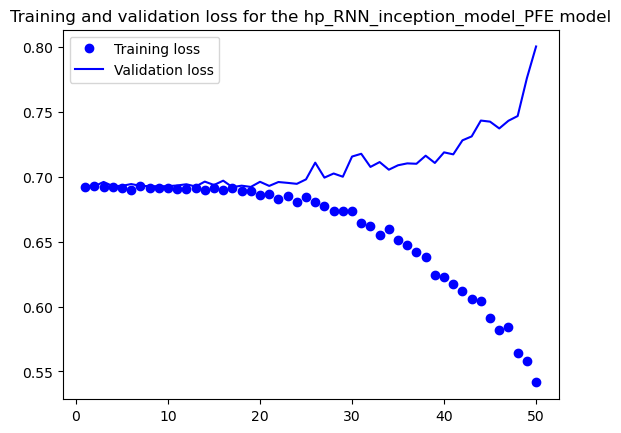

Model summary for the hp_RNN_inception_model_ROP


Model: "functional_351"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)   │ (None, 10, 72)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_spilt_layer_1           │ [(None, 10, 6), (None,    │               0 │ input_layer_21[0][0]       │
│ (InputSpiltLayer)             │ 10, 30), (None, 10, 31),  │                 │                            │
│                               │ (None, 10, 5)]            │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_11           │ (None, 5, 64)             │             484 │ input_spilt_layer_1[0][0]  │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_12           │ (None, 5, 64)             │           2,164 │ input_spilt_layer_1[0][1]  │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_13           │ (None, 5, 64)             │           2,234 │ input_spilt_layer_1[0][2]  │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_14           │ (None, 5, 64)             │             414 │ input_spilt_layer_1[0][3]  │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_10           │ (None, 5, 64)             │           5,104 │ input_layer_21[0][0]       │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_16              │ (None, 2, 64)             │               0 │ separable_conv1d_11[0][0]  │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_17              │ (None, 2, 64)             │               0 │ separable_conv1d_12[0][0]  │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_18              │ (None, 2, 64)             │               0 │ separable_conv1d_13[0][0]  │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_19              │ (None, 2, 64)             │               0 │ separable_conv1d_14[0][0]  │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_15              │ (None, 2, 64)             │               

 Total params: 2,325,608 (8.87 MB)

 Trainable params: 775,202 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,550,406 (5.91 MB)

Model plot for the hp_RNN_inception_model_ROP


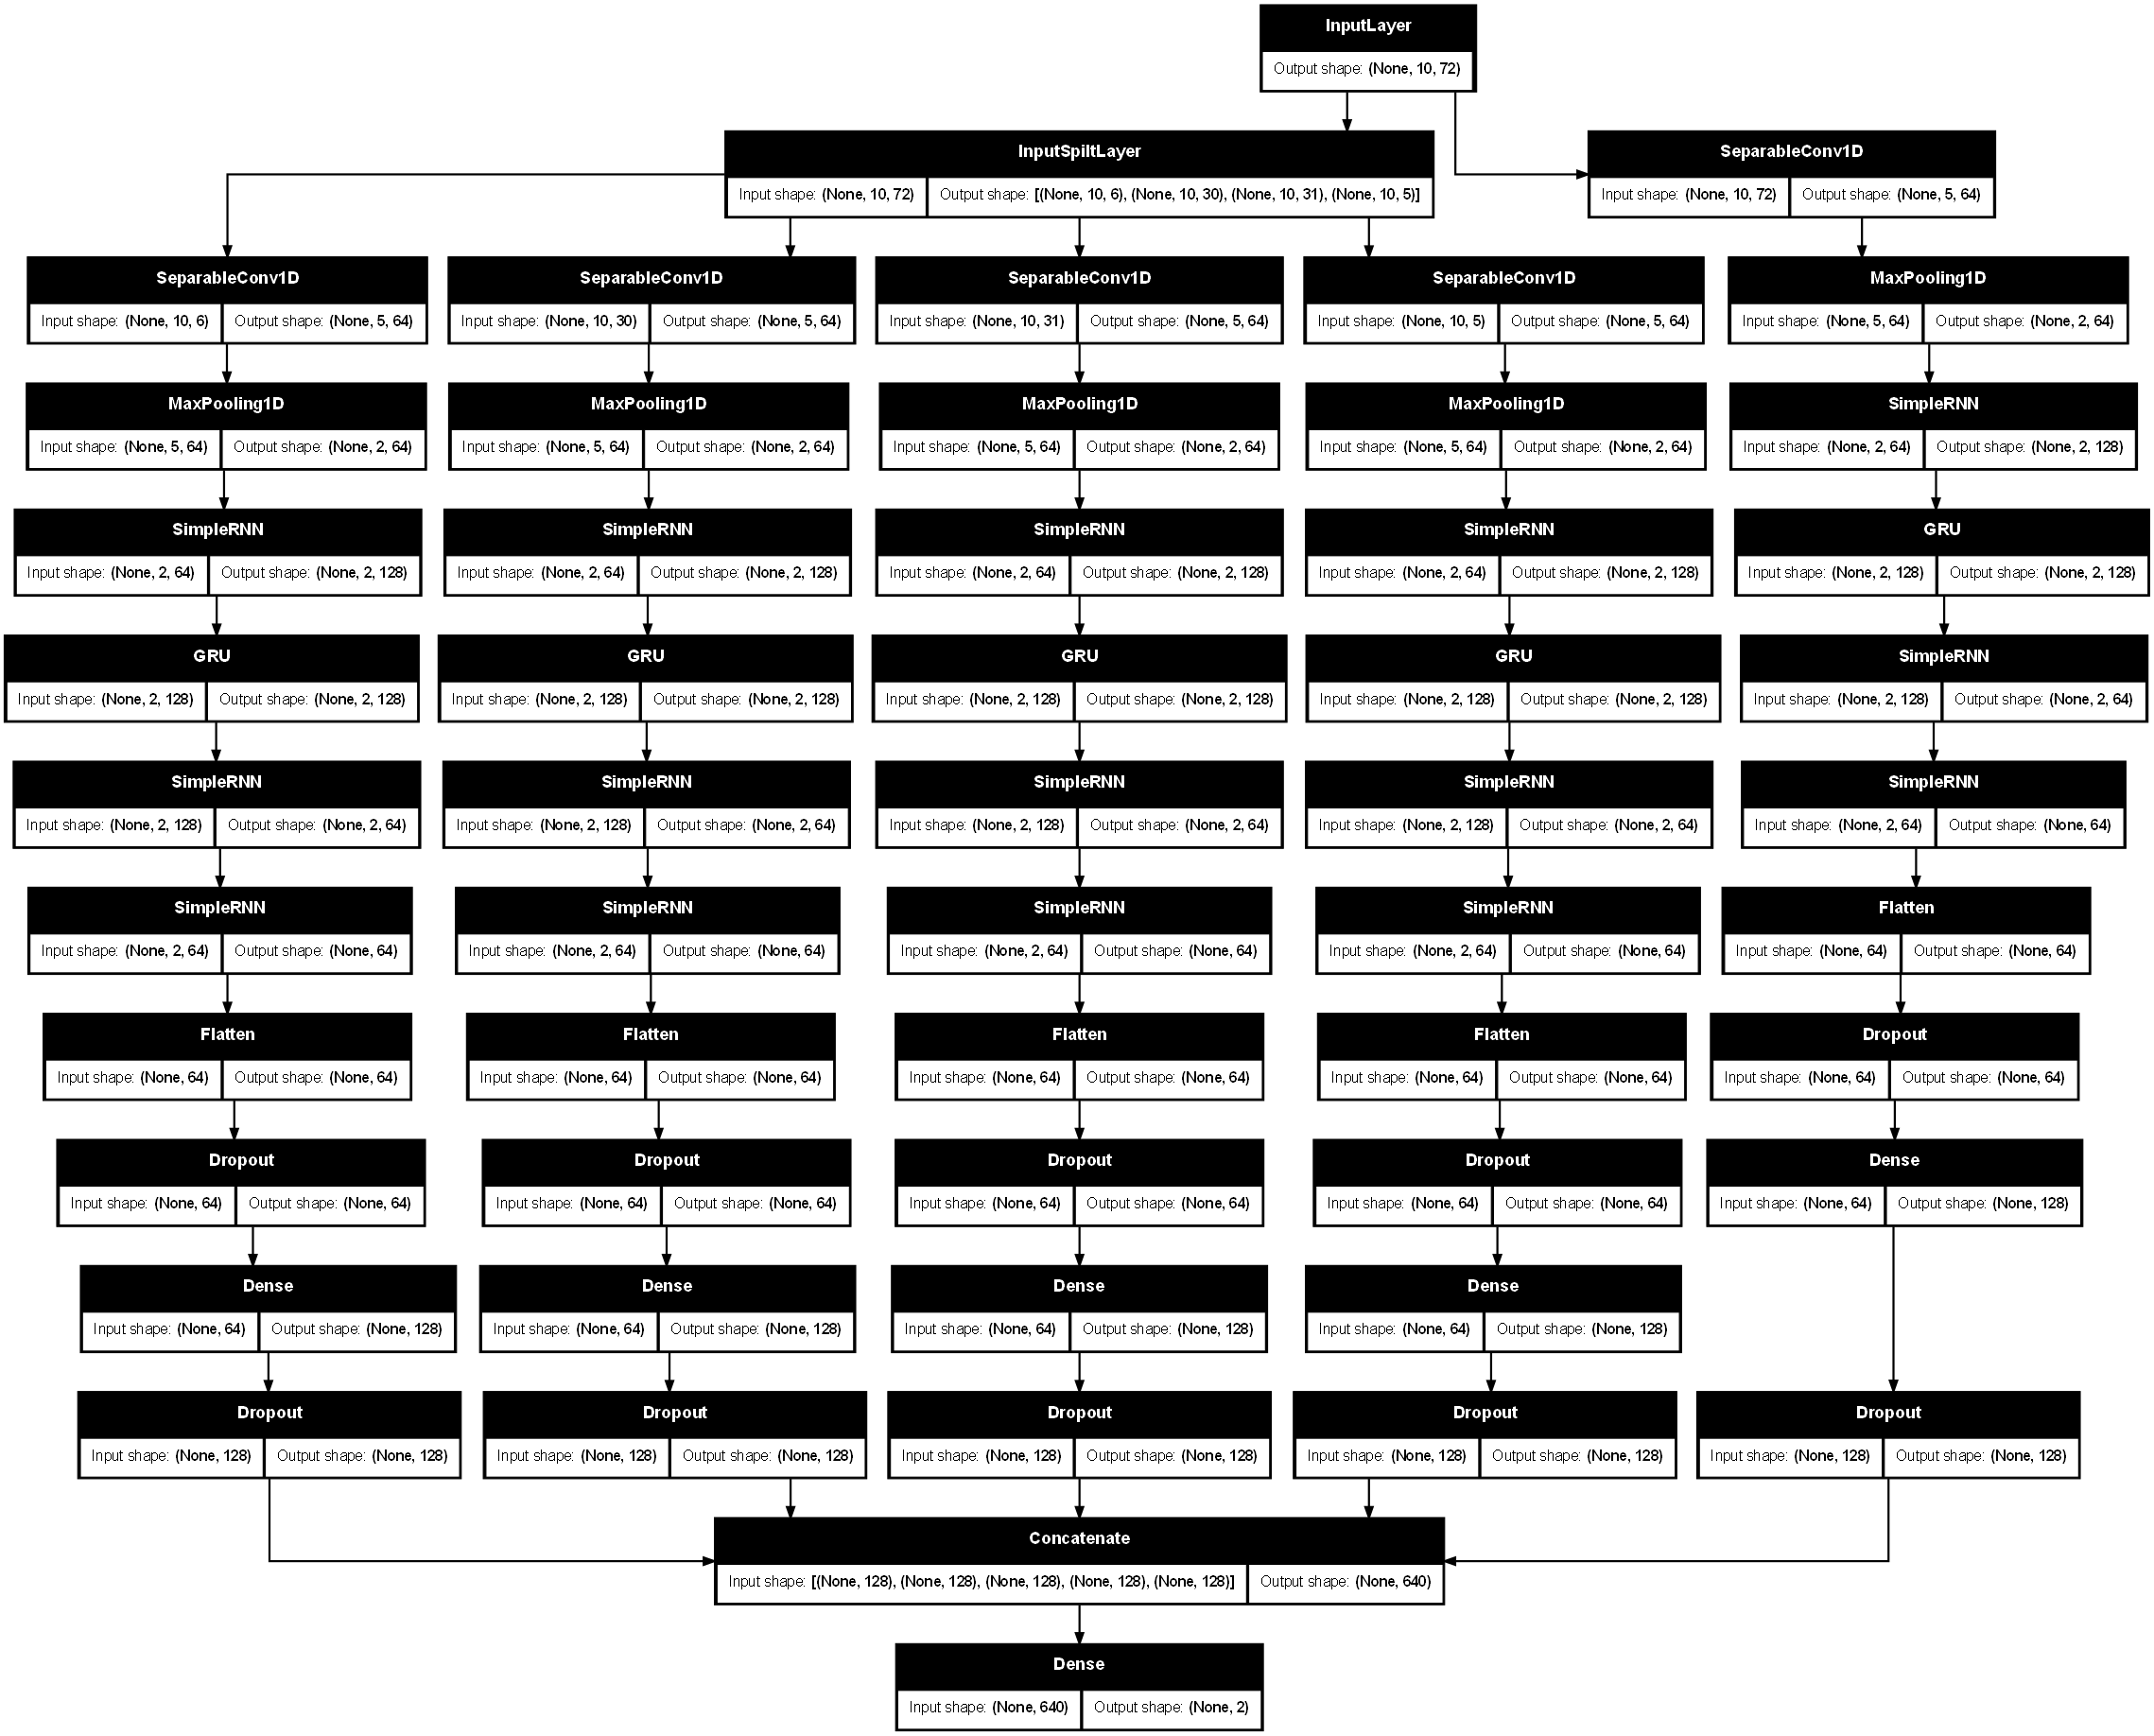

The ROP Model Classification Metrics:
Accuracy: 0.5569620253164557
Precision: 0.31020669764460823
Recall: 0.5569620253164557
F-Score: 0.39847689616136667
--------------------------------------------------------------


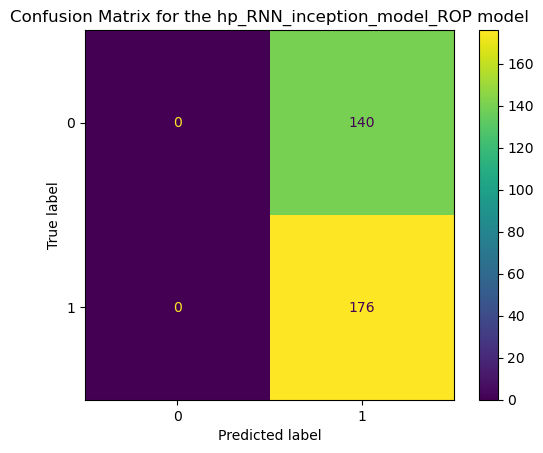

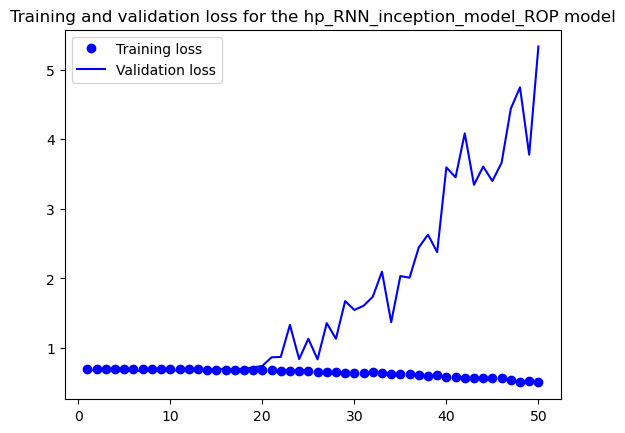

Model summary for the hp_RNN_inception_model_XYL


Model: "functional_353"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)   │ (None, 10, 72)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_spilt_layer_2           │ [(None, 10, 6), (None,    │               0 │ input_layer_22[0][0]       │
│ (InputSpiltLayer)             │ 10, 30), (None, 10, 31),  │                 │                            │
│                               │ (None, 10, 5)]            │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_16           │ (None, 5, 64)             │             484 │ input_spilt_layer_2[0][0]  │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_17           │ (None, 5, 64)             │           2,164 │ input_spilt_layer_2[0][1]  │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_18           │ (None, 5, 64)             │           2,234 │ input_spilt_layer_2[0][2]  │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_19           │ (None, 5, 64)             │             414 │ input_spilt_layer_2[0][3]  │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_15           │ (None, 5, 64)             │           5,104 │ input_layer_22[0][0]       │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_21              │ (None, 2, 64)             │               0 │ separable_conv1d_16[0][0]  │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_22              │ (None, 2, 64)             │               0 │ separable_conv1d_17[0][0]  │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_23              │ (None, 2, 64)             │               0 │ separable_conv1d_18[0][0]  │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_24              │ (None, 2, 64)             │               0 │ separable_conv1d_19[0][0]  │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_20              │ (None, 2, 64)             │               

 Total params: 3,007,208 (11.47 MB)

 Trainable params: 1,002,402 (3.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,004,806 (7.65 MB)

Model plot for the hp_RNN_inception_model_XYL


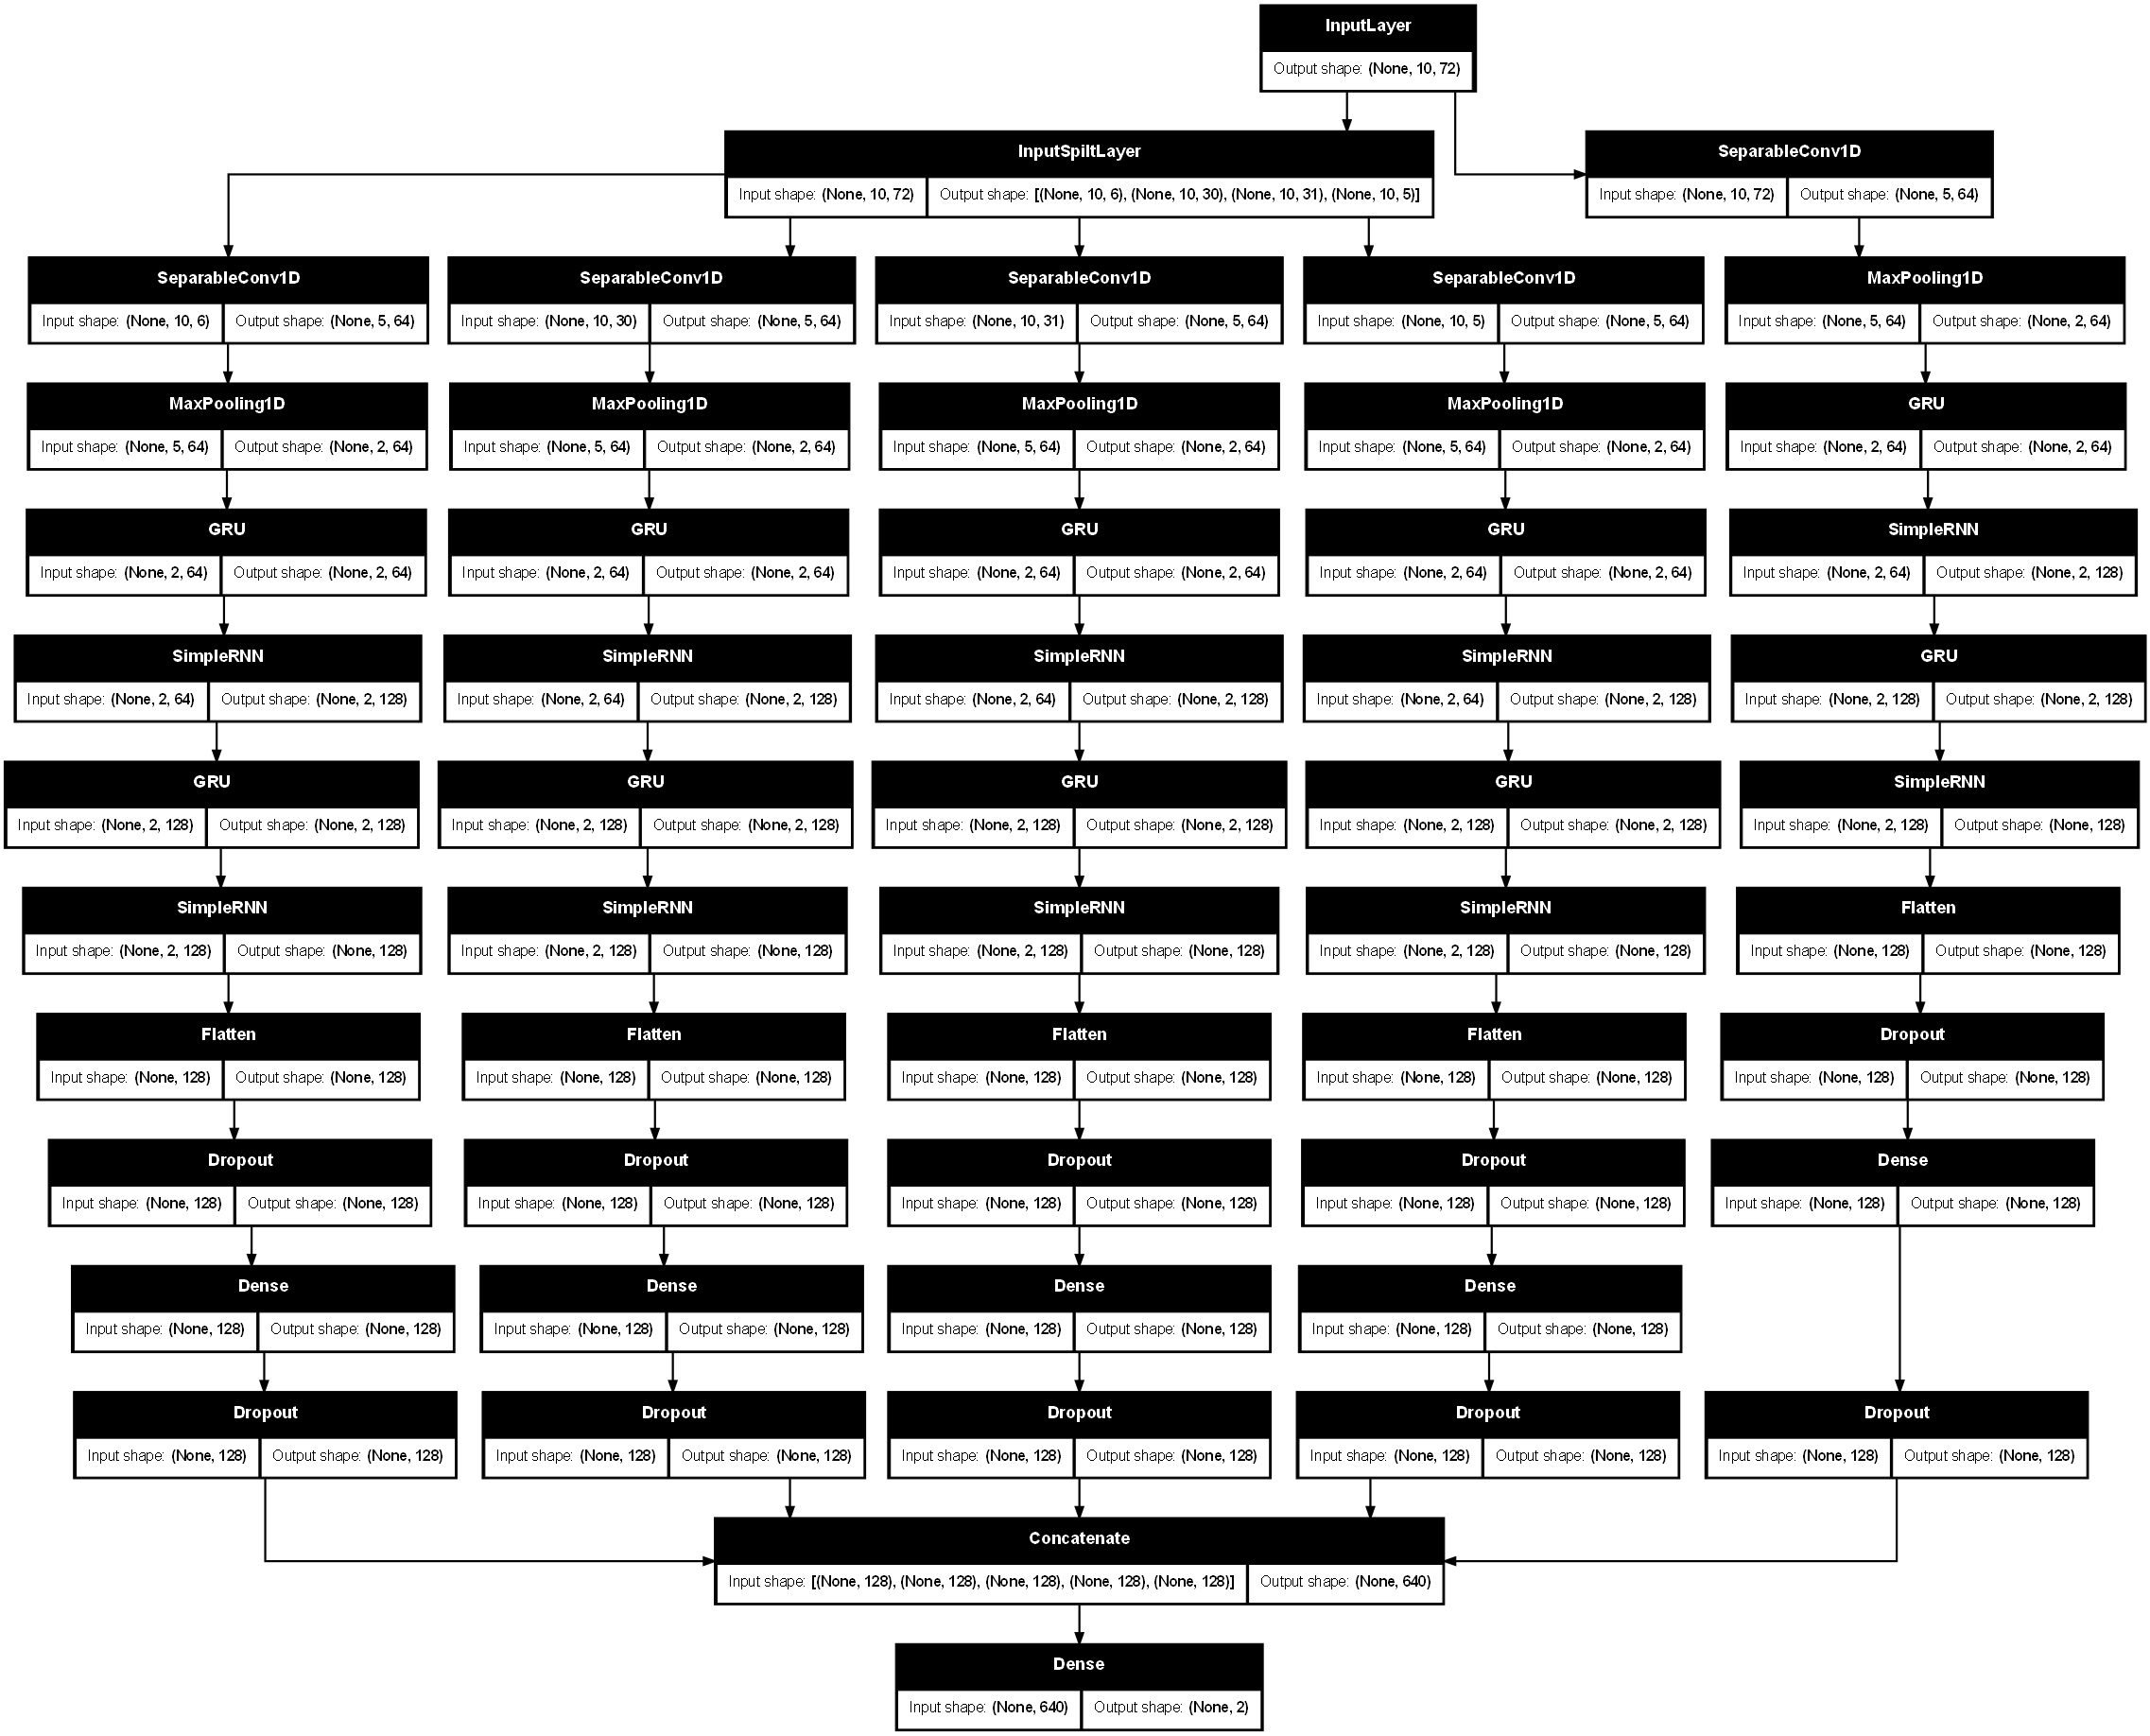

The XYL Model Classification Metrics:
Accuracy: 0.5603448275862069
Precision: 0.31398632580261593
Recall: 0.5603448275862069
F-Score: 0.4024576109735188
--------------------------------------------------------------


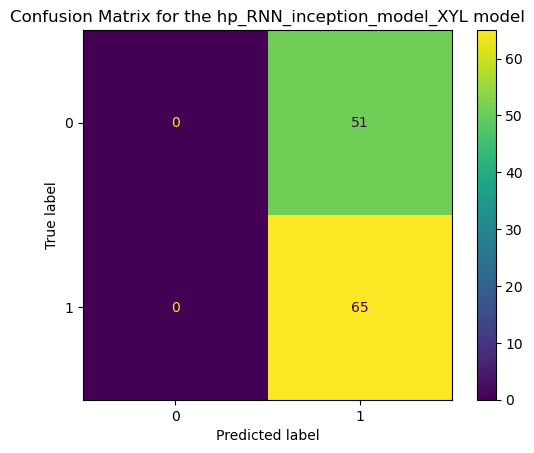

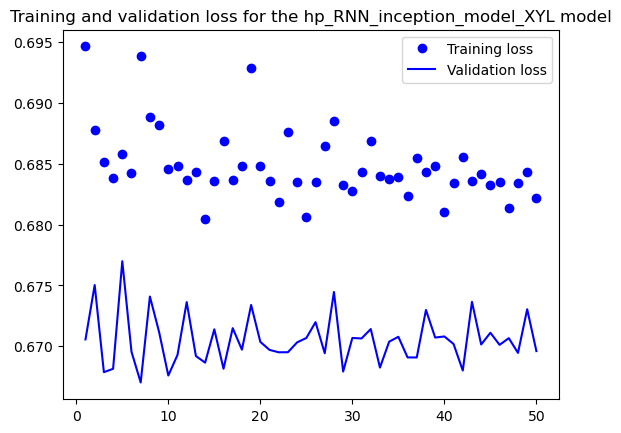

Model summary for the hp_RNN_inception_model_CPAY


Model: "functional_355"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)   │ (None, 10, 72)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_spilt_layer_3           │ [(None, 10, 6), (None,    │               0 │ input_layer_23[0][0]       │
│ (InputSpiltLayer)             │ 10, 30), (None, 10, 31),  │                 │                            │
│                               │ (None, 10, 5)]            │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_21           │ (None, 5, 64)             │             484 │ input_spilt_layer_3[0][0]  │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_22           │ (None, 5, 64)             │           2,164 │ input_spilt_layer_3[0][1]  │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_23           │ (None, 5, 64)             │           2,234 │ input_spilt_layer_3[0][2]  │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_24           │ (None, 5, 64)             │             414 │ input_spilt_layer_3[0][3]  │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_20           │ (None, 5, 64)             │           5,104 │ input_layer_23[0][0]       │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_26              │ (None, 2, 64)             │               0 │ separable_conv1d_21[0][0]  │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_27              │ (None, 2, 64)             │               0 │ separable_conv1d_22[0][0]  │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_28              │ (None, 2, 64)             │               0 │ separable_conv1d_23[0][0]  │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_29              │ (None, 2, 64)             │               0 │ separable_conv1d_24[0][0]  │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_25              │ (None, 2, 64)             │               

 Total params: 3,007,208 (11.47 MB)

 Trainable params: 1,002,402 (3.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,004,806 (7.65 MB)

Model plot for the hp_RNN_inception_model_CPAY


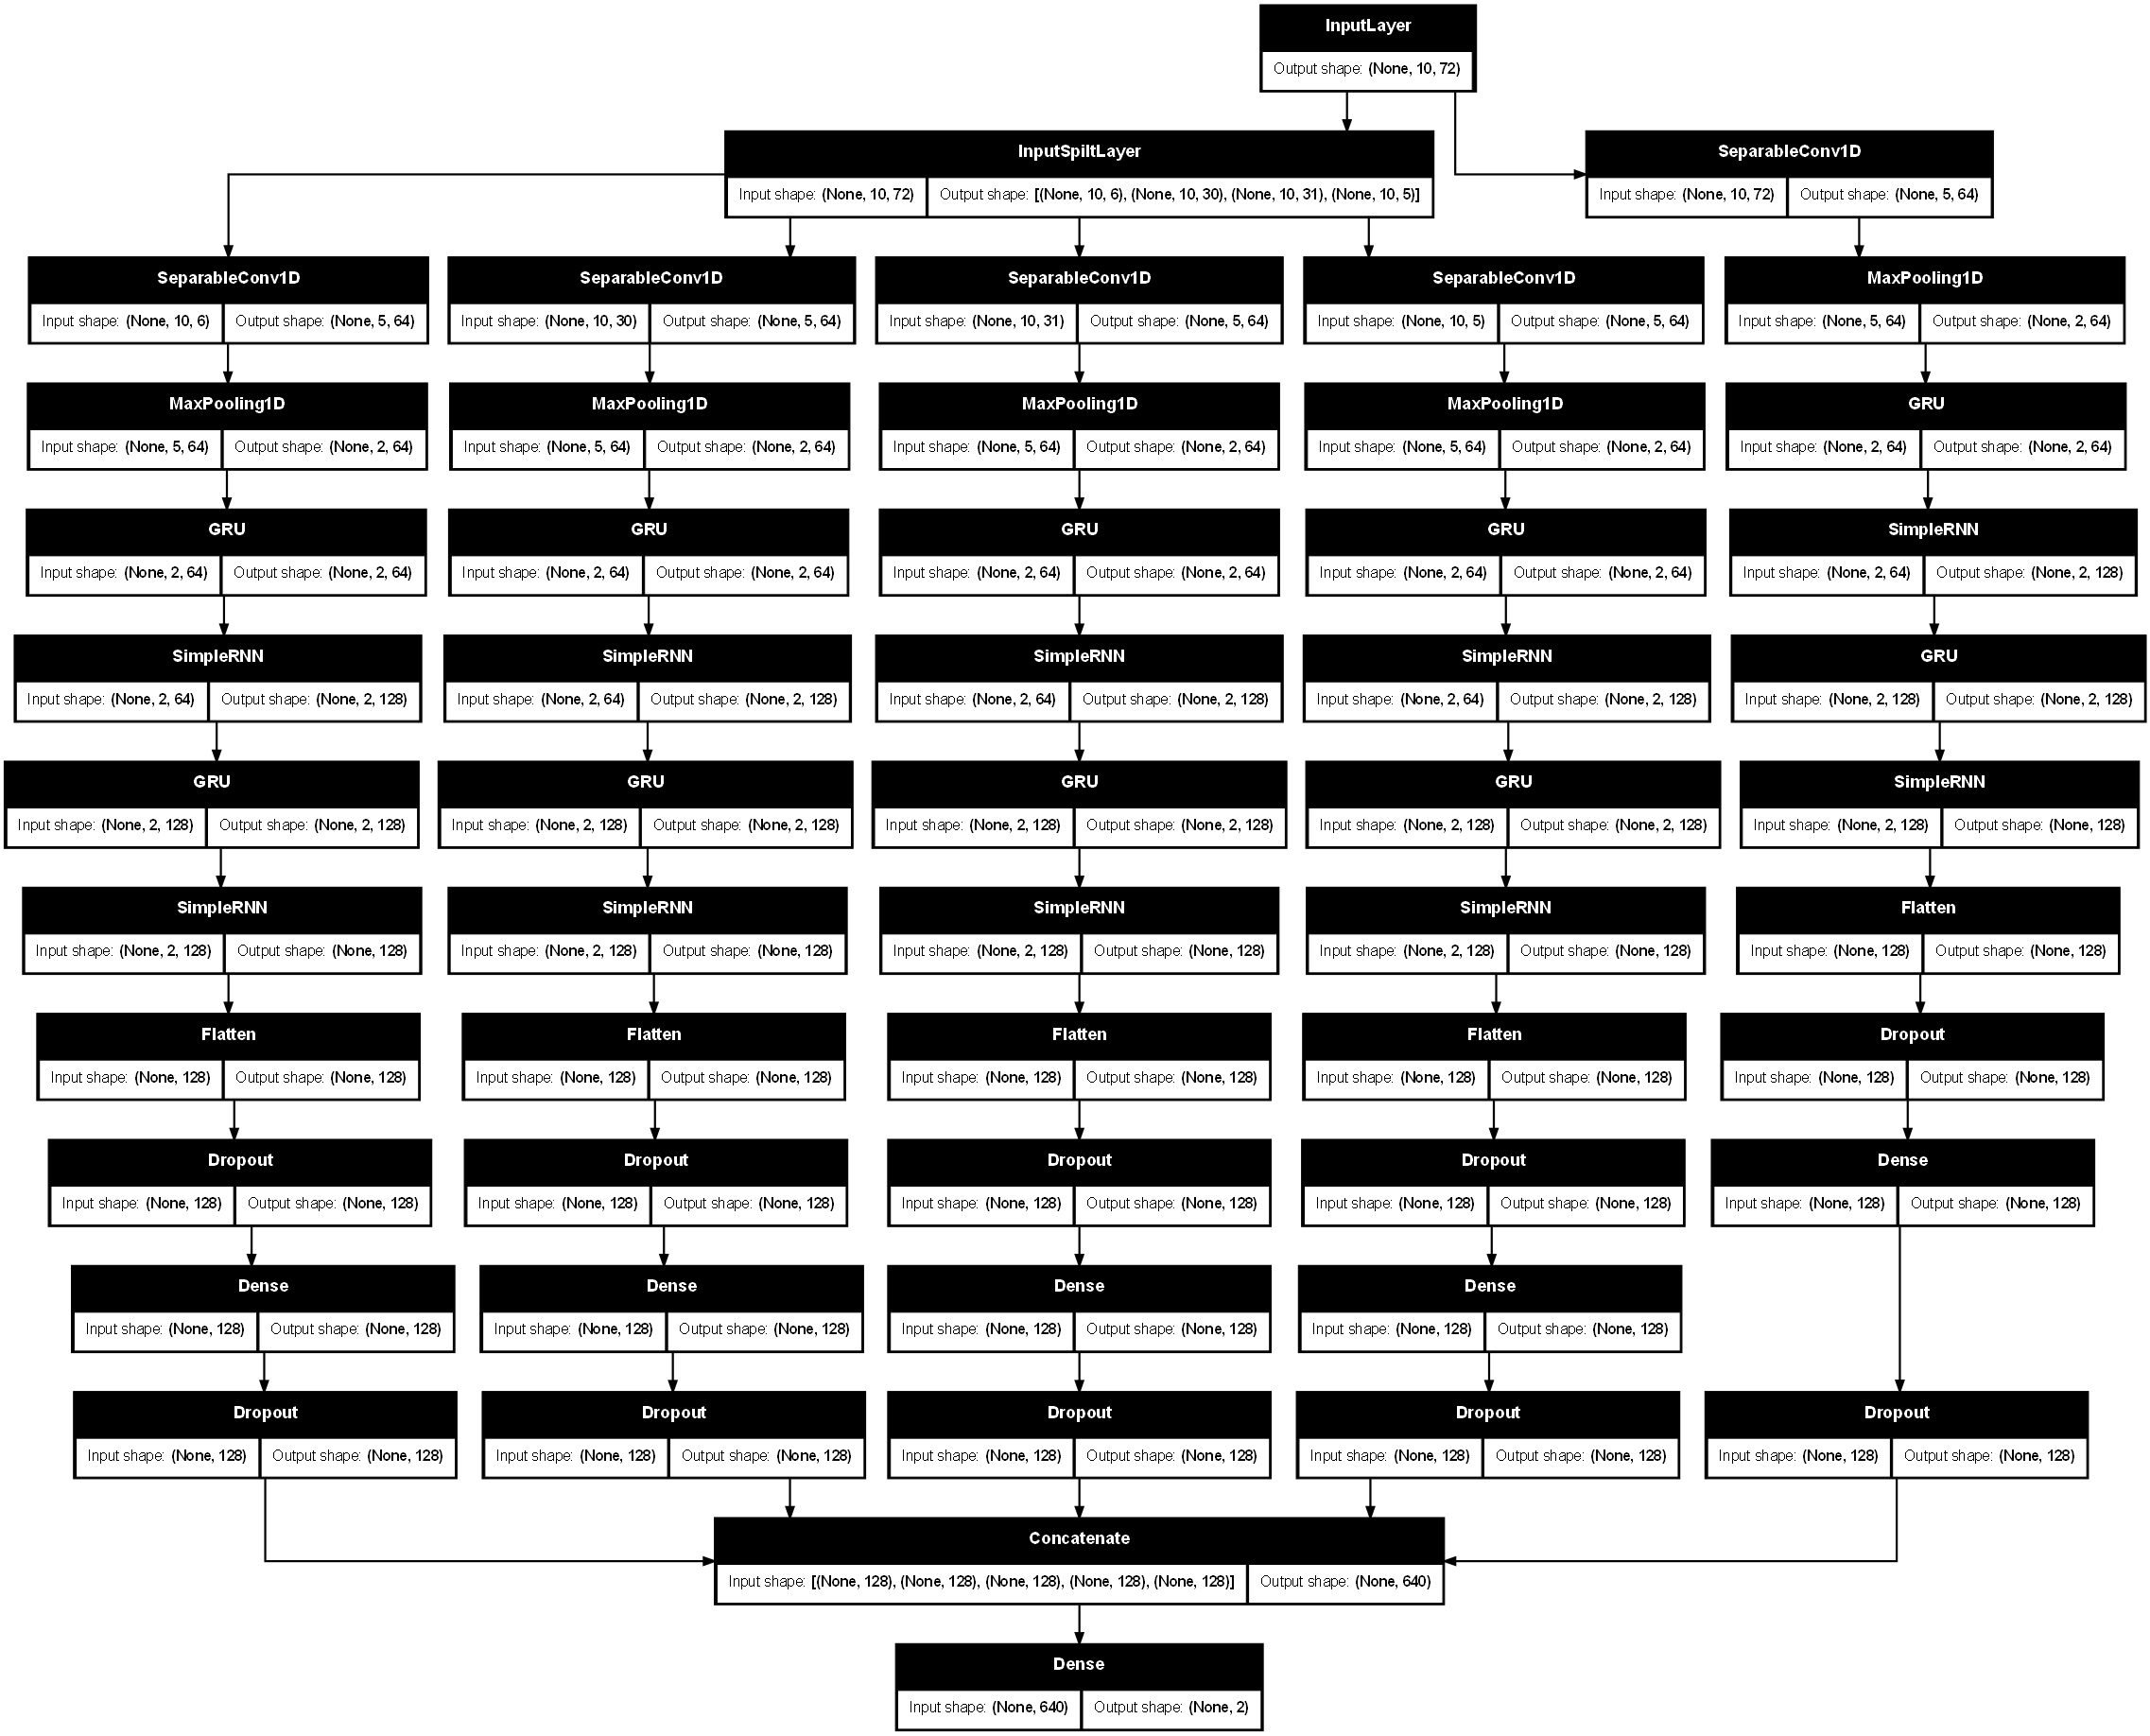

The CPAY Model Classification Metrics:
Accuracy: 0.528
Precision: 0.278784
Recall: 0.528
F-Score: 0.3649005235602094
--------------------------------------------------------------


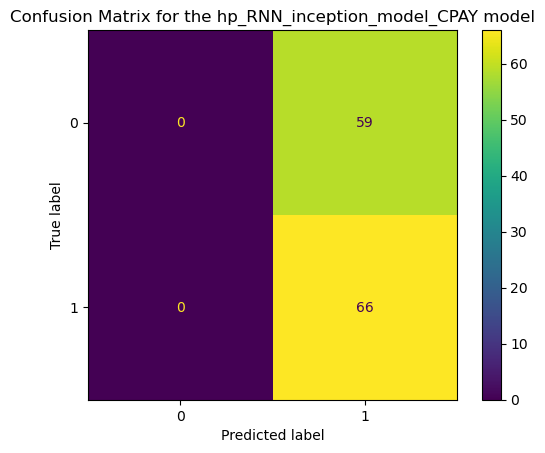

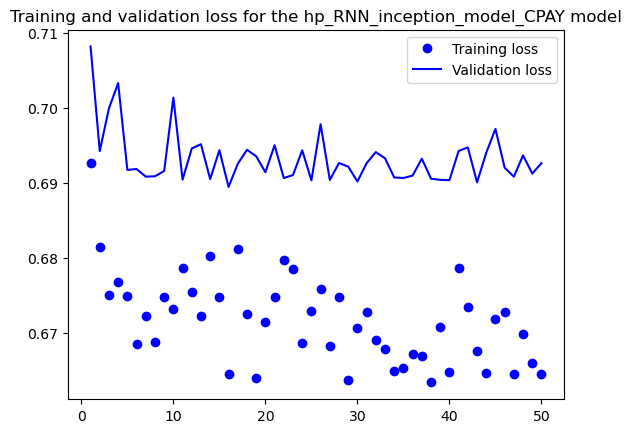

Model summary for the hp_RNN_inception_model_INCY


Model: "functional_357"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)   │ (None, 10, 72)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_spilt_layer_4           │ [(None, 10, 6), (None,    │               0 │ input_layer_24[0][0]       │
│ (InputSpiltLayer)             │ 10, 30), (None, 10, 31),  │                 │                            │
│                               │ (None, 10, 5)]            │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_26           │ (None, 5, 64)             │             484 │ input_spilt_layer_4[0][0]  │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_27           │ (None, 5, 64)             │           2,164 │ input_spilt_layer_4[0][1]  │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_28           │ (None, 5, 64)             │           2,234 │ input_spilt_layer_4[0][2]  │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_29           │ (None, 5, 64)             │             414 │ input_spilt_layer_4[0][3]  │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv1d_25           │ (None, 5, 64)             │           5,104 │ input_layer_24[0][0]       │
│ (SeparableConv1D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_31              │ (None, 2, 64)             │               0 │ separable_conv1d_26[0][0]  │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_32              │ (None, 2, 64)             │               0 │ separable_conv1d_27[0][0]  │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_33              │ (None, 2, 64)             │               0 │ separable_conv1d_28[0][0]  │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_34              │ (None, 2, 64)             │               0 │ separable_conv1d_29[0][0]  │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_30              │ (None, 2, 64)             │               

 Total params: 684,486 (2.61 MB)

 Trainable params: 342,242 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 342,244 (1.31 MB)

Model plot for the hp_RNN_inception_model_INCY


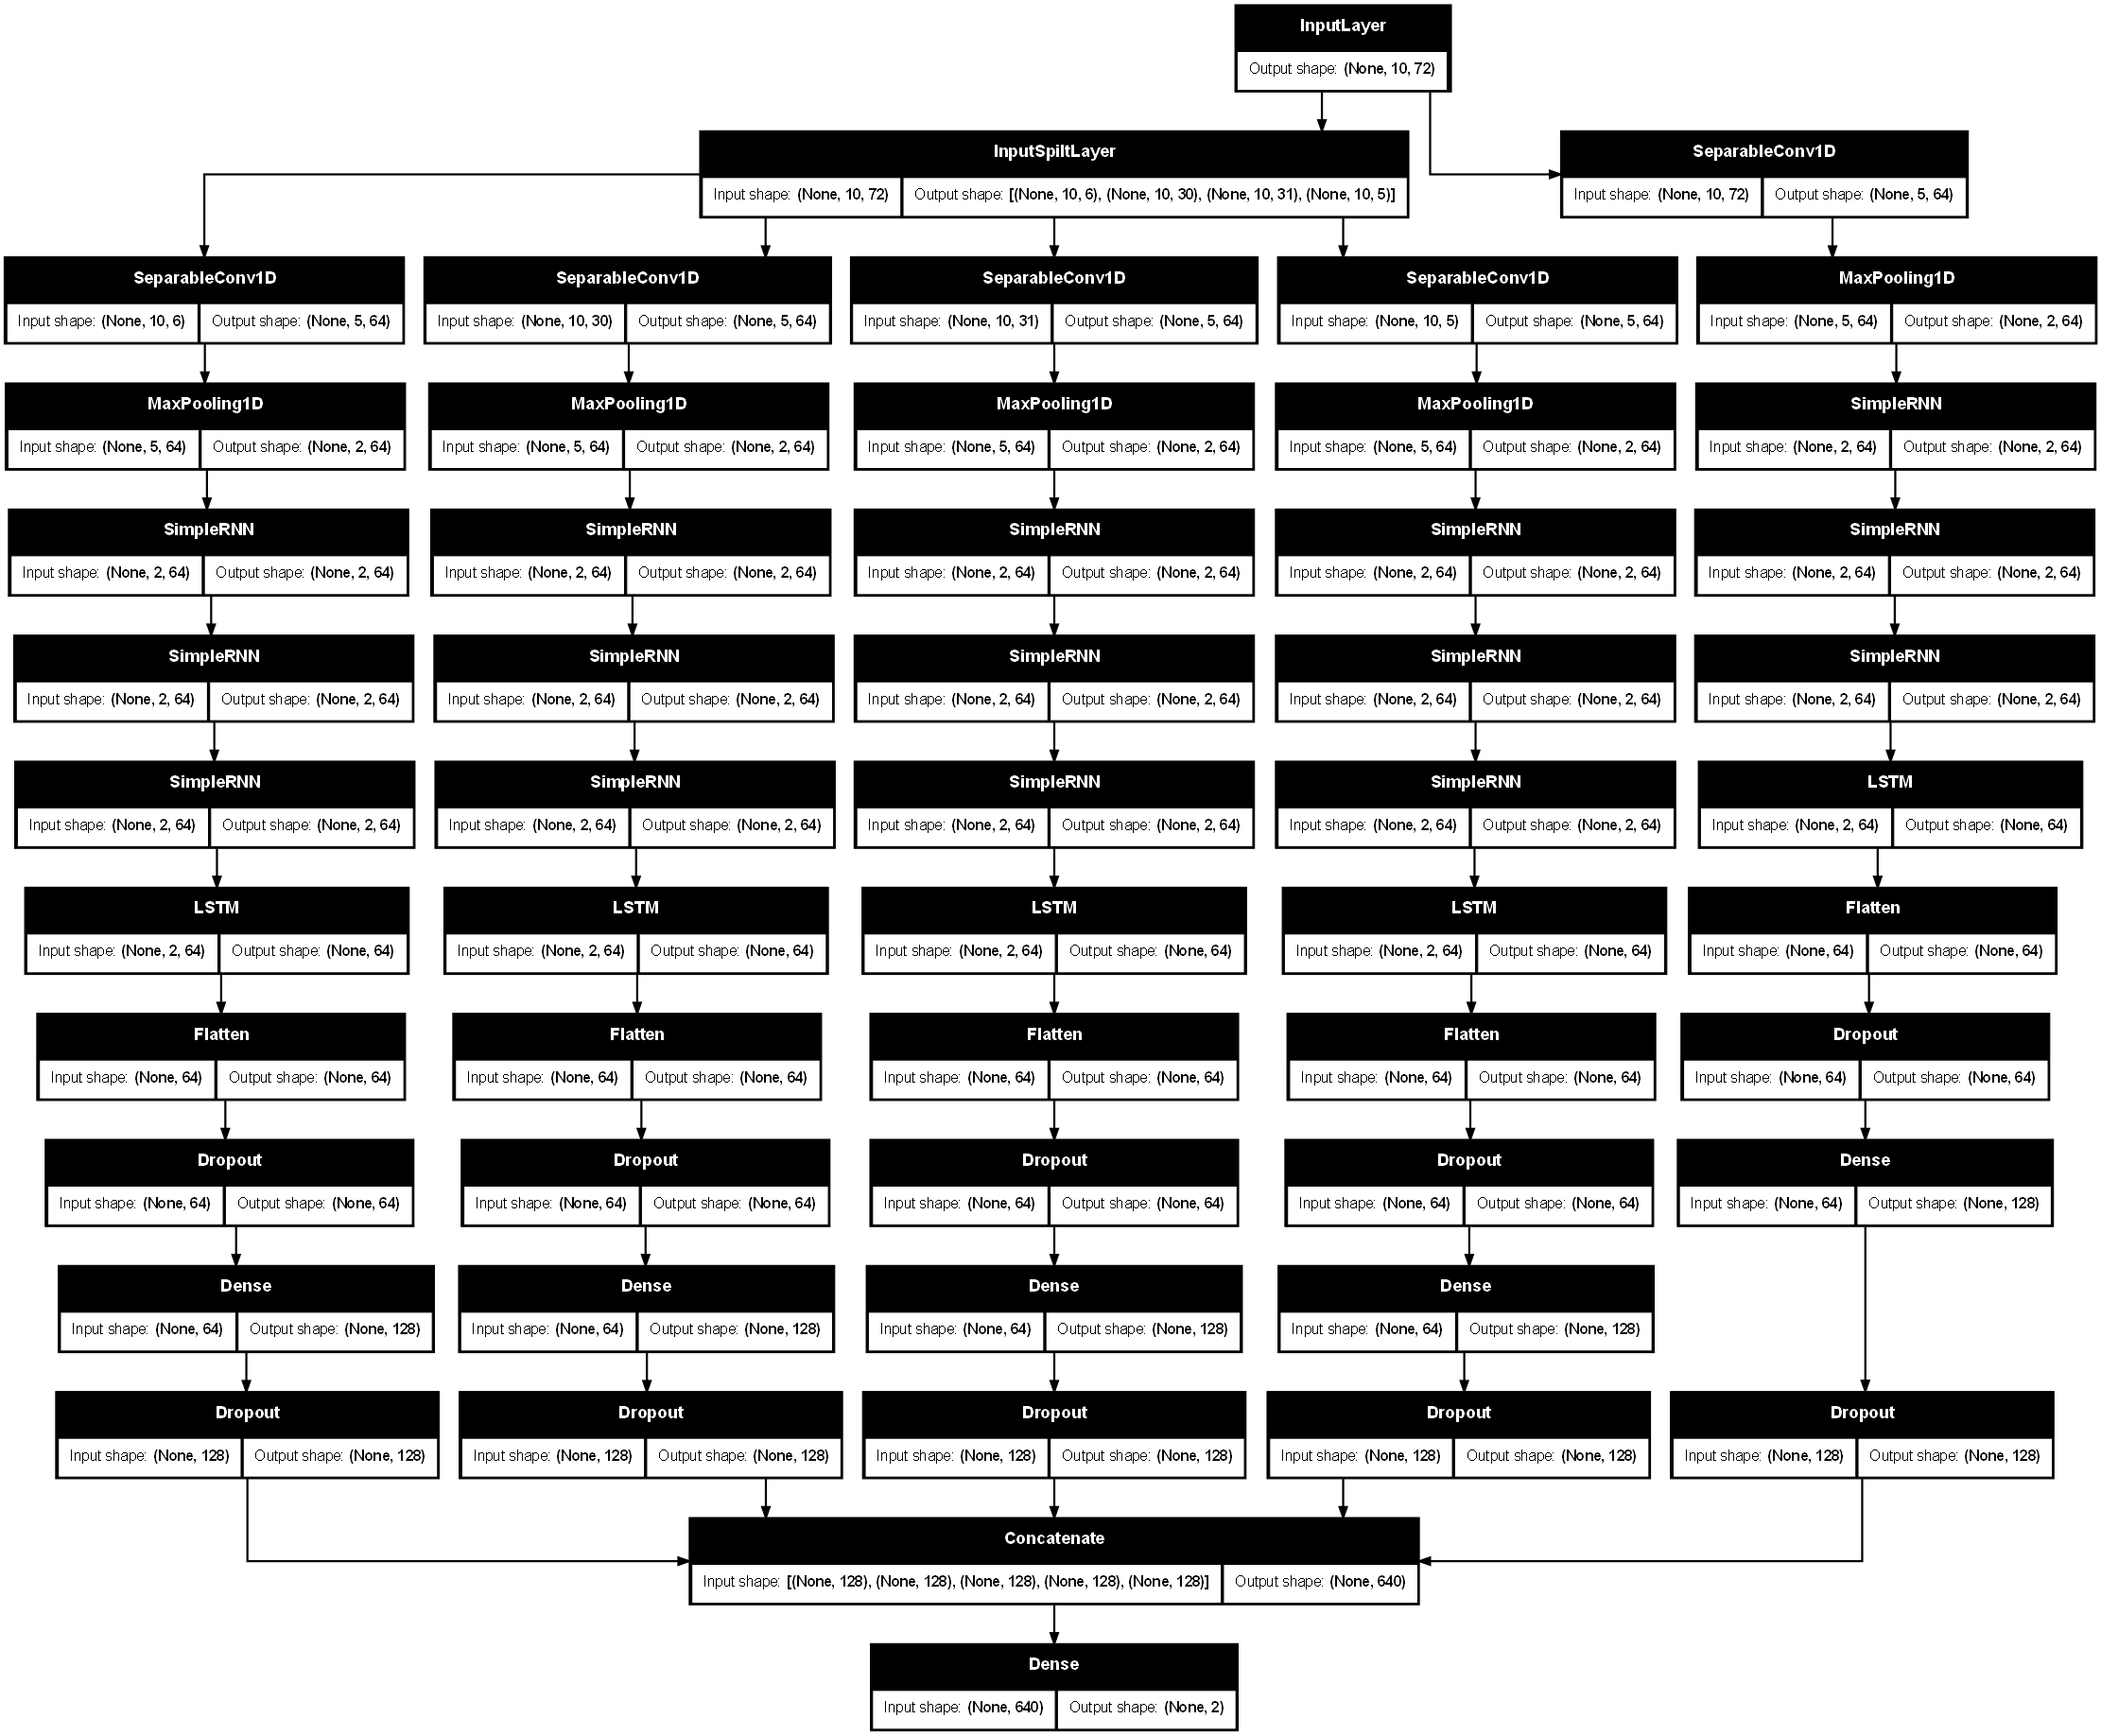

The INCY Model Classification Metrics:
Accuracy: 0.5514950166112956
Precision: 0.5451942852275078
Recall: 0.5514950166112956
F-Score: 0.4592872935164458
--------------------------------------------------------------


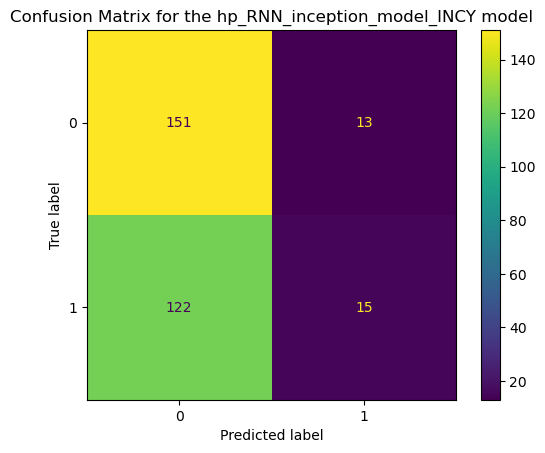

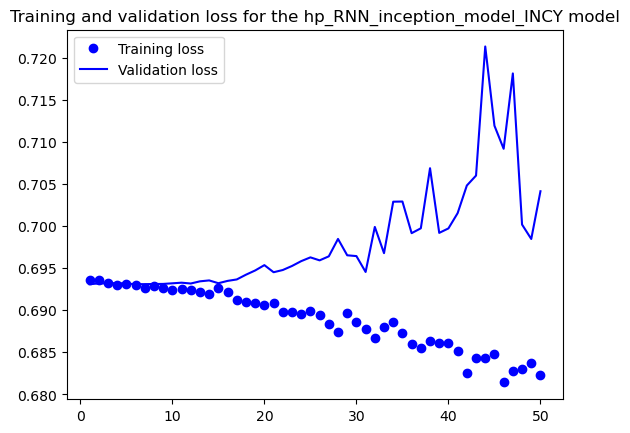

In [53]:
# evaluate the models in the archive
evaluate_models_archive(hp_RNN_inception_models_archive)

## Different data intervals 

We will use the HP_RNN_SC_Model to train models on each stock dataset, focusing on both short-term (1-day intervals) and long-term (1-month intervals) predictions. These models will be contrasted with the medium-term models (1-week intervals) that we have been experimenting with so far.

### 1 Day interval

In [ ]:
# insert the stock symbols into a list
symbols_list = ['PFE', 'ROP', 'XYL', 'CPAY', 'INCY']

# load the stock data for the 5 companies into a dictionary
dfs_1d = loadData(symbols=symbols_list, period='max', interval='1d')

# add the targets and technical indicators to each dataframe in the dictionary
full_dfs_1d = add_targets_and_indicators(dfs_1d.copy())

# get the trend up ratio of all the dataframes in the dictionary to get a sense of how balanced the data is
calculate_data_balance(full_dfs_1d)

# get the common sense baseline for each dataframe in the dictionary
calculate_common_sense_baseline(full_dfs_1d)

# apply the 3 steps of preparing data for training on each dataframe in the dictionary
target = 'classification' # set the target
timesteps = 10 # set the timesteps
data_sets_1d = prepare_data_to_train(full_dfs_1d.copy(), robust_scaler, target, timesteps)

# set the model initialization inputs
X_train_shape = data_sets_1d['PFE']['X_train'].shape
model_type='classification'
tuner = Hyperband


# create the model
hp_RNN_model_1d = HP_RNN_SC_Model(X_train_shape)


# create models archive for HP_RNNModel classification approach
hp_RNN_models_archive_1d = create_models_archive(hp_RNN_model_1d, 
                                                 data_sets_1d, 
                                                 _model_type=model_type, 
                                                 _tuner=tuner, 
                                                 _epochs=50, 
                                                 _model_name='hp_RNN_model_1d', 
                                                 _project_name='hp_RNN_models_archive_conv_flatten_1d')

Model summary for the hp_RNN_model_1d_PFE


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv1d_30                  │ (None, 5, 64)               │           5,104 │
│ (SeparableConv1D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_35 (MaxPooling1D)      │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 2, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_35 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_71 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161,908 (632.46 KB)

 Trainable params: 161,906 (632.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Model plot for the hp_RNN_model_1d_PFE


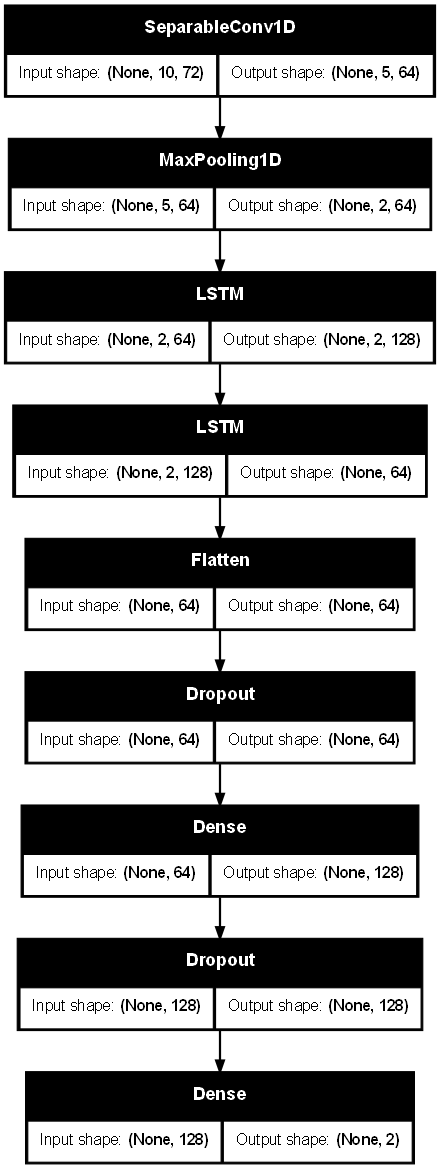

The PFE Model Classification Metrics:
Accuracy: 0.4968579807289485
Precision: 0.5045772464549522
Recall: 0.4968579807289485
F-Score: 0.42763820998078805
--------------------------------------------------------------


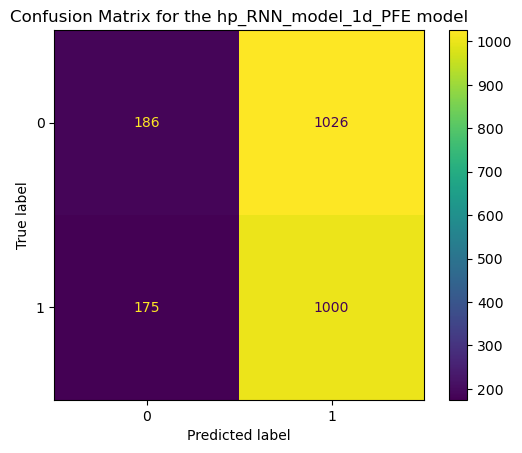

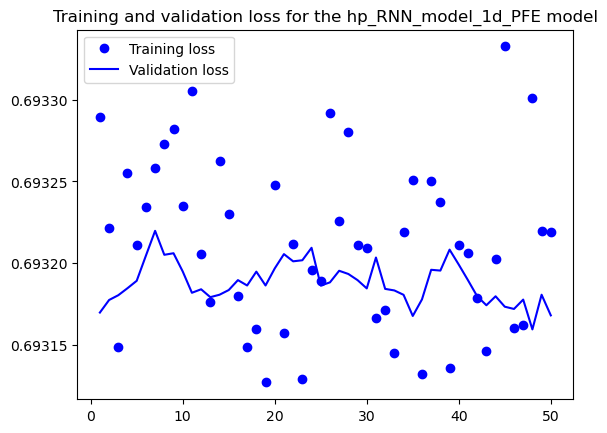

Model summary for the hp_RNN_model_1d_ROP


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv1d_31                  │ (None, 5, 64)               │           5,104 │
│ (SeparableConv1D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_36 (MaxPooling1D)      │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 2, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_98 (SimpleRNN)            │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_99 (SimpleRNN)            │ (None, 2, 128)              │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_41 (GRU)                         │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_36 (Flatten)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_73 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 634,712 (2.42 MB)

 Trainable params: 211,570 (826.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 423,142 (1.61 MB)

Model plot for the hp_RNN_model_1d_ROP


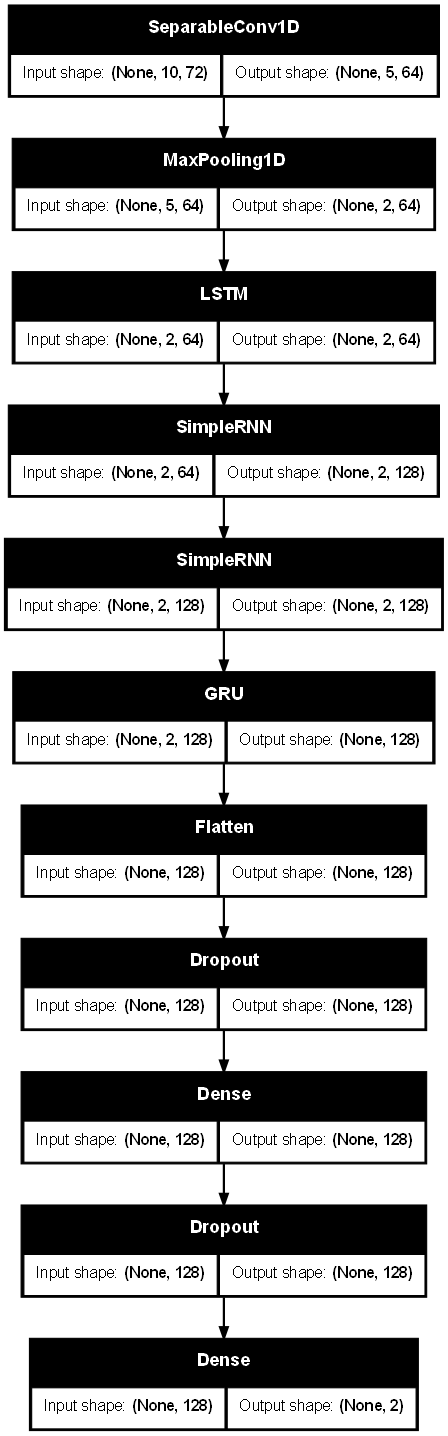

The ROP Model Classification Metrics:
Accuracy: 0.5352112676056338
Precision: 0.5103770620077477
Recall: 0.5352112676056338
F-Score: 0.43106072425400954
--------------------------------------------------------------


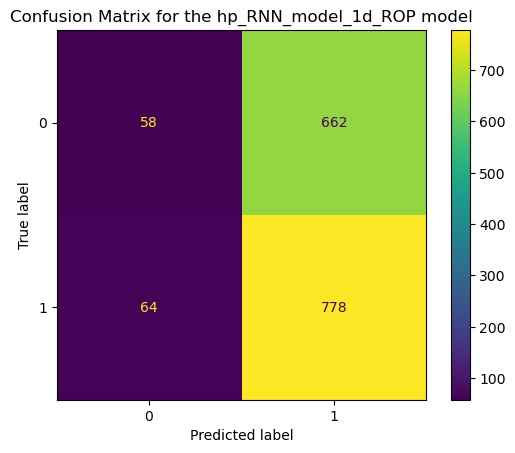

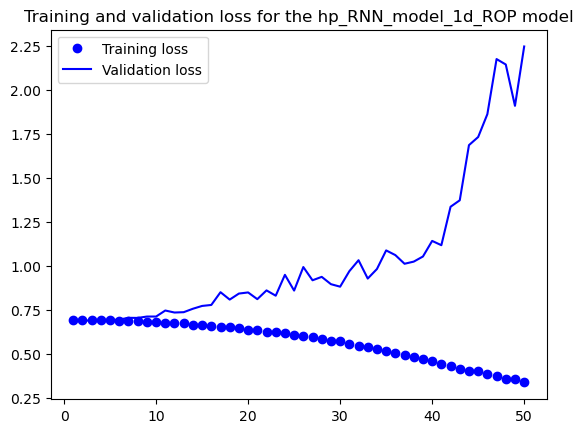

Model summary for the hp_RNN_model_1d_XYL


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv1d_32                  │ (None, 5, 64)               │           5,104 │
│ (SeparableConv1D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_37 (MaxPooling1D)      │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 2, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_37 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_74 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_75 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161,908 (632.46 KB)

 Trainable params: 161,906 (632.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Model plot for the hp_RNN_model_1d_XYL


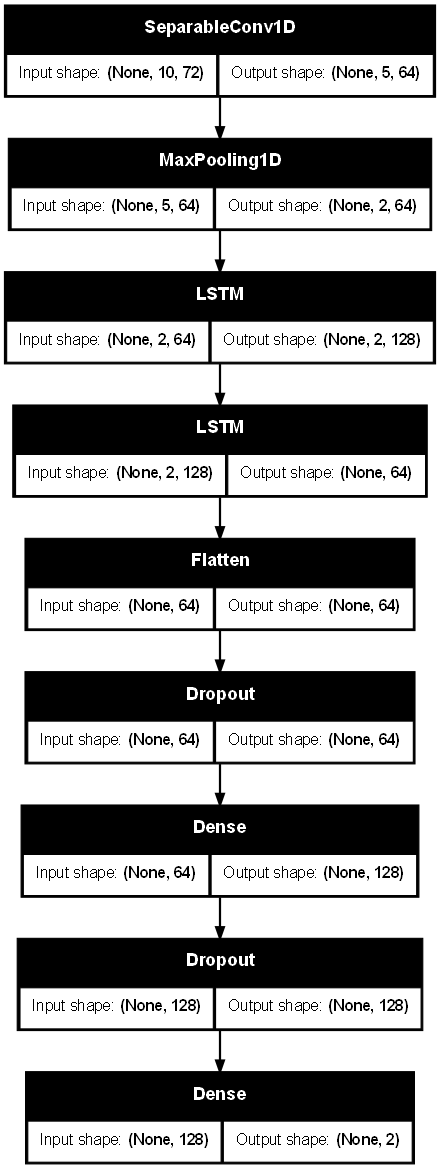

The XYL Model Classification Metrics:
Accuracy: 0.5279106858054227
Precision: 0.27868969218755163
Recall: 0.5279106858054227
F-Score: 0.36479840710145073
--------------------------------------------------------------


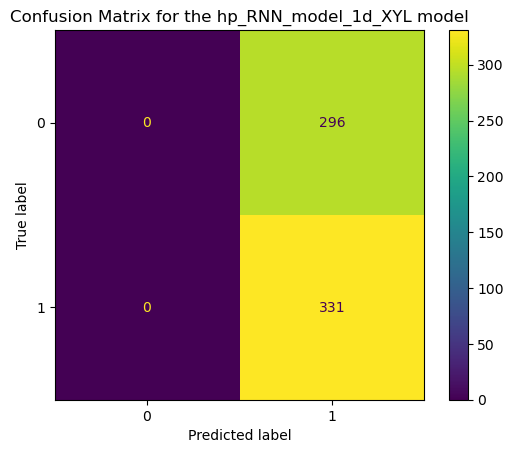

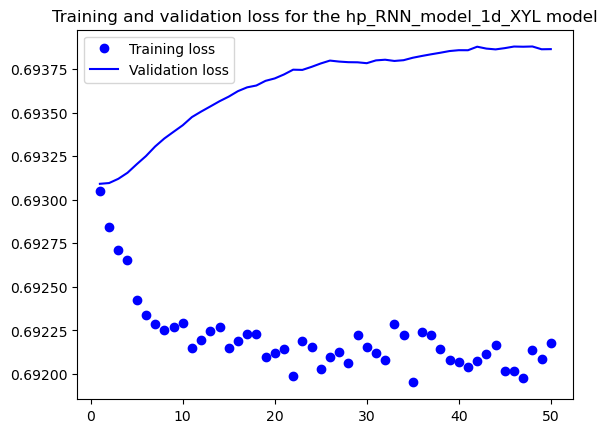

Model summary for the hp_RNN_model_1d_CPAY


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv1d_33                  │ (None, 5, 64)               │           5,104 │
│ (SeparableConv1D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_38 (MaxPooling1D)      │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_42 (GRU)                         │ (None, 2, 64)               │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_100 (SimpleRNN)           │ (None, 128)                 │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_38 (Flatten)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_76 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_77 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 143,078 (558.90 KB)

 Trainable params: 71,538 (279.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 71,540 (279.46 KB)

Model plot for the hp_RNN_model_1d_CPAY


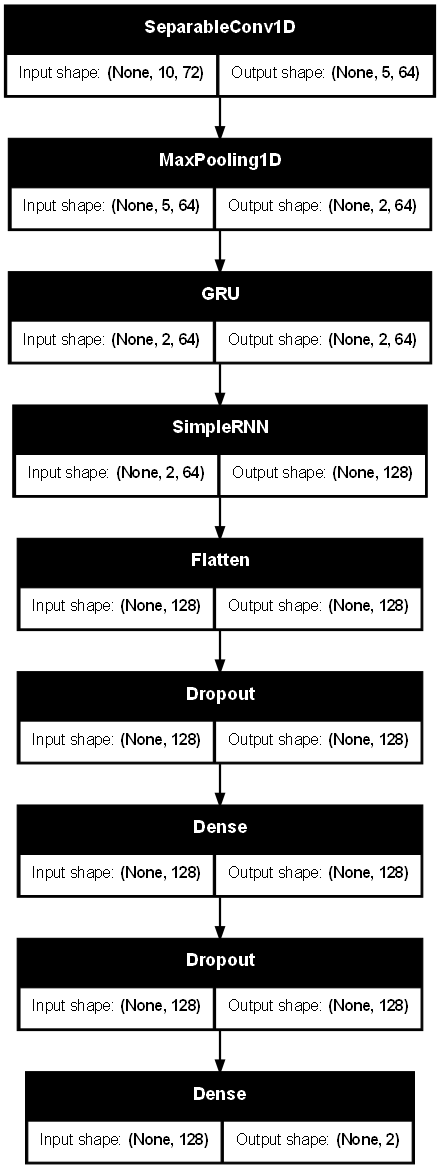

The CPAY Model Classification Metrics:
Accuracy: 0.48507462686567165
Precision: 0.49999218872621487
Recall: 0.48507462686567165
F-Score: 0.47431226157504536
--------------------------------------------------------------


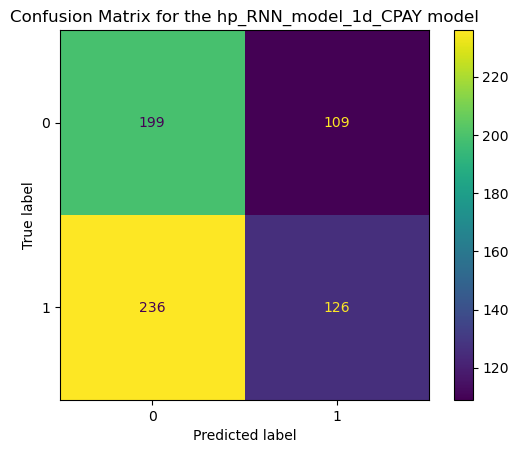

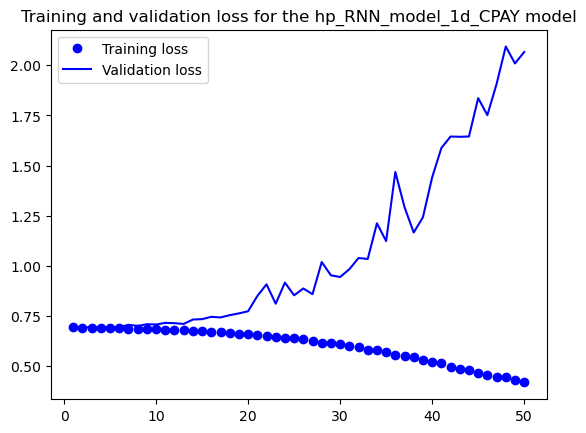

Model summary for the hp_RNN_model_1d_INCY


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv1d_34                  │ (None, 5, 64)               │           5,104 │
│ (SeparableConv1D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_39 (MaxPooling1D)      │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_101 (SimpleRNN)           │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_24 (LSTM)                       │ (None, 2, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_43 (GRU)                         │ (None, 2, 128)              │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_102 (SimpleRNN)           │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_39 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_79 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 349,286 (1.33 MB)

 Trainable params: 174,642 (682.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,644 (682.21 KB)

Model plot for the hp_RNN_model_1d_INCY


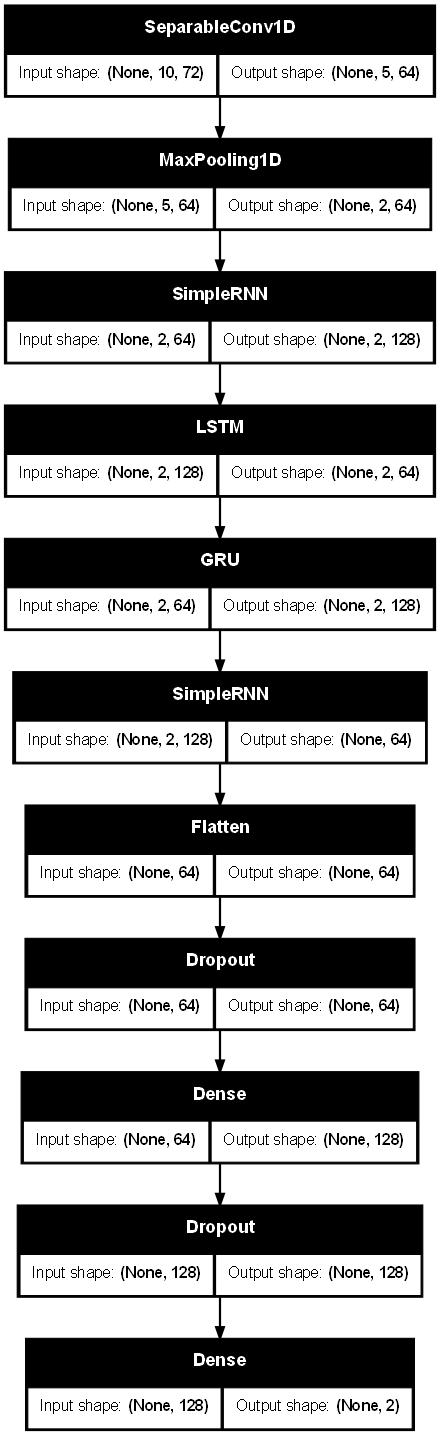

The INCY Model Classification Metrics:
Accuracy: 0.4812332439678284
Precision: 0.484168593462606
Recall: 0.4812332439678284
F-Score: 0.38887610412423723
--------------------------------------------------------------


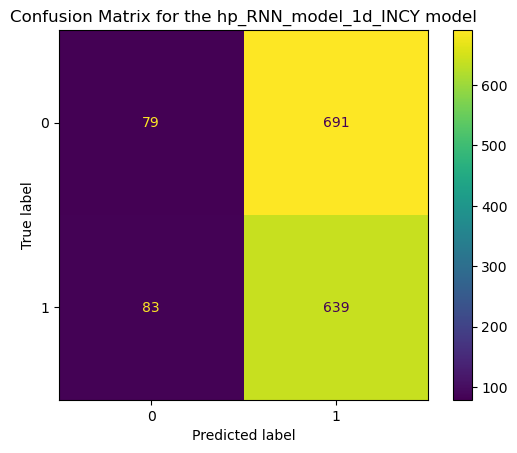

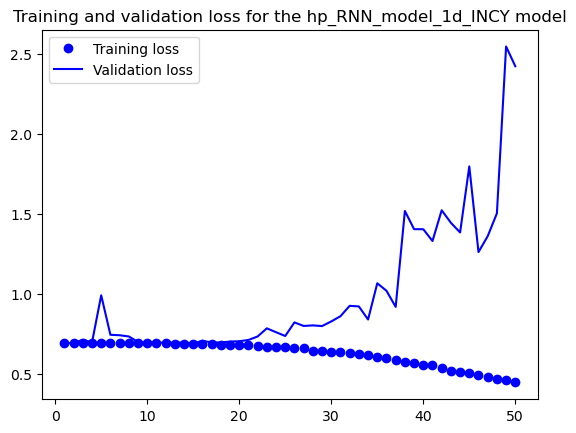

In [55]:
# evaluate the models in the archive
evaluate_models_archive(hp_RNN_models_archive_1d)

### 1 Month interval

In [ ]:
# insert the stock symbols into a list
symbols_list = ['PFE', 'ROP', 'XYL', 'CPAY', 'INCY']

# load the stock data for the 5 companies into a dictionary
dfs_1m = loadData(symbols=symbols_list, period='max', interval='1mo')

# add the targets and technical indicators to each dataframe in the dictionary
full_dfs_1m = add_targets_and_indicators(dfs_1m.copy())

# get the trend up ratio of all the dataframes in the dictionary to get a sense of how balanced the data is
calculate_data_balance(full_dfs_1m)

# get the common sense baseline for each dataframe in the dictionary
calculate_common_sense_baseline(full_dfs_1m)

# apply the 3 steps of preparing data for training on each dataframe in the dictionary
target = 'classification' # set the target
timesteps = 10 # set the timesteps
data_sets_1m = prepare_data_to_train(full_dfs_1m.copy(), robust_scaler, target, timesteps)

# set the model initialization inputs
X_train_shape = data_sets_1m['PFE']['X_train'].shape
model_type='classification'
tuner = Hyperband

# create the model
hp_RNN_model_1m = HP_RNN_SC_Model(X_train_shape)

# create models archive for simpleRNN classification approach
hp_RNN_models_archive_1m = create_models_archive(hp_RNN_model_1m, 
                                                 data_sets_1m, 
                                                 _model_type=model_type, 
                                                 _tuner=tuner, 
                                                 _epochs=50, 
                                                 _model_name='hp_RNN_model_1m', 
                                                 _project_name='hp_RNN_model_archive_1m')

Model summary for the hp_RNN_model_1m_PFE


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv1d_35                  │ (None, 5, 64)               │           5,104 │
│ (SeparableConv1D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_40 (MaxPooling1D)      │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_103 (SimpleRNN)           │ (None, 2, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 2, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_44 (GRU)                         │ (None, 2, 128)              │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_104 (SimpleRNN)           │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_40 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_81 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 696,536 (2.66 MB)

 Trainable params: 232,178 (906.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 464,358 (1.77 MB)

Model plot for the hp_RNN_model_1m_PFE


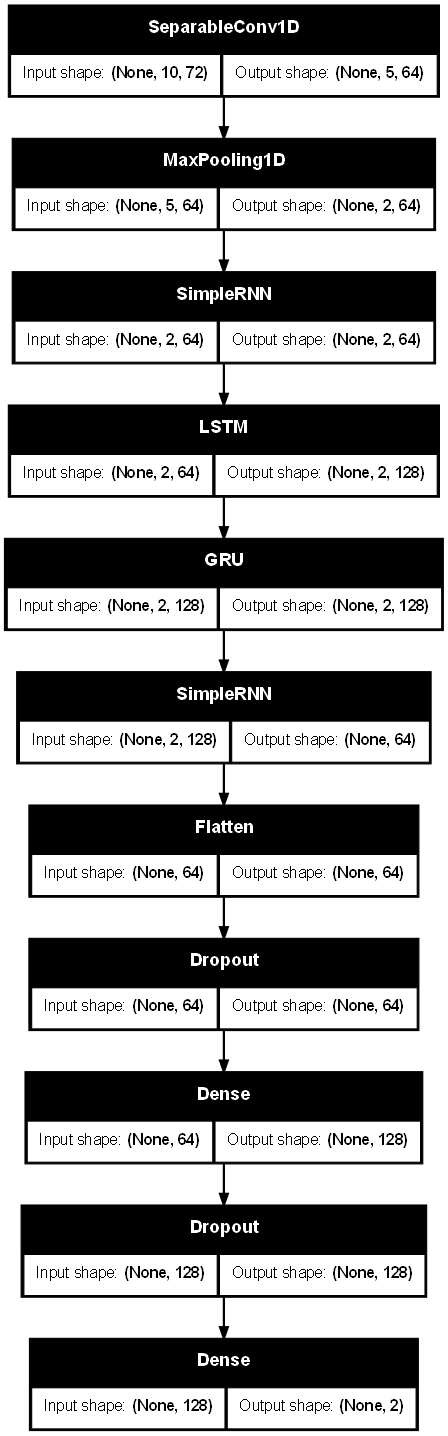

The PFE Model Classification Metrics:
Accuracy: 0.4935064935064935
Precision: 0.35998964803312633
Recall: 0.4935064935064935
F-Score: 0.3951157842804724
--------------------------------------------------------------


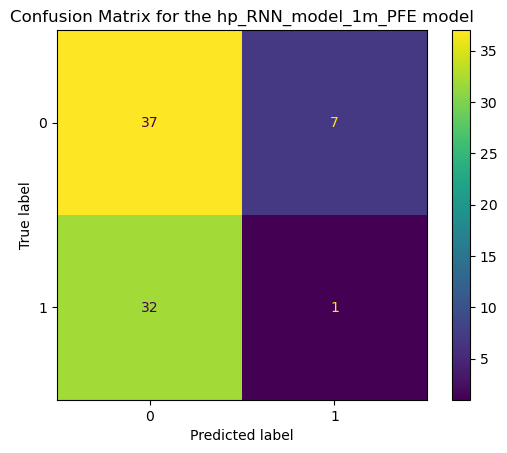

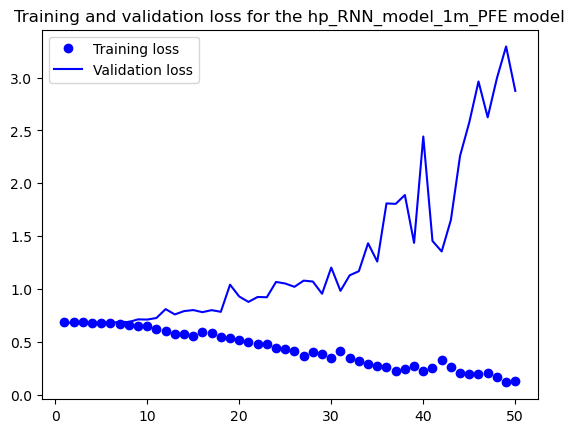

Model summary for the hp_RNN_model_1m_ROP


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv1d_36                  │ (None, 5, 64)               │           5,104 │
│ (SeparableConv1D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_41 (MaxPooling1D)      │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_105 (SimpleRNN)           │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_106 (SimpleRNN)           │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_41 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_82 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_83 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 152,216 (594.60 KB)

 Trainable params: 50,738 (198.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 101,478 (396.40 KB)

Model plot for the hp_RNN_model_1m_ROP


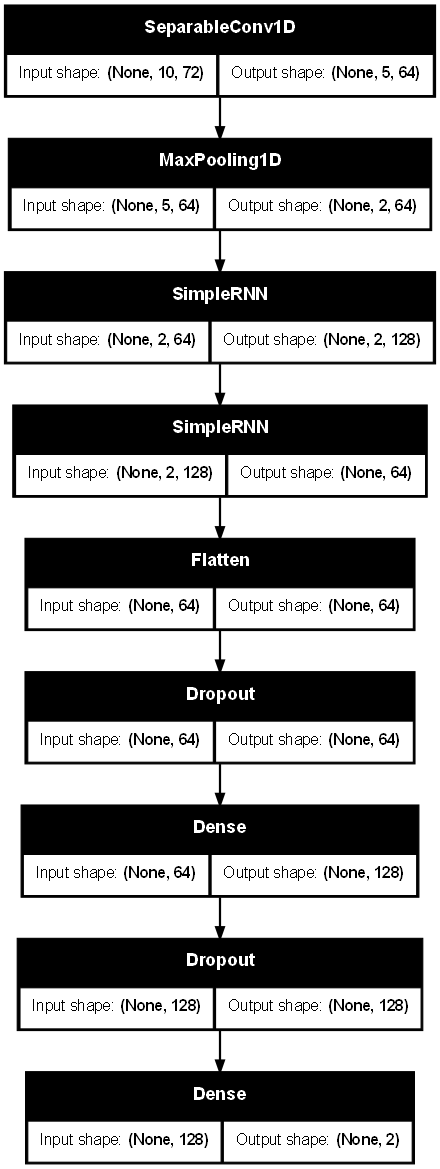

The ROP Model Classification Metrics:
Accuracy: 0.5166666666666667
Precision: 0.46490384615384617
Recall: 0.5166666666666667
F-Score: 0.4394957983193278
--------------------------------------------------------------


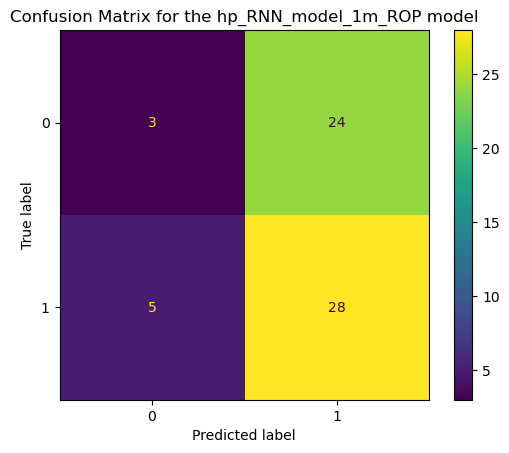

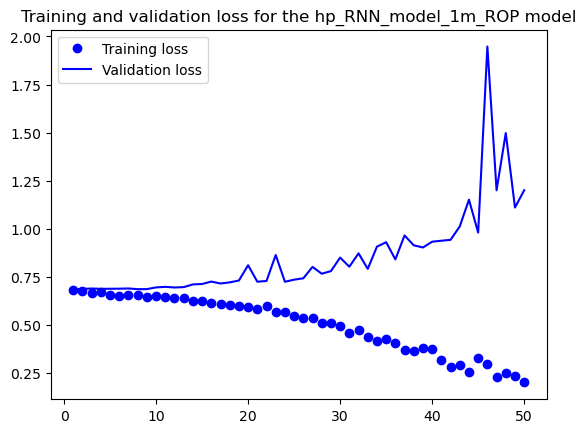

Model summary for the hp_RNN_model_1m_XYL


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv1d_37                  │ (None, 5, 64)               │           5,104 │
│ (SeparableConv1D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_42 (MaxPooling1D)      │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_107 (SimpleRNN)           │ (None, 2, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 2, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_45 (GRU)                         │ (None, 2, 128)              │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_108 (SimpleRNN)           │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_42 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_84 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_85 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 696,536 (2.66 MB)

 Trainable params: 232,178 (906.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 464,358 (1.77 MB)

Model plot for the hp_RNN_model_1m_XYL


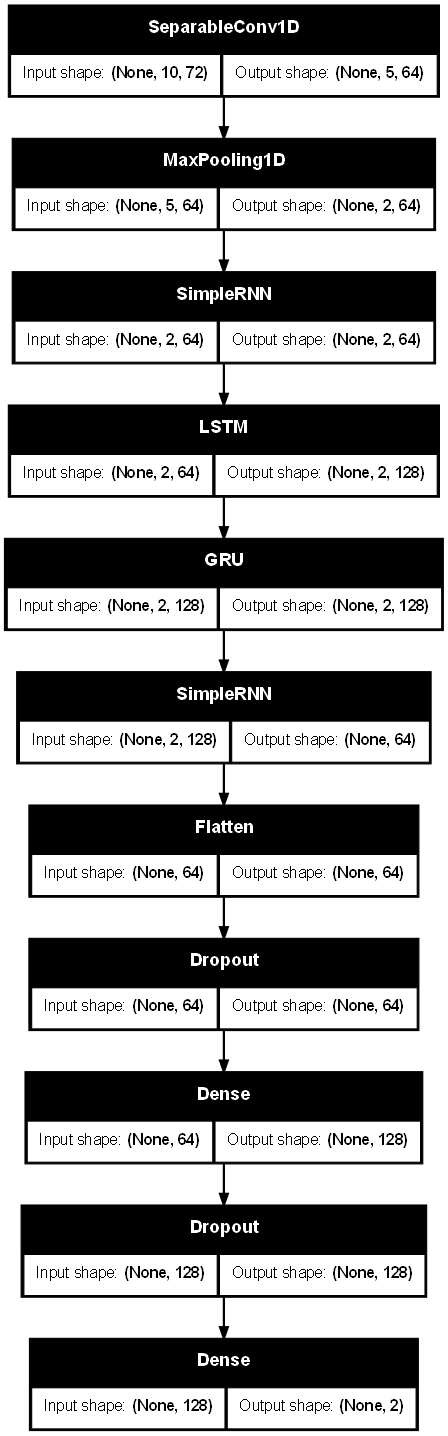

The XYL Model Classification Metrics:
Accuracy: 0.5384615384615384
Precision: 0.49743589743589745
Recall: 0.5384615384615384
F-Score: 0.5064102564102564
--------------------------------------------------------------


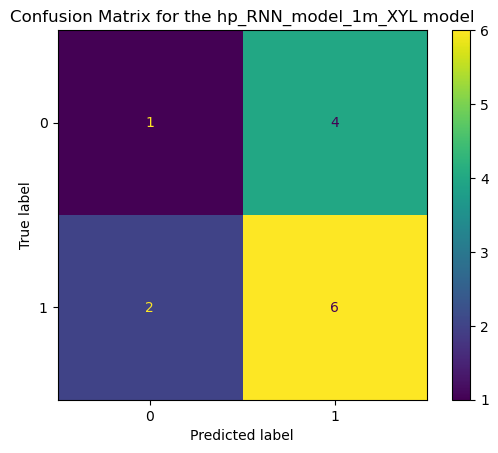

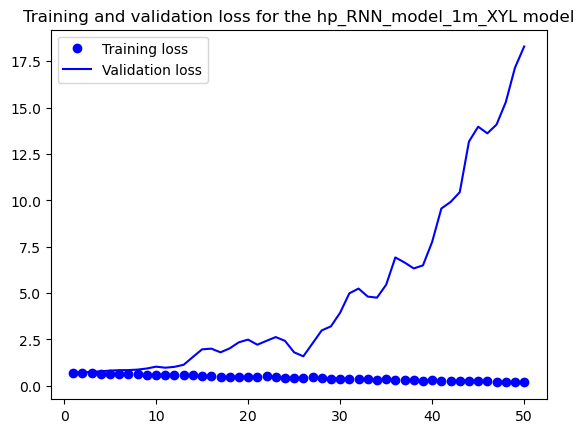

Model summary for the hp_RNN_model_1m_CPAY


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv1d_38                  │ (None, 5, 64)               │           5,104 │
│ (SeparableConv1D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_43 (MaxPooling1D)      │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_109 (SimpleRNN)           │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 2, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_46 (GRU)                         │ (None, 2, 128)              │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_110 (SimpleRNN)           │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_43 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_86 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_87 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 349,286 (1.33 MB)

 Trainable params: 174,642 (682.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,644 (682.21 KB)

Model plot for the hp_RNN_model_1m_CPAY


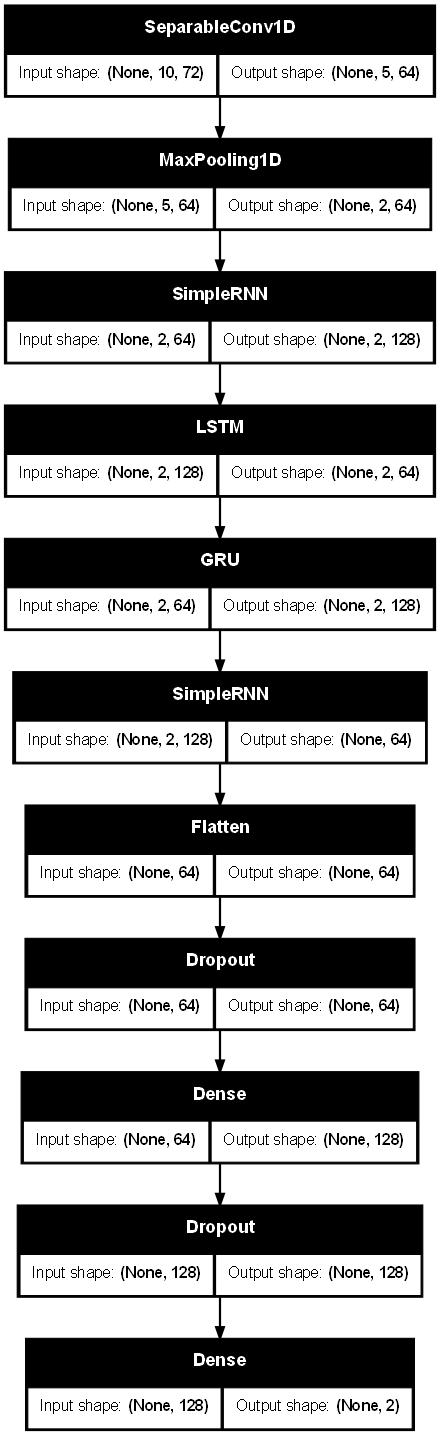

The CPAY Model Classification Metrics:
Accuracy: 0.5333333333333333
Precision: 0.28444444444444444
Recall: 0.5333333333333333
F-Score: 0.3710144927536232
--------------------------------------------------------------


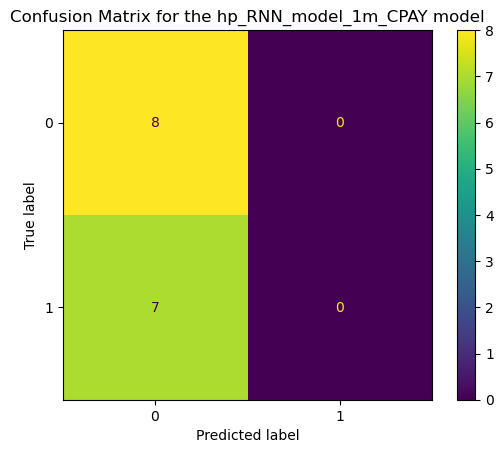

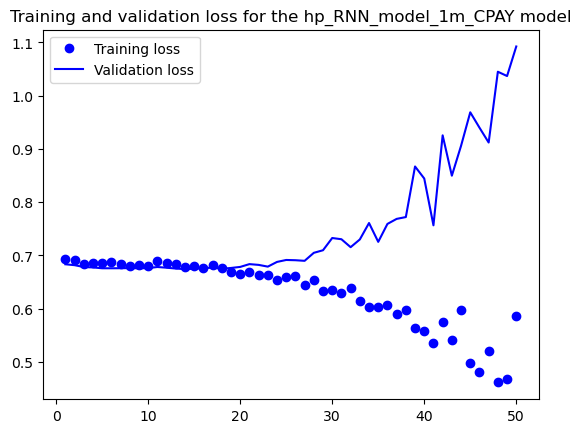

Model summary for the hp_RNN_model_1m_INCY


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv1d_39                  │ (None, 5, 64)               │           5,104 │
│ (SeparableConv1D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_44 (MaxPooling1D)      │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_111 (SimpleRNN)           │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_28 (LSTM)                       │ (None, 2, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_47 (GRU)                         │ (None, 2, 128)              │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_112 (SimpleRNN)           │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_44 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_88 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_89 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 349,286 (1.33 MB)

 Trainable params: 174,642 (682.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,644 (682.21 KB)

Model plot for the hp_RNN_model_1m_INCY


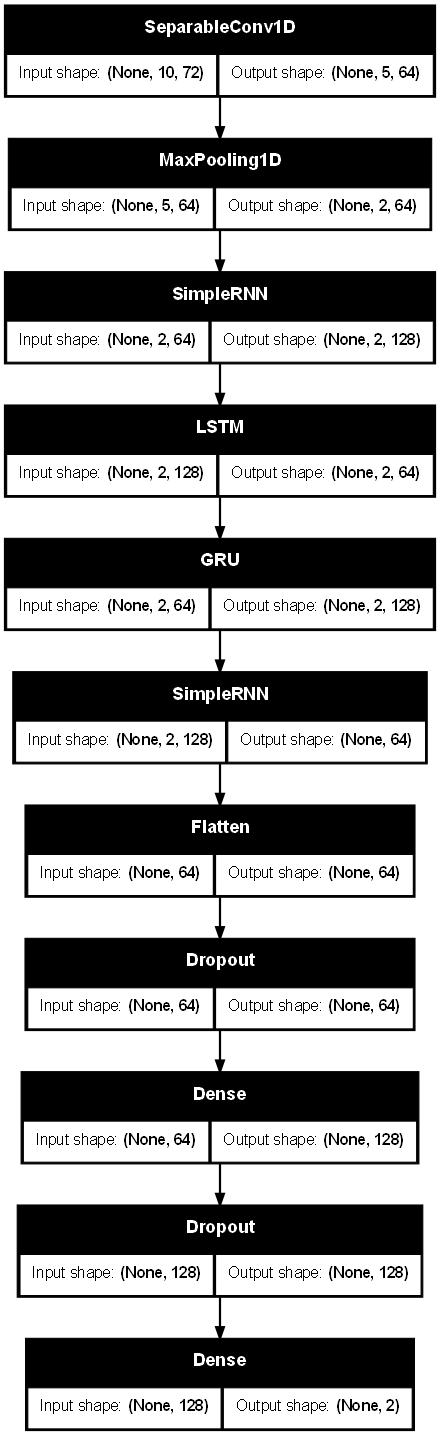

The INCY Model Classification Metrics:
Accuracy: 0.4642857142857143
Precision: 0.21556122448979592
Recall: 0.4642857142857143
F-Score: 0.29442508710801396
--------------------------------------------------------------


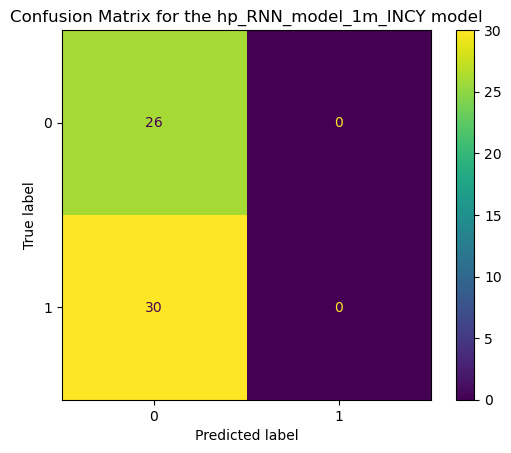

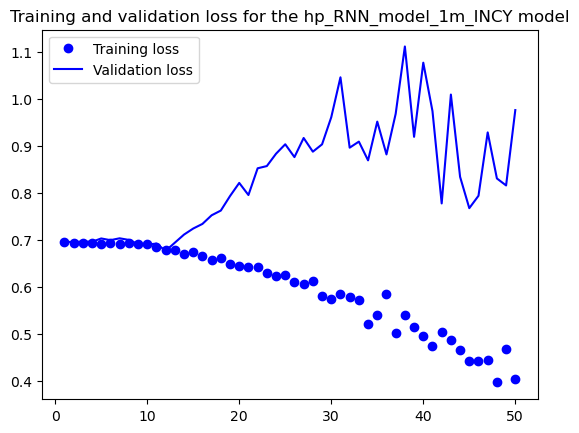

In [57]:
# evaluate the models in the archive
evaluate_models_archive(hp_RNN_models_archive_1m)

### End of the implementation section